## GA Draft Paper: Constantine Chrysostomou ##

### Identifying Heart Conditions from Audio Recordings

### 05/03/2017 ###



## Description ##

This is a question devised by: [Bentley et al](http://www.peterjbentley.com/heartchallenge/).

Signs of potential heart conditions can be identified from abnormal heartbeats. Doctors can diagnose abnormal beats via a stethoscope. A heartbeat can be defined by repeated patterns of two discerning sounds, lub (aka S1) and dub (aka S2). Each sound corresponds to the opening and closing of valves in the heart (A detailed description can be [found here](https://www.khanacademy.org/science/health-and-medicine/circulatory-system/circulatory-system-introduction/v/lub-dub)). The ability to design methods for identifying abnormalities in heartbeats without the need of a doctor could have a signficant impact on the ability to catch early signs of heart disease.

The task of this problem is to demonstrate that machine learning algorithms can be used to correctly classify the lub/dub sounds in a heartbeat and subsequently identify abnormalities in heartbeats.  Data is provided from both 'real-world' situations where recordings were provided from recordings taken from non-medical devices (i.e. an iphone), and from a hospital environment using digital stethoscopes. Note, the former (mobile device recordings) will contain a higher amount of bacgkround noise.

The problem has been broken down into two challenges:
1. Given a set of digital recordings, identify time points in each file that correspond to a lub or dub event
2. Given a set of digital recordings and known abnormalities, classify heartbeats by potential conditions (refer [here](https://www.khanacademy.org/science/health-and-medicine/circulatory-system-diseases/heart-valve-diseases/v/systolic-murmurs-diastolic-murmurs-and-extra-heart-sounds-part-1) for details):
 * Normal heartbeat
 * Murmur
 * Extra heart sound
 * Artifact
 * Extrasystole


## Aim ##

**For this notebook, we will address the first challenge where we try to identify the positions of the S1/S2 heartbeat sounds in an audio file**


_______________________

## The Data ##

### Datasets ###
The creator of the dataset has provided two datasets. These datasets can be downloaded [here](http://www.peterjbentley.com/heartchallenge/). 

**DatasetA (176 wav files): ** The source of this data is provided from the general public via the iStethoscope Pro iPhone App

**DatasetB (656 wav files): ** The source of this data is provided from a clinical trial in hospitals using a digital stethoscope.

The following image further describes the datasets:

<img src='heart_dataset_description.PNG'/>

### Training ###

1. In order to train soundfiles to demarcate lub/dub events, two files have been provided for each dataset. The files, [A/B]training_normal.csv are simple text files that explicity write out the exact timepoint at which a LUB sound can be heard in a specific file and, similarly, at which time point a DUB sound can be heard in a audo file. 


### Evaluation ###

1. In order to evaluate challenge 1, an excel file has been provided in the Evaluation.zip file. this excel file allows users to paste in their predictions for when a lub/dub is heart in specific sound files. given the provided answers, a resulting score will be produced summarizing how close those results were to the true positions of the S1/S2 sounds

*Note: No files were provided for evaluating results from the iStethoscope App, so we will only be using DatasetB audio files to train and evaluate our model*

In [211]:
from IPython.core.display import Javascript, display
display(Javascript("""
    $('head').append(
        "<style type='text/css'>tbody tr:nth-child(even){background-color: #f6f8fa}tbody tr:nth-child(odd){background-color: #fff}</style>"
    );
"""))
from IPython.display import Image

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<IPython.core.display.Javascript object>

_______________________


## Getting Started ##

**The following modules will be imported for working with the wav files:**
1. soundfile: we will use this module to read/write wave files
2. scipy.fftpack: this set of libraries contains functions for converting amplitude vs time signal into amplitude vs frequency (converts to fourier signal via fast fourier transform)
3. scipy.signal: use these methods to perform 'low pass filtering' (i.e. filter out high frequencies which contribute to a file)

In [1]:
# import modules we will need to use for processing data
import soundfile as sf
import os
import numpy as np
import pandas as pd
from scipy import fftpack, signal
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from matplotlib import pyplot as plt
from collections import OrderedDict
from itertools import combinations
import multiprocessing
import operator
%matplotlib inline


In [ ]:
# import libraries/models we will be using from sklearn
# normalization and standardization
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # for normalization
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score  # from cross validation
from sklearn.metrics import accuracy_score  # for evaluation of the accuracy

# sklearn optimiziation utils
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.externals import six
from sklearn.base import ClassifierMixin
from sklearn.pipeline import _name_estimators
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve


# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


# pipelines
from sklearn.pipeline import Pipeline

In [3]:
# project specific code
from reading_wave_data import heart_signal, load_wav_data_into_features
from sequential_feature_remover import SBS

In [4]:
# allow auto reload of code
%load_ext autoreload
%autoreload 2

In [5]:
# change font sizes in plots
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## Working with WAV files ##

Using the soundfile module, we can read in a wave file into a numpy array. The number of elements in the array represents the total "frames" in that file (in other words, the number of times 'sound' was sampled in the recording). The value of each element in the array is simply the 'amplitude' of sound at that frame.

**The samplerate/framerate of a wave file represents the total number of 'frames' captured per second**

In [6]:
def load_wav(wav_path):
    """
        Load a wav file into a numpy array
        
        Args:
            wav_path (string): location of the wav file
            
        Returns:
            sound_arr (numpy array): a 1D array of the sound file
            samplerate (int): The sample rate of the sound file
    """
    sound_arr, samplerate = sf.read(wav_path)
    
    return sound_arr, samplerate

sample_file = 'sample_data/normal__201104141251.wav'

sound_arr, samplerate = load_wav(sample_file)

print('The sample rate is: ' + str(samplerate) +' frames/second')

The sample rate is: 44100 frames/second


In [7]:
print('The resulting wav file (Total shape={0} frames): '.format(sound_arr.shape[0]))
print(sound_arr)

The resulting wav file (Total shape=336831 frames): 
[ 0.00134277  0.0012207   0.0012207  ...,  0.00030518  0.00015259
  0.00012207]


**The above shows that the sample wav file provided is 336831 frames and is in the format of a 1-D numpy array. To convert the data to 'time' we just need to divide the # of total frames over the frame rate: **

\begin{equation*}
frames/(frames/second) = second
\end{equation*}

In [8]:
print('Total length of wav file: {0} seconds'.format(str(sound_arr.shape[0]/(1.0*samplerate))))

Total length of wav file: 7.63789115646 seconds


** To get an idea of what the actual audio file looks like however, simply plot the amplitude signal in the numpy array over time **

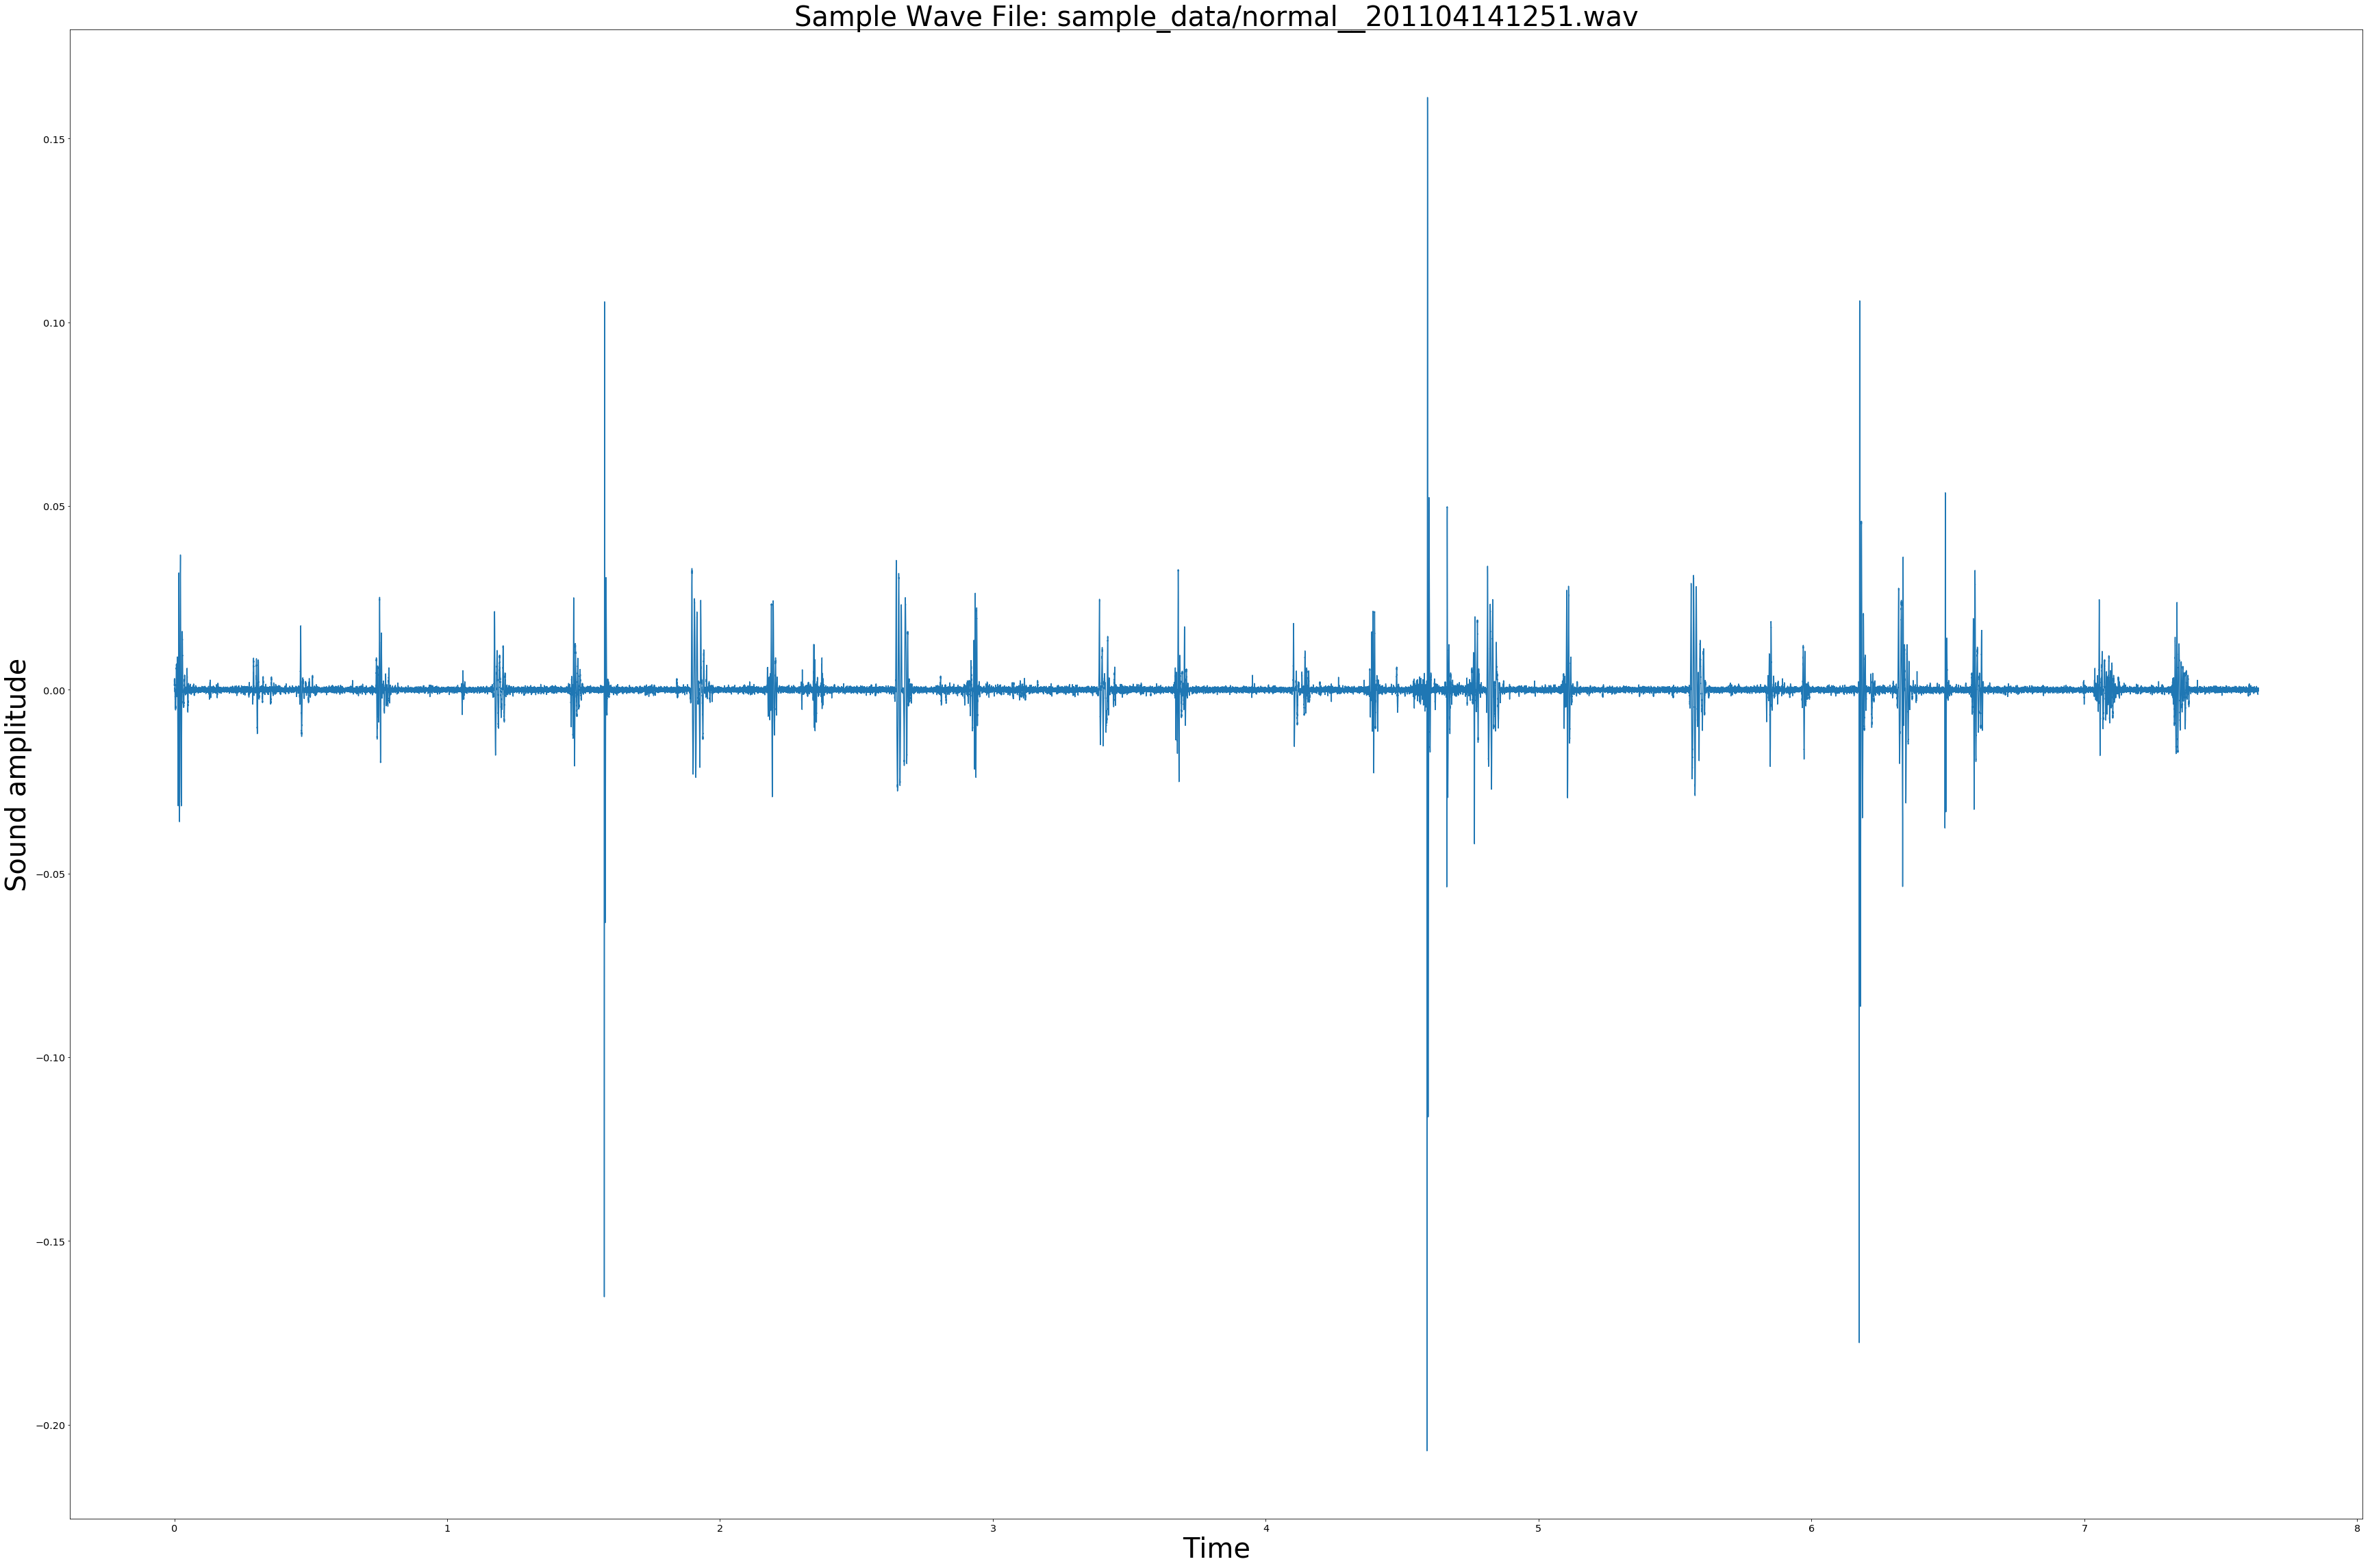

In [9]:
fig = plt.figure(figsize=(60, 40))
ax = plt.subplot(111)
ax.plot(
    np.arange(sound_arr.shape[0])/(1.0 * samplerate),
    sound_arr
)
plt.title('Sample Wave File: sample_data/normal__201104141251.wav', fontsize=40)
ax.set_xlabel('Time', fontsize=40)
ax.set_ylabel('Sound amplitude', fontsize=40)

** From the plot above we can see clear peaks most likely corresponding to the LUB/DUB sounds. However, we also notice dense areas that look like white noise. The next step is to use a low-pass filter to try and clean up the data and remove any noise **

A low pass filter simply removes the high frequency noise data from a file. The cutoff for a 'high frequency' is determined by the user. For our data we will use 50hz as the high frequency cutoff

In [10]:
#   creating-lowpass-filter-in-scipy-understanding-methods-and-units
# Taken from  https://stackoverflow.com/questions/25191620/
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def filter_noise(signal, cutoff, samplerate):    
    """
    Runs a low pass filter on a signal. High frequencies are defined as those >=cutoff
    
    Args:
        signal (numpy array): The signal file that needs to be filtered
        cutoff (int): A frequency value (in hertz) to treat as the high frequency cutoff
        samplerate (int): The framerate of the file
    """
    # Filter the data, and plot both the original and filtered signals.
    return butter_lowpass_filter(signal, cutoff, samplerate)



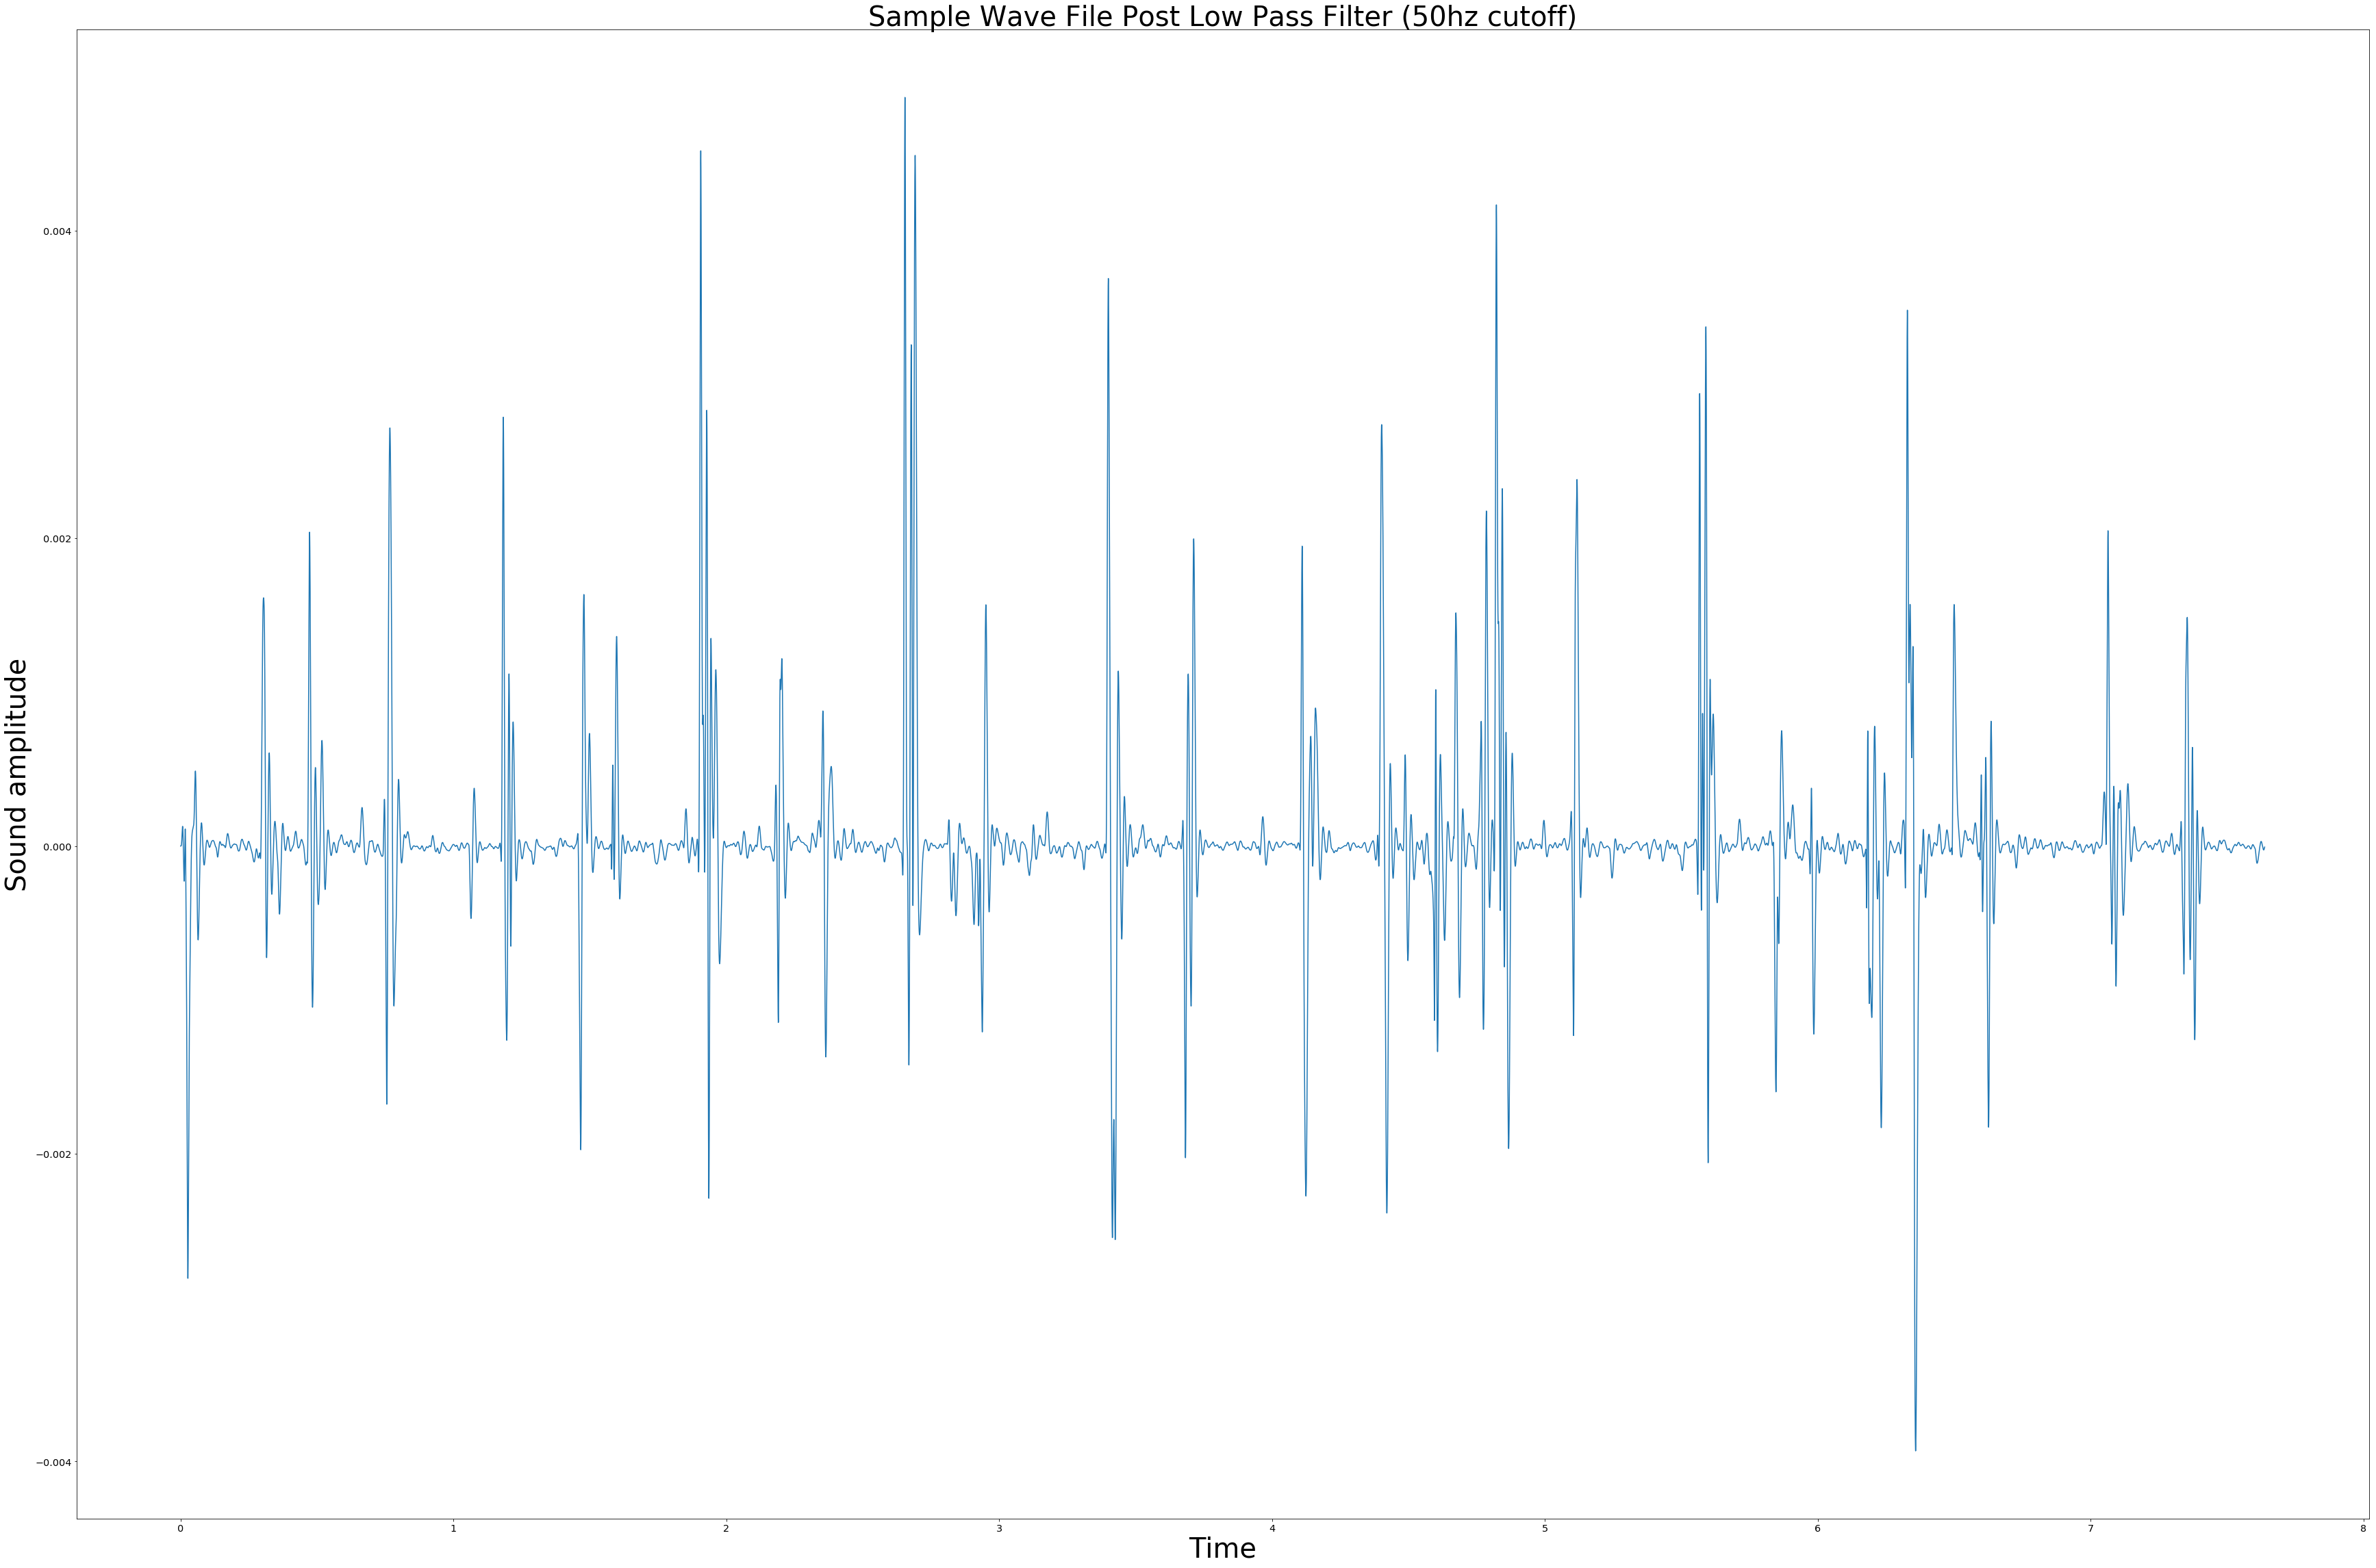

In [11]:
sound_arr_noise_filtered = filter_noise(sound_arr, 50, samplerate)
fig = plt.figure(figsize=(60, 40))
ax = plt.subplot(111)
ax.plot(
    np.arange(sound_arr_noise_filtered.shape[0])/(1.0 * samplerate),
    sound_arr_noise_filtered
)
plt.title('Sample Wave File Post Low Pass Filter (50hz cutoff)', fontsize=40)
ax.set_xlabel('Time', fontsize=40)
ax.set_ylabel('Sound amplitude', fontsize=40)

** The sound file shows a repeated pattern. This pattern is most likely mainly contributed by the hearbeat. When analyzing audio files its sometimes usefull to be able to look at it in the frequency domain. I.e. rather than look at amplitude vs time, look at amplitude vs frequency **

Frequencies with high amplitudes contribute most to the overal pattern/repeated signals in the audio file

In [12]:
def get_fourier(signal, samplerate=1):
    """
    Convert a signal from the time domain to the frequency domain
    
    Args:
        signal (numpy array): array to convert
        samplerate (int): framerate of the signal
        
    Returns:
        four_series (pd.Series): A series of values. Index represents a frequency, values represents amplitude in each freq        
    """
    tmp = signal[~np.isnan(signal)]
    fft_signal = fftpack.fftshift(fftpack.fft(tmp))
    fft_freqs = fftpack.fftshift(fftpack.fftfreq(tmp.shape[0], 1.0/samplerate))
    return pd.Series(fft_signal, index=fft_freqs)

(-1000, 1000)

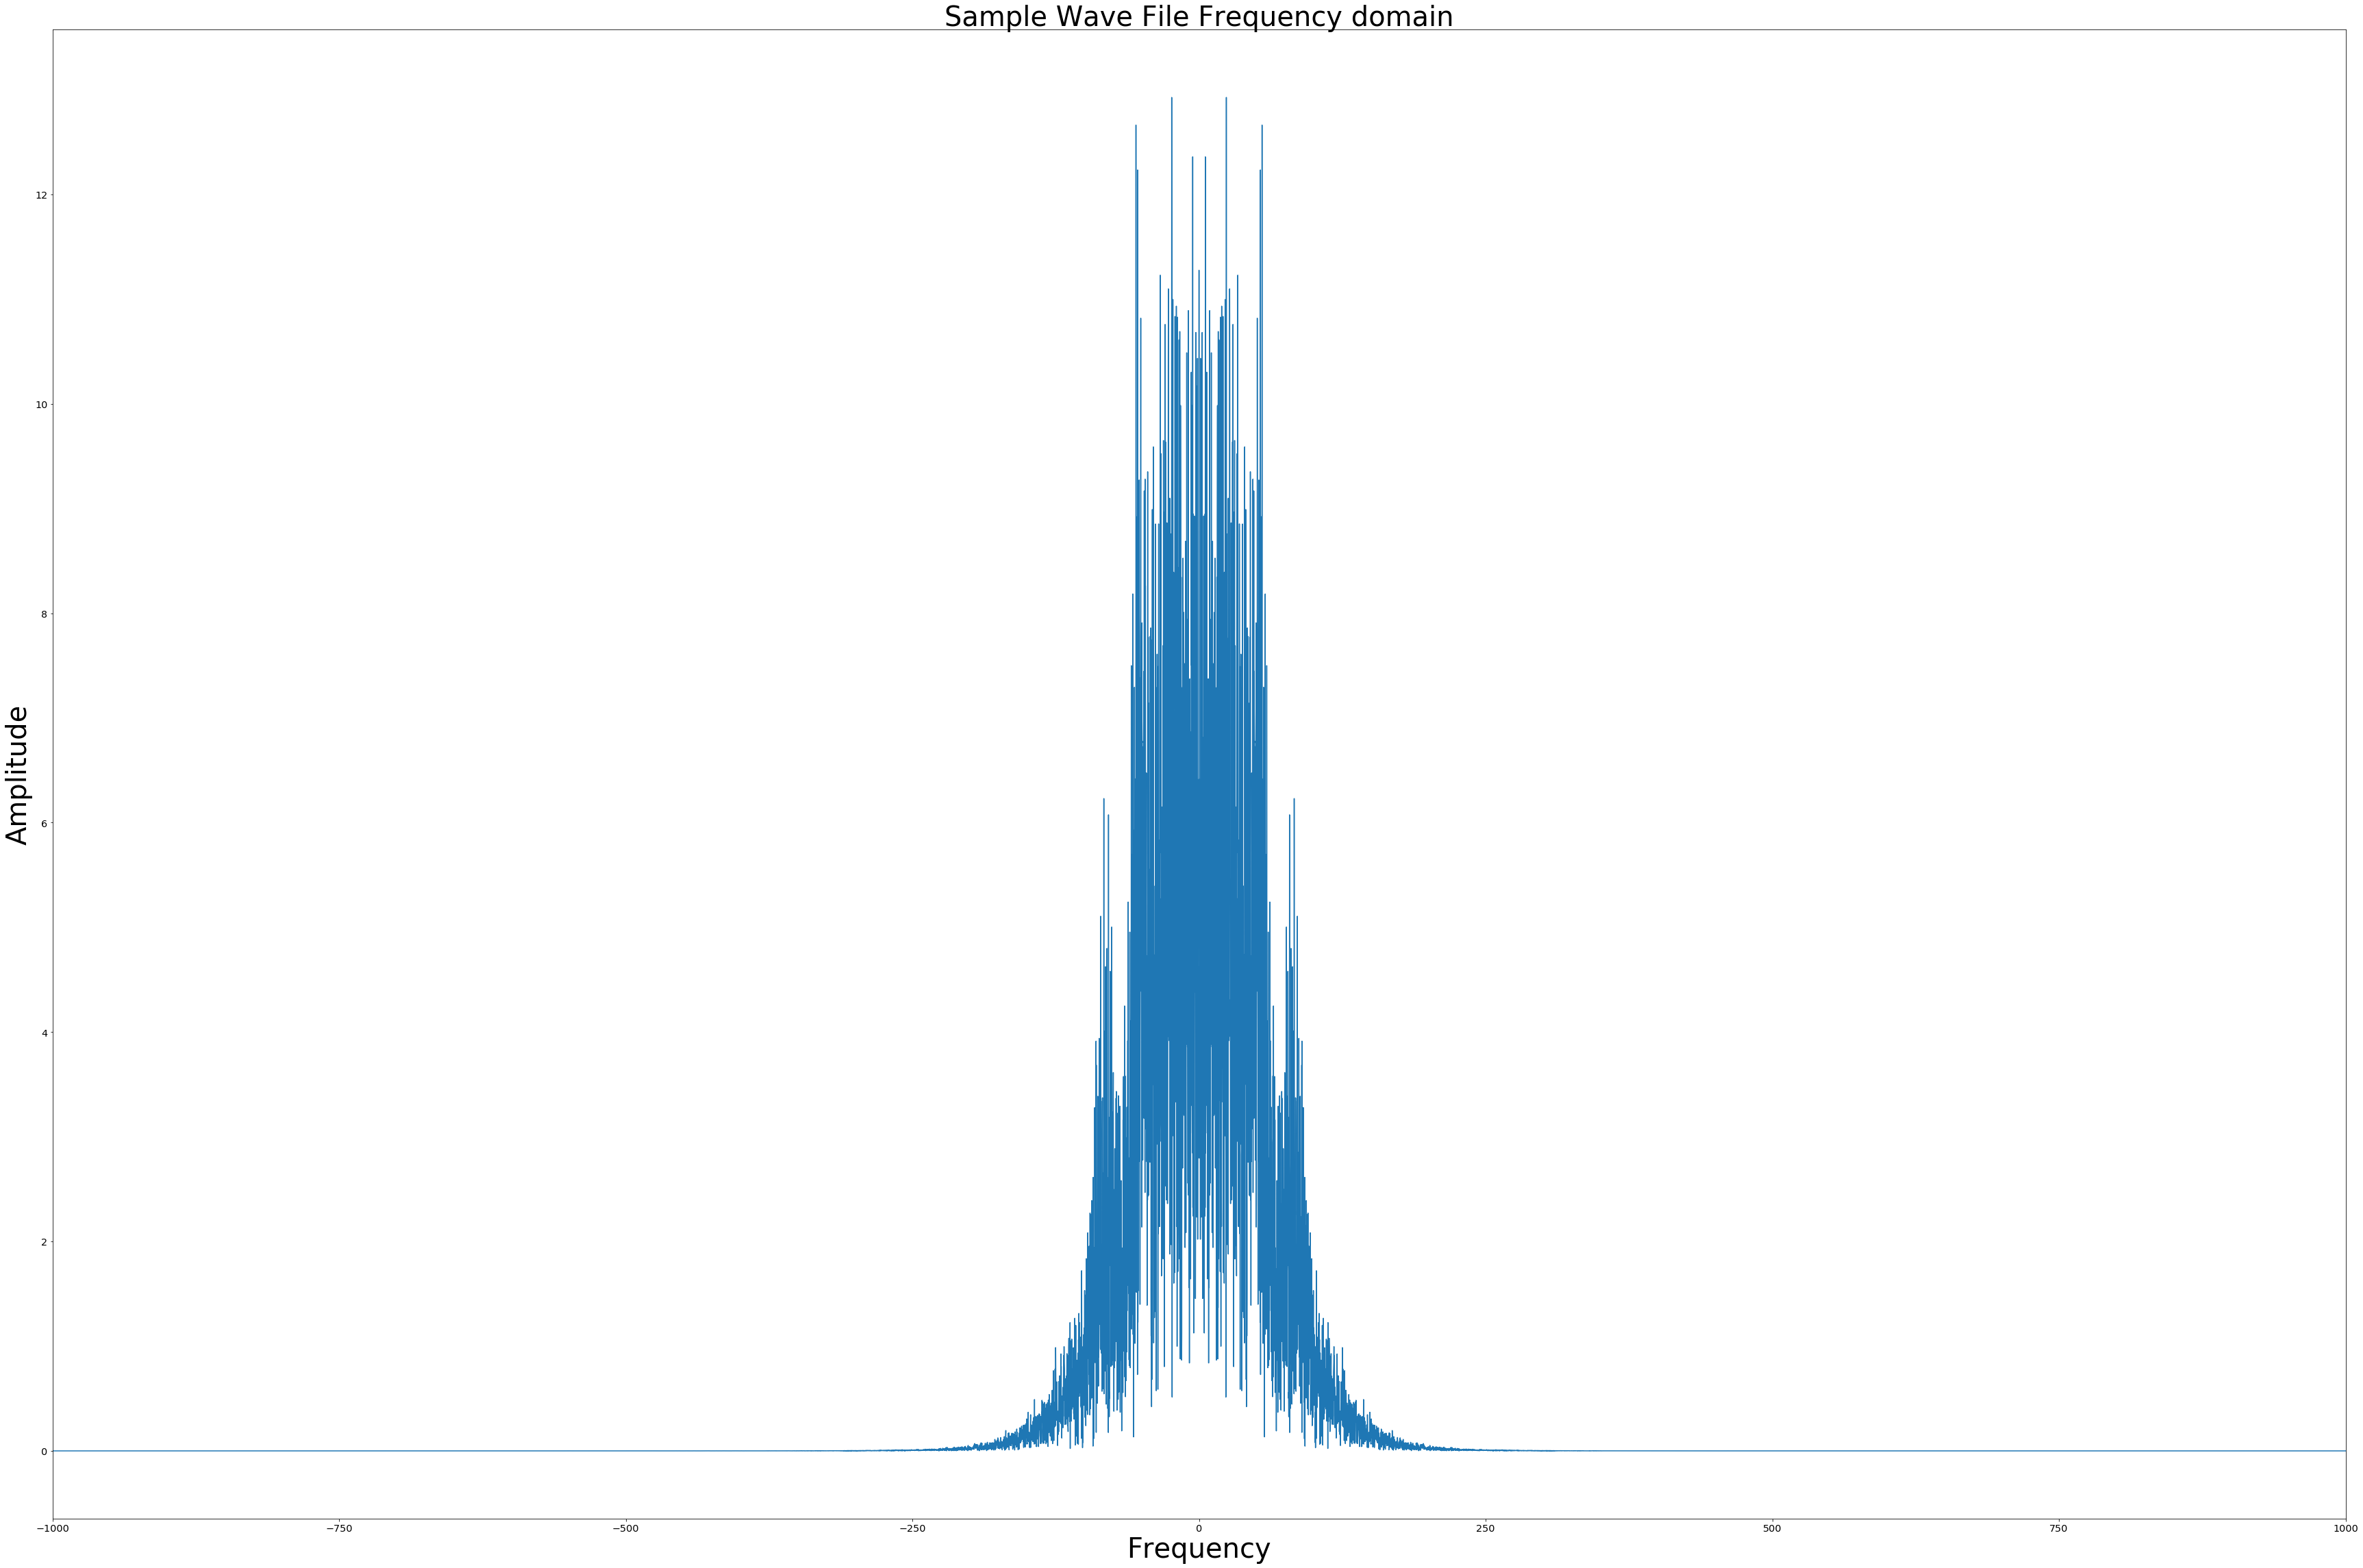

In [13]:
four_arr = get_fourier(sound_arr_noise_filtered, samplerate)

fig = plt.figure(figsize=(60, 40))
ax = plt.subplot(111)
ax.plot(
    four_arr.index,
    np.abs(four_arr.values)
)
plt.title('Sample Wave File Frequency domain', fontsize=40)
ax.set_xlabel('Frequency', fontsize=40)
ax.set_ylabel('Amplitude', fontsize=40)
ax.set_xlim([-1000, 1000])

_____________________

## Challenge 1: Classifying lub/dub signal ###

** This first challenge requires us to differentiate a lub (S1) sound for a dub (S2) sound. In addition there will be bacgkround noise in an audio file that is neither lub or dub **

The approach for this challenge was not linear. I decided to try and estimate a few features from the audio file that could potentially differentiate the sounds, but at each step I had to make some decisions of which was the best cutoff or value to use to generate a feature of interest. For example, how should the raw data be processed before accumulating features and using processed data for S1/S2 training. 

The following figure demonstrates the approach/flow

<img src='Model-flow-img.png'>


_____________________

## Stage A: Identifying features for S1/S2 classification ##


** The training data set: Dataset B **

As we only have a validation script for the digital stethoscope, we will only be using data from DatasetB for model formuation and evaluation. For Dataset B we have 200 digital sound files that can be used for training S1/S2 classification

*Training files*

The following is a list of the locations of normal heartbeat sounds recorded using a digital stethoscope

In [14]:
# List all files in dataset B
os.listdir('set_b/normal')

['normal__216_1308245839516_C.wav',
 'normal__190_1308076920011_D.wav',
 'normal__270_1309369533040_C.wav',
 'normal__170_1307970562729_A.wav',
 'normal__217_1308246111629_C.wav',
 'normal__274_1311075637574_A1.wav',
 'normal__153_1306848820671_D1.wav',
 'normal__128_1306344005749_B.wav',
 'normal__186_1308073648738_D.wav',
 'normal__107_1305654946865_C1.wav',
 'normal__154_1306935608852_A1.wav',
 'normal__286_1311170606028_C.wav',
 'normal__250_1309202496494_A.wav',
 'normal__167_1307111318050_C.wav',
 'normal__181_1308052613891_B.wav',
 'normal__174_1307987737137_B1.wav',
 'normal__103_1305031931979_D2.wav',
 'normal__208_1308159994503_C.wav',
 'normal__169_1307970398039_C.wav',
 'normal__209_1308162216750_A.wav',
 'normal__172_1307971284351_B.wav',
 'normal__170_1307970562729_C.wav',
 'normal__172_1307971284351_B1.wav',
 'normal__170_1307970562729_B.wav',
 'normal__127_1306764300147_C1.wav',
 'normal__214_1308245489717_A.wav',
 'normal__126_1306777102824_B.wav',
 'normal__106_130677

In [15]:
print('total files')
print(len(os.listdir('set_b/normal/')))

total files
200


*Sample rate*

The following illustrates the samplerate for the sound files in Dataset B

In [16]:
wav_list = []
for f in os.listdir('set_b/normal'):
    # load files
    sound_arr, samplerate = load_wav(os.path.join('set_b', 'normal', f))
    wav_list.append({'array': sound_arr, 'samplerate': samplerate})
wav_list_df = pd.DataFrame(wav_list)
wav_list_df['samplerate'].value_counts()

4000    200
Name: samplerate, dtype: int64

All 200 wav files have a sample rate of 4000 events per second

*Length of Files*

The following illlustrates the length of the sound files provided in Dataset B

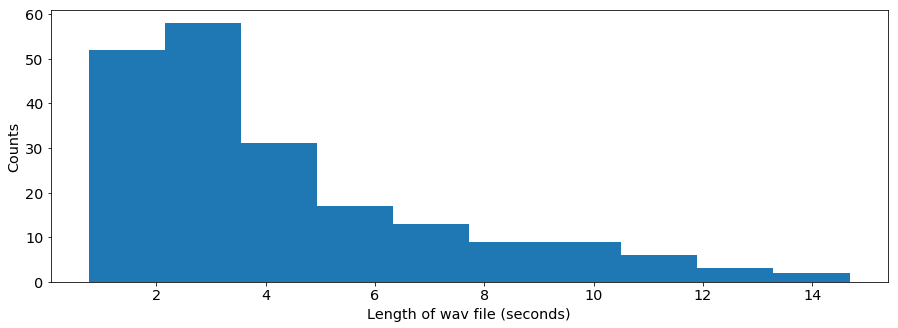

In [17]:
# plot the histgoram for the length of the audtio files, (because sample rate is 4000 for each one, divide length by 4000.0 to convert to seconds)
plt.hist(wav_list_df['array'].apply(lambda x: len(x)/4000.0))
plt.xlabel('Length of wav file (seconds)')
plt.ylabel('Counts')

*Sample of digital stethoscope audio files*

Lets quickly look at 10 sample audio files from the Dataset B

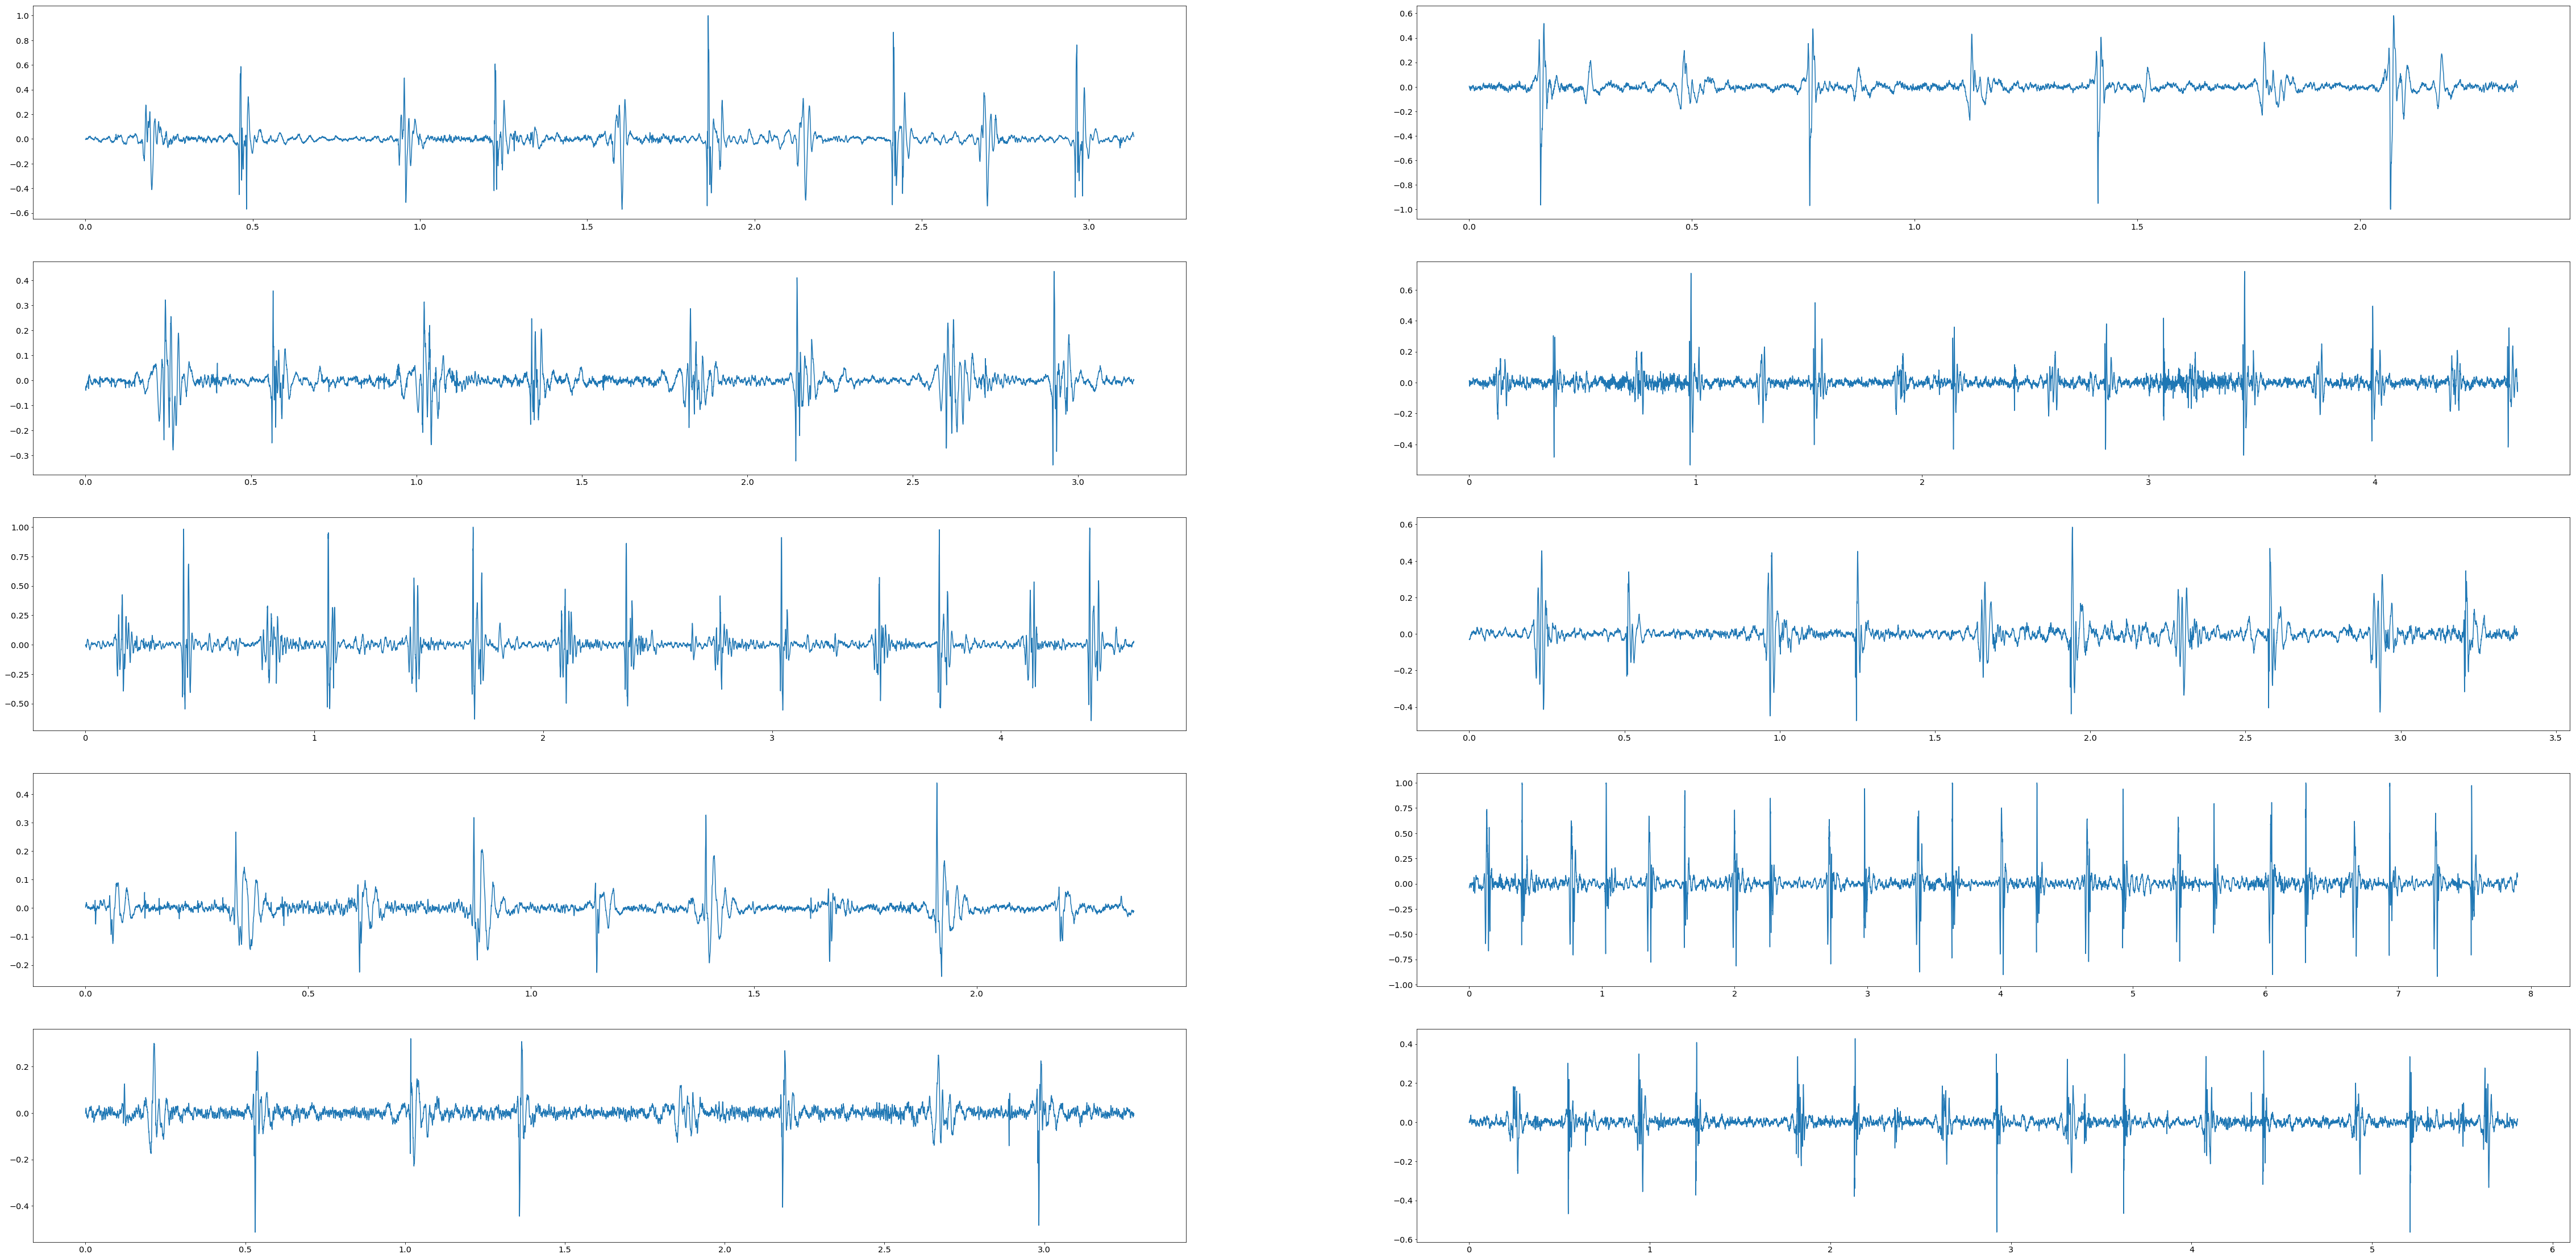

In [18]:
plt.figure(figsize=(80, 40))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    tmp = wav_list_df.iloc[i]['array']
    x = (1.0 * np.arange(1, (tmp.shape[0] + 1)))/4000.0 # divide frames by samplerate
    plt.plot(x, tmp)
    
    

** Identifying lub (S1)/ dub (S2) events **

The hearbeat sounds most likely occur at the peak positions/non-noisy areas in the signals above. However, in order to perform classification, we need to know exactly when the evnets occur, and more importantly, whether these events are lubs or dubs

This information (when S1/S2 events occur) are defined in the file "training_normal_seg" 

* Each row in the file represents a specific auto file which can be identified by its index
* Each column represents either an S1 or an S2 event. The value in each row/column (cell) represents the exact frame within the file that corresponds to either the S1 or S2 event

In [19]:
print('First ten lines of S1/S2 demarcation file')
training_sound_events = pd.read_csv('sample_data/Btraining_normal_seg.csv', sep=',', index_col=0)
training_sound_events.head(10)

First ten lines of S1/S2 demarcation file


S1    S2  S1.1  S2.1    S1.2    S2.2     S1.3  \
103_1305031931979_D1.aiff   430.0  1547  2406  3437  4468.0  5413.0   6358.0   
103_1305031931979_D3.aiff   481.0  1524  2486  3448  4491.0  5533.0   6576.0   
106_1306776721273_C1.aiff   831.0  2076  3987  5288  7835.0  9192.0  11102.0   
106_1306776721273_D1.aiff   393.0  1682  3256  4545  6096.0  7364.0   9921.0   
109_1305653646620_C.aiff    861.0  2186  4172  5497  7881.0  9206.0  11259.0   
113_1306244002866_D.aiff    457.0  1436  2578  3558  4700.0  5777.0   6723.0   
115_1306259437619_C.aiff    737.0  1877  3553  4827  7509.0  8649.0  10258.0   
117_1306262456650_B.aiff   1614.0  2652  3978  4958  6399.0  7322.0   8648.0   
125_1306332456645_B.aiff    627.0  1272  2204  2850  3764.0  4480.0   5377.0   
126_1306777102824_D.aiff   1063.0  2354  3720  5011  7137.0  8504.0  10782.0   

                              S2.3     S1.4     S2.4  ...    S1.25  S2.25  \
103_1305031931979_D1.aiff   7389.0   8420.0   9451.0  ...      NaN    NaN   
103_1305031931979_D3.aiff   7619.0   8581.0   9623.0  ...      NaN    NaN   
106_1306776721273_C1.aiff  12375.0      NaN      NaN  ...      NaN    NaN   
106_1306776721273_D1.aiff      NaN      NaN      NaN  ...      NaN    NaN   
109_1305653646620_C.aiff   12583.0  14305.0  15299.0  ...      NaN    NaN   
113_1306244002866_D.aiff    7768.0   8747.0   9726.0  ...      NaN    NaN   
115_1306259437619_C.aiff   11397.0  13208.0  14414.0  ...      NaN    NaN   
117_1306262456650_B.aiff    9570.0  10896.0  11876.0  ...      NaN    NaN   
125_1306332456645_B.aiff    6093.0   6990.0   7724.0  ...      NaN    NaN   
126_1306777102824_D.aiff   11845.0  13439.0  14806.0  ...      NaN    NaN   

                           S1.26  S2.26  S1.27  S2.27  S1.28  S2.28  S1.29  \
103_1305031931979_D1.aiff    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
103_1305031931979_D3.aiff    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
106_1306776721273_C1.aiff    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
106_1306776721273_D1.aiff    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
109_1305653646620_C.aiff     NaN    NaN    NaN    NaN    NaN    NaN    NaN   
113_1306244002866_D.aiff     NaN    NaN    NaN    NaN    NaN    NaN    NaN   
115_1306259437619_C.aiff     NaN    NaN    NaN    NaN    NaN    NaN    NaN   
117_1306262456650_B.aiff     NaN    NaN    NaN    NaN    NaN    NaN    NaN   
125_1306332456645_B.aiff     NaN    NaN    NaN    NaN    NaN    NaN    NaN   
126_1306777102824_D.aiff     NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                           S2.29  
103_1305031931979_D1.aiff    NaN  
103_1305031931979_D3.aiff    NaN  
106_1306776721273_C1.aiff    NaN  
106_1306776721273_D1.aiff    NaN  
109_1305653646620_C.aiff     NaN  
113_1306244002866_D.aiff     NaN  
115_1306259437619_C.aiff     NaN  
117_1306262456650_B.aiff     NaN  
125_1306332456645_B.aiff     NaN  
126_1306777102824_D.aiff     NaN  

[10 rows x 60 columns]

Consider the first row in the segmentation file shown above: Wav filename - 103_1305031931979_D1

In [20]:
sample_file_S1_S2_demarcation = training_sound_events.loc['103_1305031931979_D1.aiff'].dropna()
sample_file_S1_S2_demarcation

S1         430.0
S2        1547.0
S1.1      2406.0
S2.1      3437.0
S1.2      4468.0
S2.2      5413.0
S1.3      6358.0
S2.3      7389.0
S1.4      8420.0
S2.4      9451.0
S1.5     10482.0
S2.5     11514.0
S1.6     12545.0
S2.6     13576.0
S1.7     14607.0
S2.7     15552.0
S1.8     16583.0
S2.8     17614.0
S1.9     18559.0
S2.9     19590.0
S1.10    20707.0
S2.10    21738.0
S1.11    22769.0
S2.11    23800.0
S1.12    24746.0
S2.12    25777.0
S1.13    26722.0
S2.13    27753.0
S1.14    28784.0
S2.14    29815.0
S1.15    30760.0
S2.15    31791.0
S1.16    32822.0
S2.16    33853.0
S1.17    34798.0
S2.17    35915.0
S1.18    36860.0
S2.18    37892.0
S1.19    38837.0
Name: 103_1305031931979_D1.aiff, dtype: float64

There are 18 pairs of S1/S2 events + an extra S1 sound at the end.

** *What does it look like when the S1/S2 events are plotted along with the sound file?* **

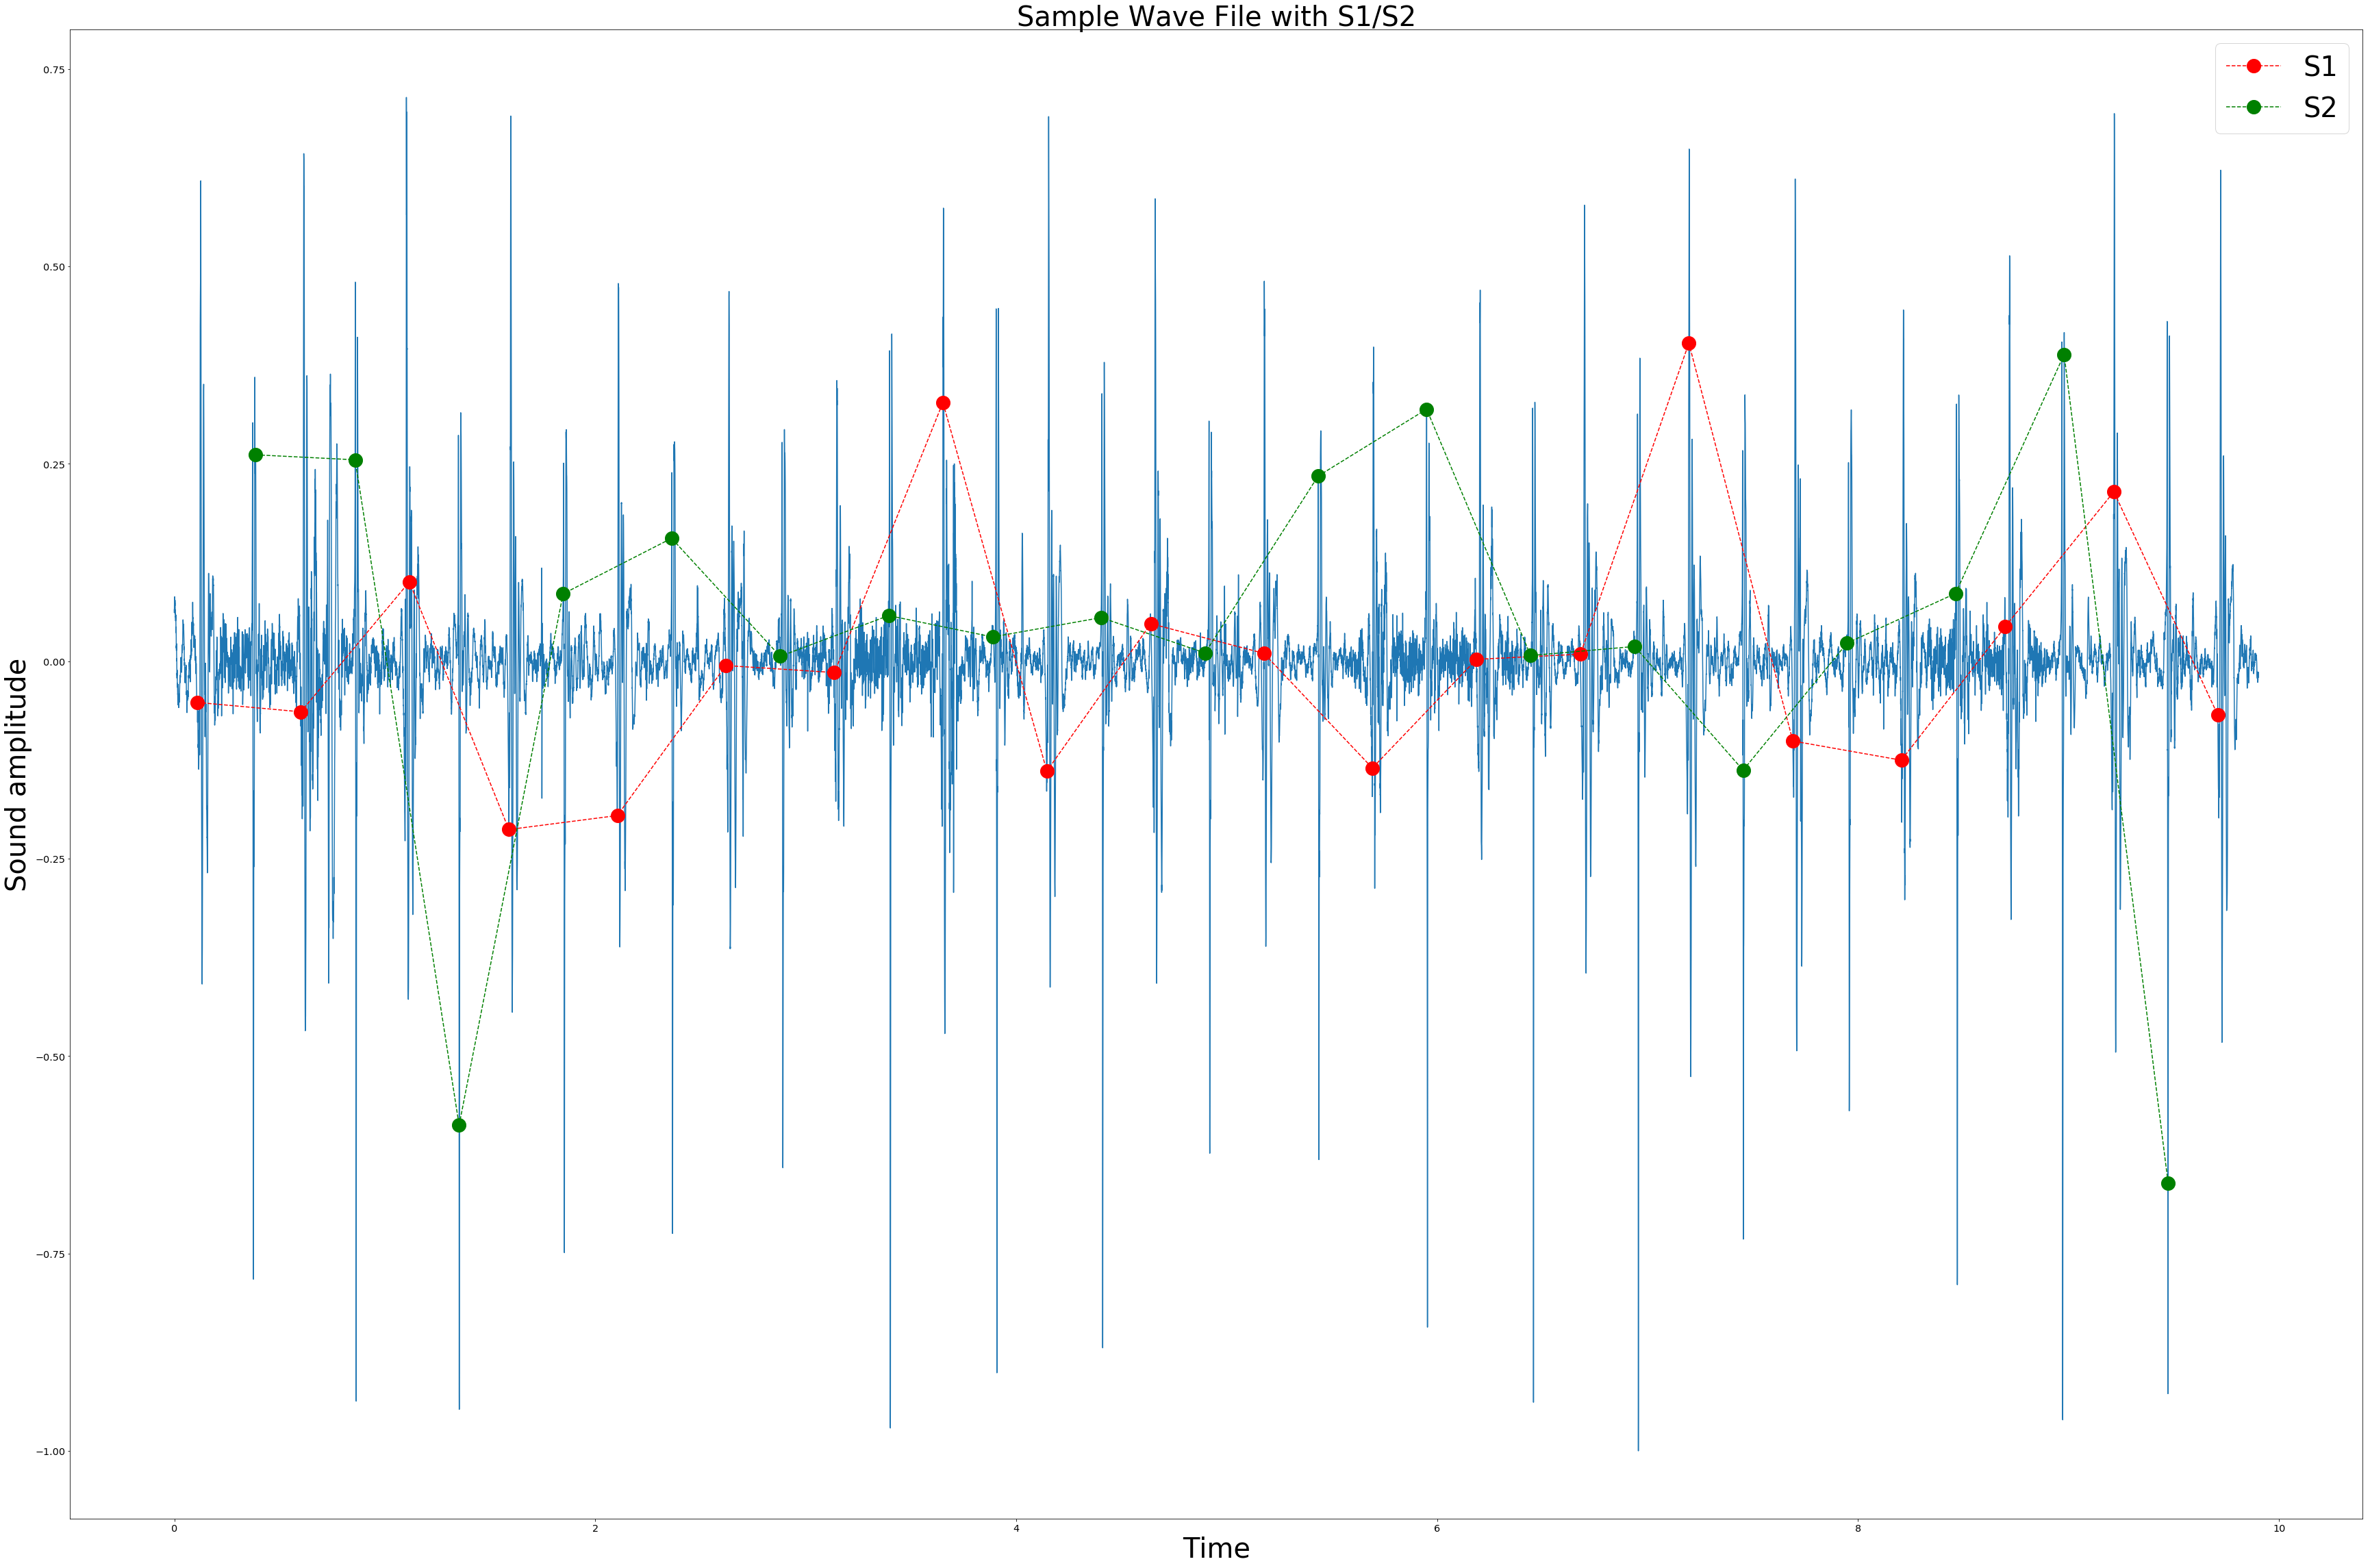

In [21]:
# load raw data
wav_file_name = os.path.join('set_b', 'normal', 'normal__103_1305031931979_D1.wav')
sound_arr, samplerate = load_wav(wav_file_name)

# Using the demaracation results group together rows that are S1 (S1.1, S1.2, S1.3) and rows that are S2 (S2.1, S2.2, S2.3...) 
S1_S2_groups = sample_file_S1_S2_demarcation.groupby(by=lambda x: x.split('.')[0]).groups
s1_ind = sample_file_S1_S2_demarcation.loc[S1_S2_groups['S1']].astype(int)  # these are the positions within the raw datafile where S1 events occur
s2_ind = sample_file_S1_S2_demarcation.loc[S1_S2_groups['S2']].astype(int)  # these are the positions within the raw datafile where S2 events occur

# isolate the amplitudes where S1 events occur
s1_amplitude = sound_arr[s1_ind]
s2_amplitude = sound_arr[s2_ind]

fig = plt.figure(figsize=(60, 40))
ax = plt.subplot(111)
# plot raw data
ax.plot(
    np.arange(sound_arr.shape[0])/(4000.0),
    sound_arr
)
# plot S1 as markers
ax.plot(
    s1_ind/(1.0 * 4000),
    s1_amplitude,
    'o--r',
    label='S1',
    markersize=20,
)

#plot S2 as markers
ax.plot(
    s2_ind/(1.0 * 4000),
    s2_amplitude,
    'o--g',
    label='S2',
    markersize=20,
)
plt.legend(fontsize=40)
plt.title('Sample Wave File with S1/S2', fontsize=40)
ax.set_xlabel('Time', fontsize=40)
ax.set_ylabel('Sound amplitude', fontsize=40)

### 1. Potential feature: signal amplitude at S1 or S2 ###

From the plot above we can see how the heartbeat occurs as expected: We hear a "lub(S1)" and then a "dub(S2)".  Both signals look similar and are characterized near peaks/spikes that raise then drop. 

Maybe we can look at the amplitude of the signal to see if there is any difference between S1/S2 events

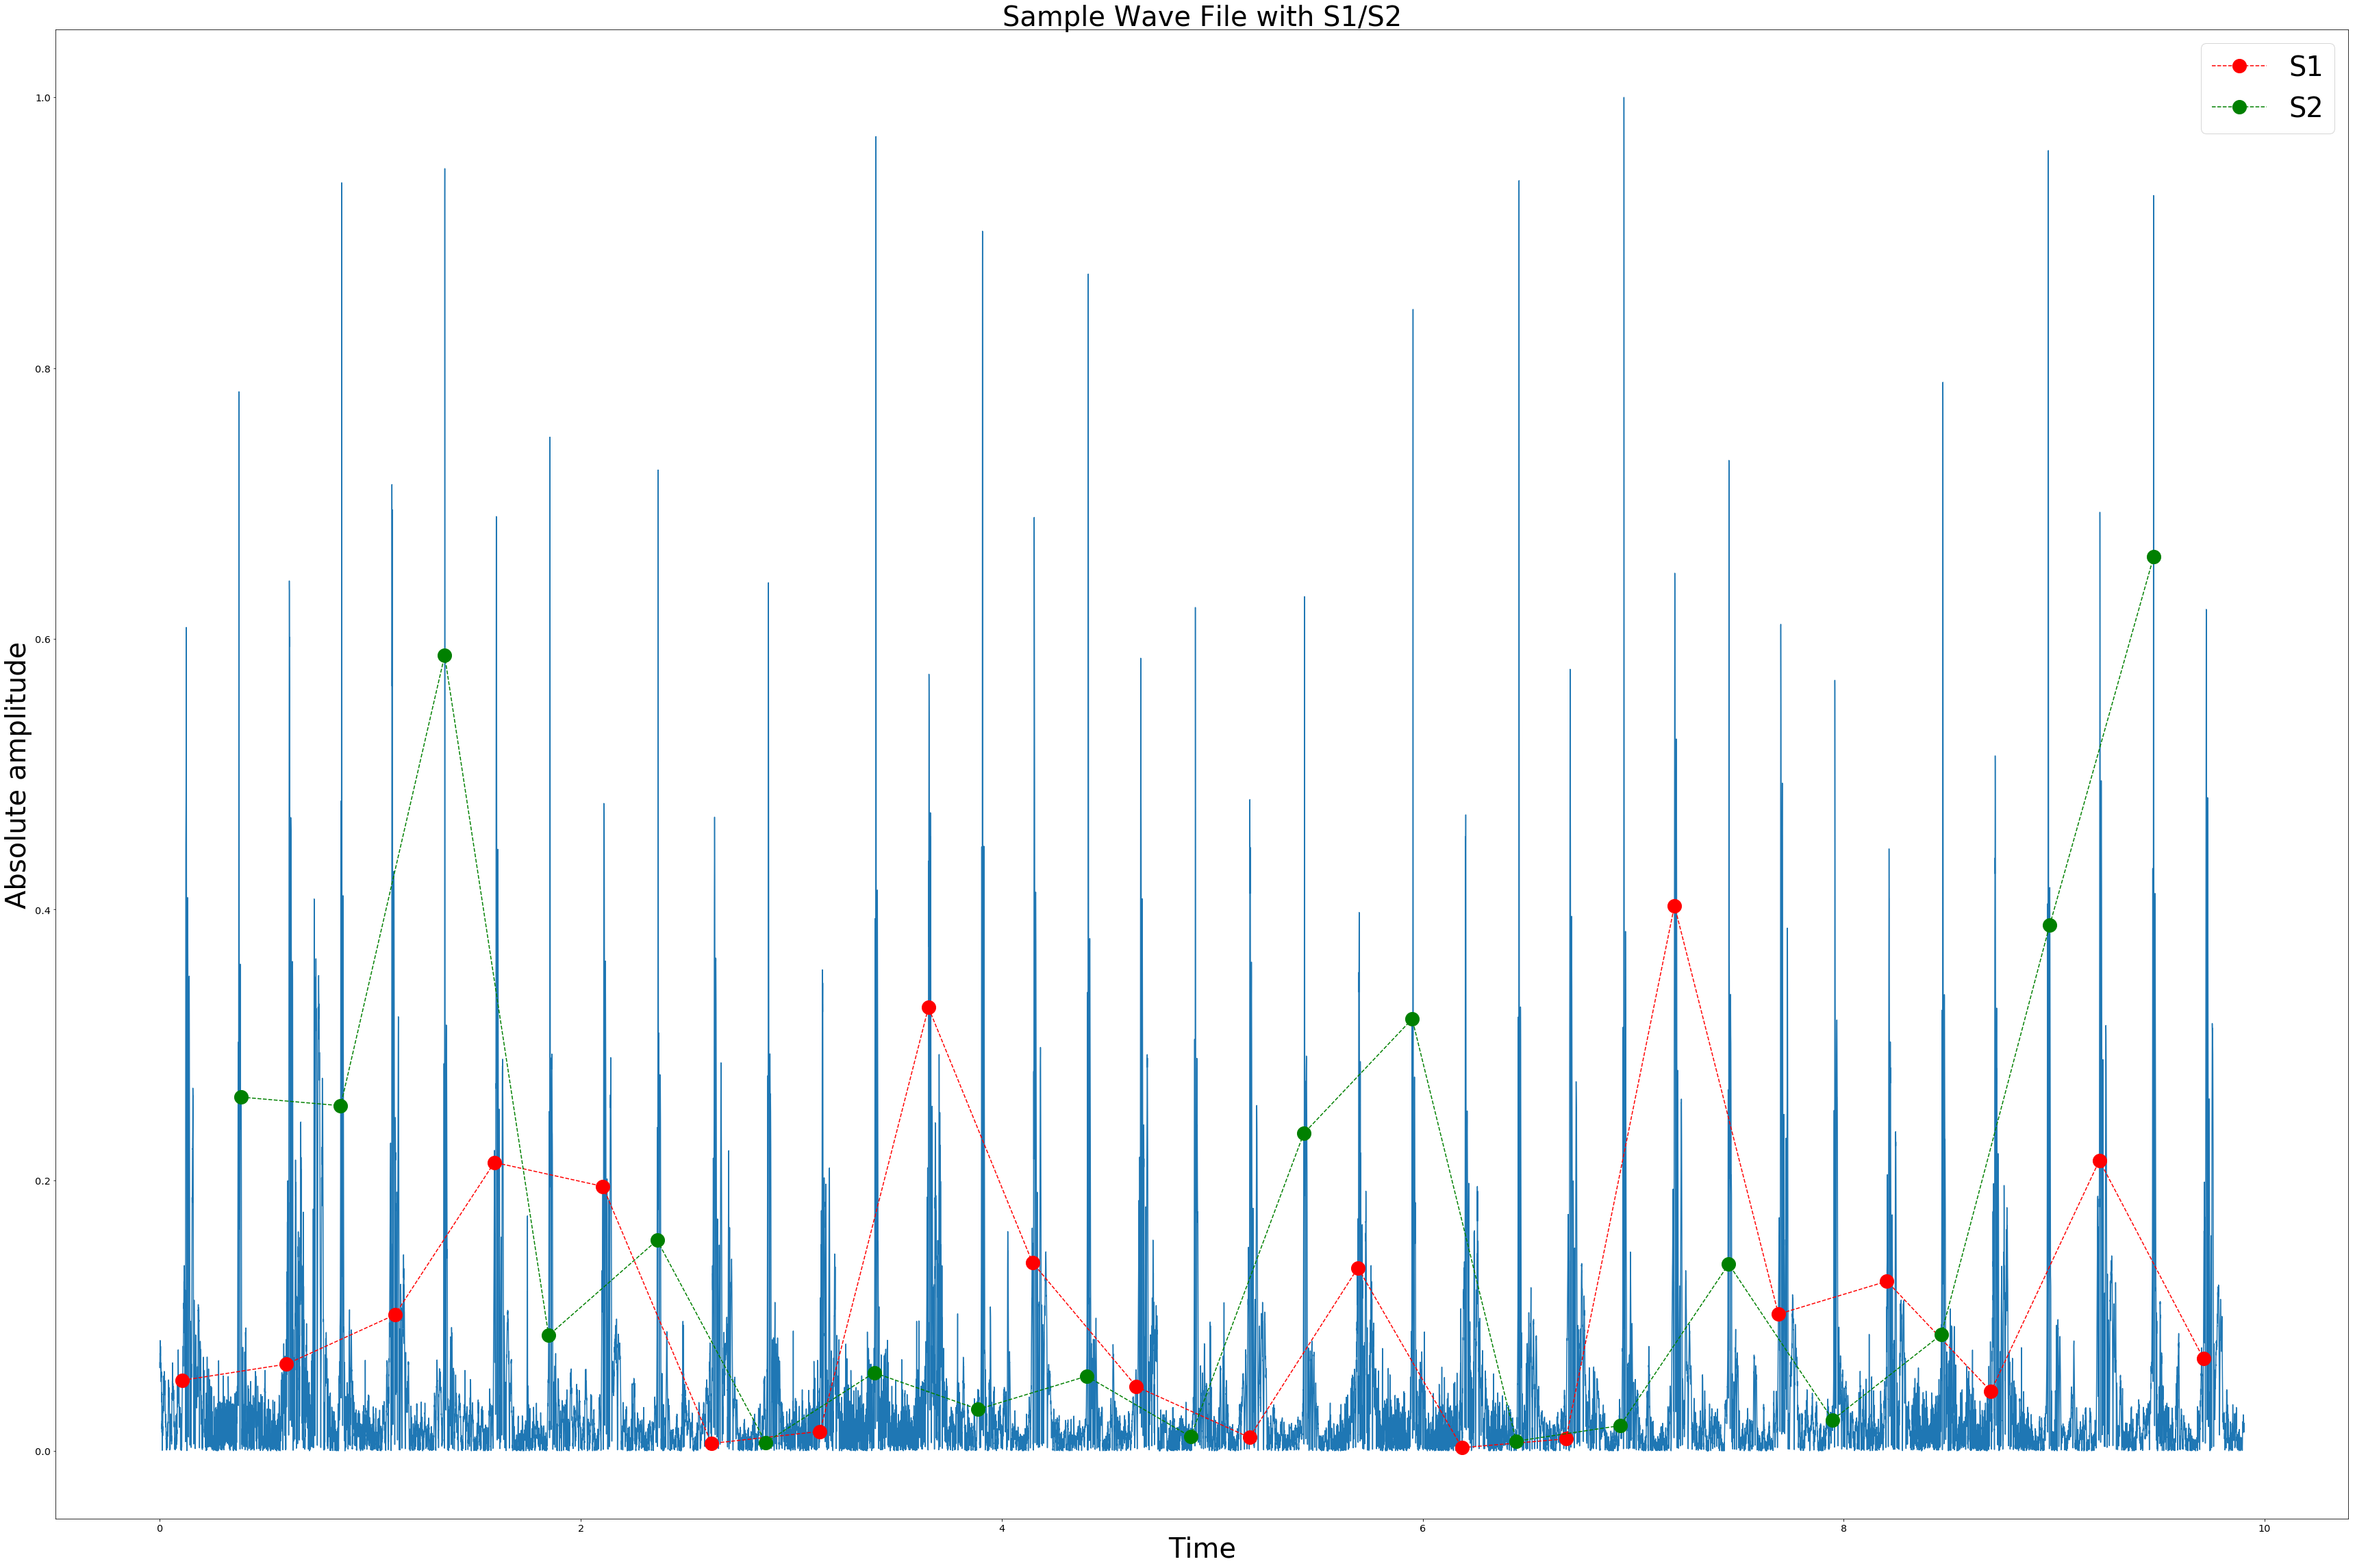

In [22]:
# group rows by S2 (S2.1, S2.2, S2.3..) / S1 (S1.1, S1.2, S1.3)
S1_S2_groups = sample_file_S1_S2_demarcation.groupby(by=lambda x: x.split('.')[0]).groups
s1_ind = sample_file_S1_S2_demarcation.loc[S1_S2_groups['S1']].astype(int)
s2_ind = sample_file_S1_S2_demarcation.loc[S1_S2_groups['S2']].astype(int)
s1_amplitude = sound_arr[s1_ind]
s2_amplitude = sound_arr[s2_ind]

fig = plt.figure(figsize=(60, 40))
ax = plt.subplot(111)
ax.plot(
    np.arange(sound_arr.shape[0])/(1.0 * 4000),
    np.abs(sound_arr)
)
ax.plot(
    s1_ind/(1.0 * 4000),
    np.abs(s1_amplitude),
    'o--r',
    label='S1',
    markersize=20,
)
ax.plot(
    s2_ind/(1.0 * 4000),
    np.abs(s2_amplitude),
    'o--g',
    label='S2',
    markersize=20,
)
plt.legend(fontsize=40)
plt.title('Sample Wave File with S1/S2', fontsize=40)
ax.set_xlabel('Time', fontsize=40)
ax.set_ylabel('Absolute amplitude', fontsize=40)

Absolute value of the amplitudes seem to suggest that there are differeinces in peaks between S1 and S2 values. But an issue is that these S1/S2 points are 'near' the local maximums but are not the actual local maximas. So it might be more intuitive to look at all nearby amplitudes within a **window size** in an effort to capture the local maximas

(0.0, 0.25)

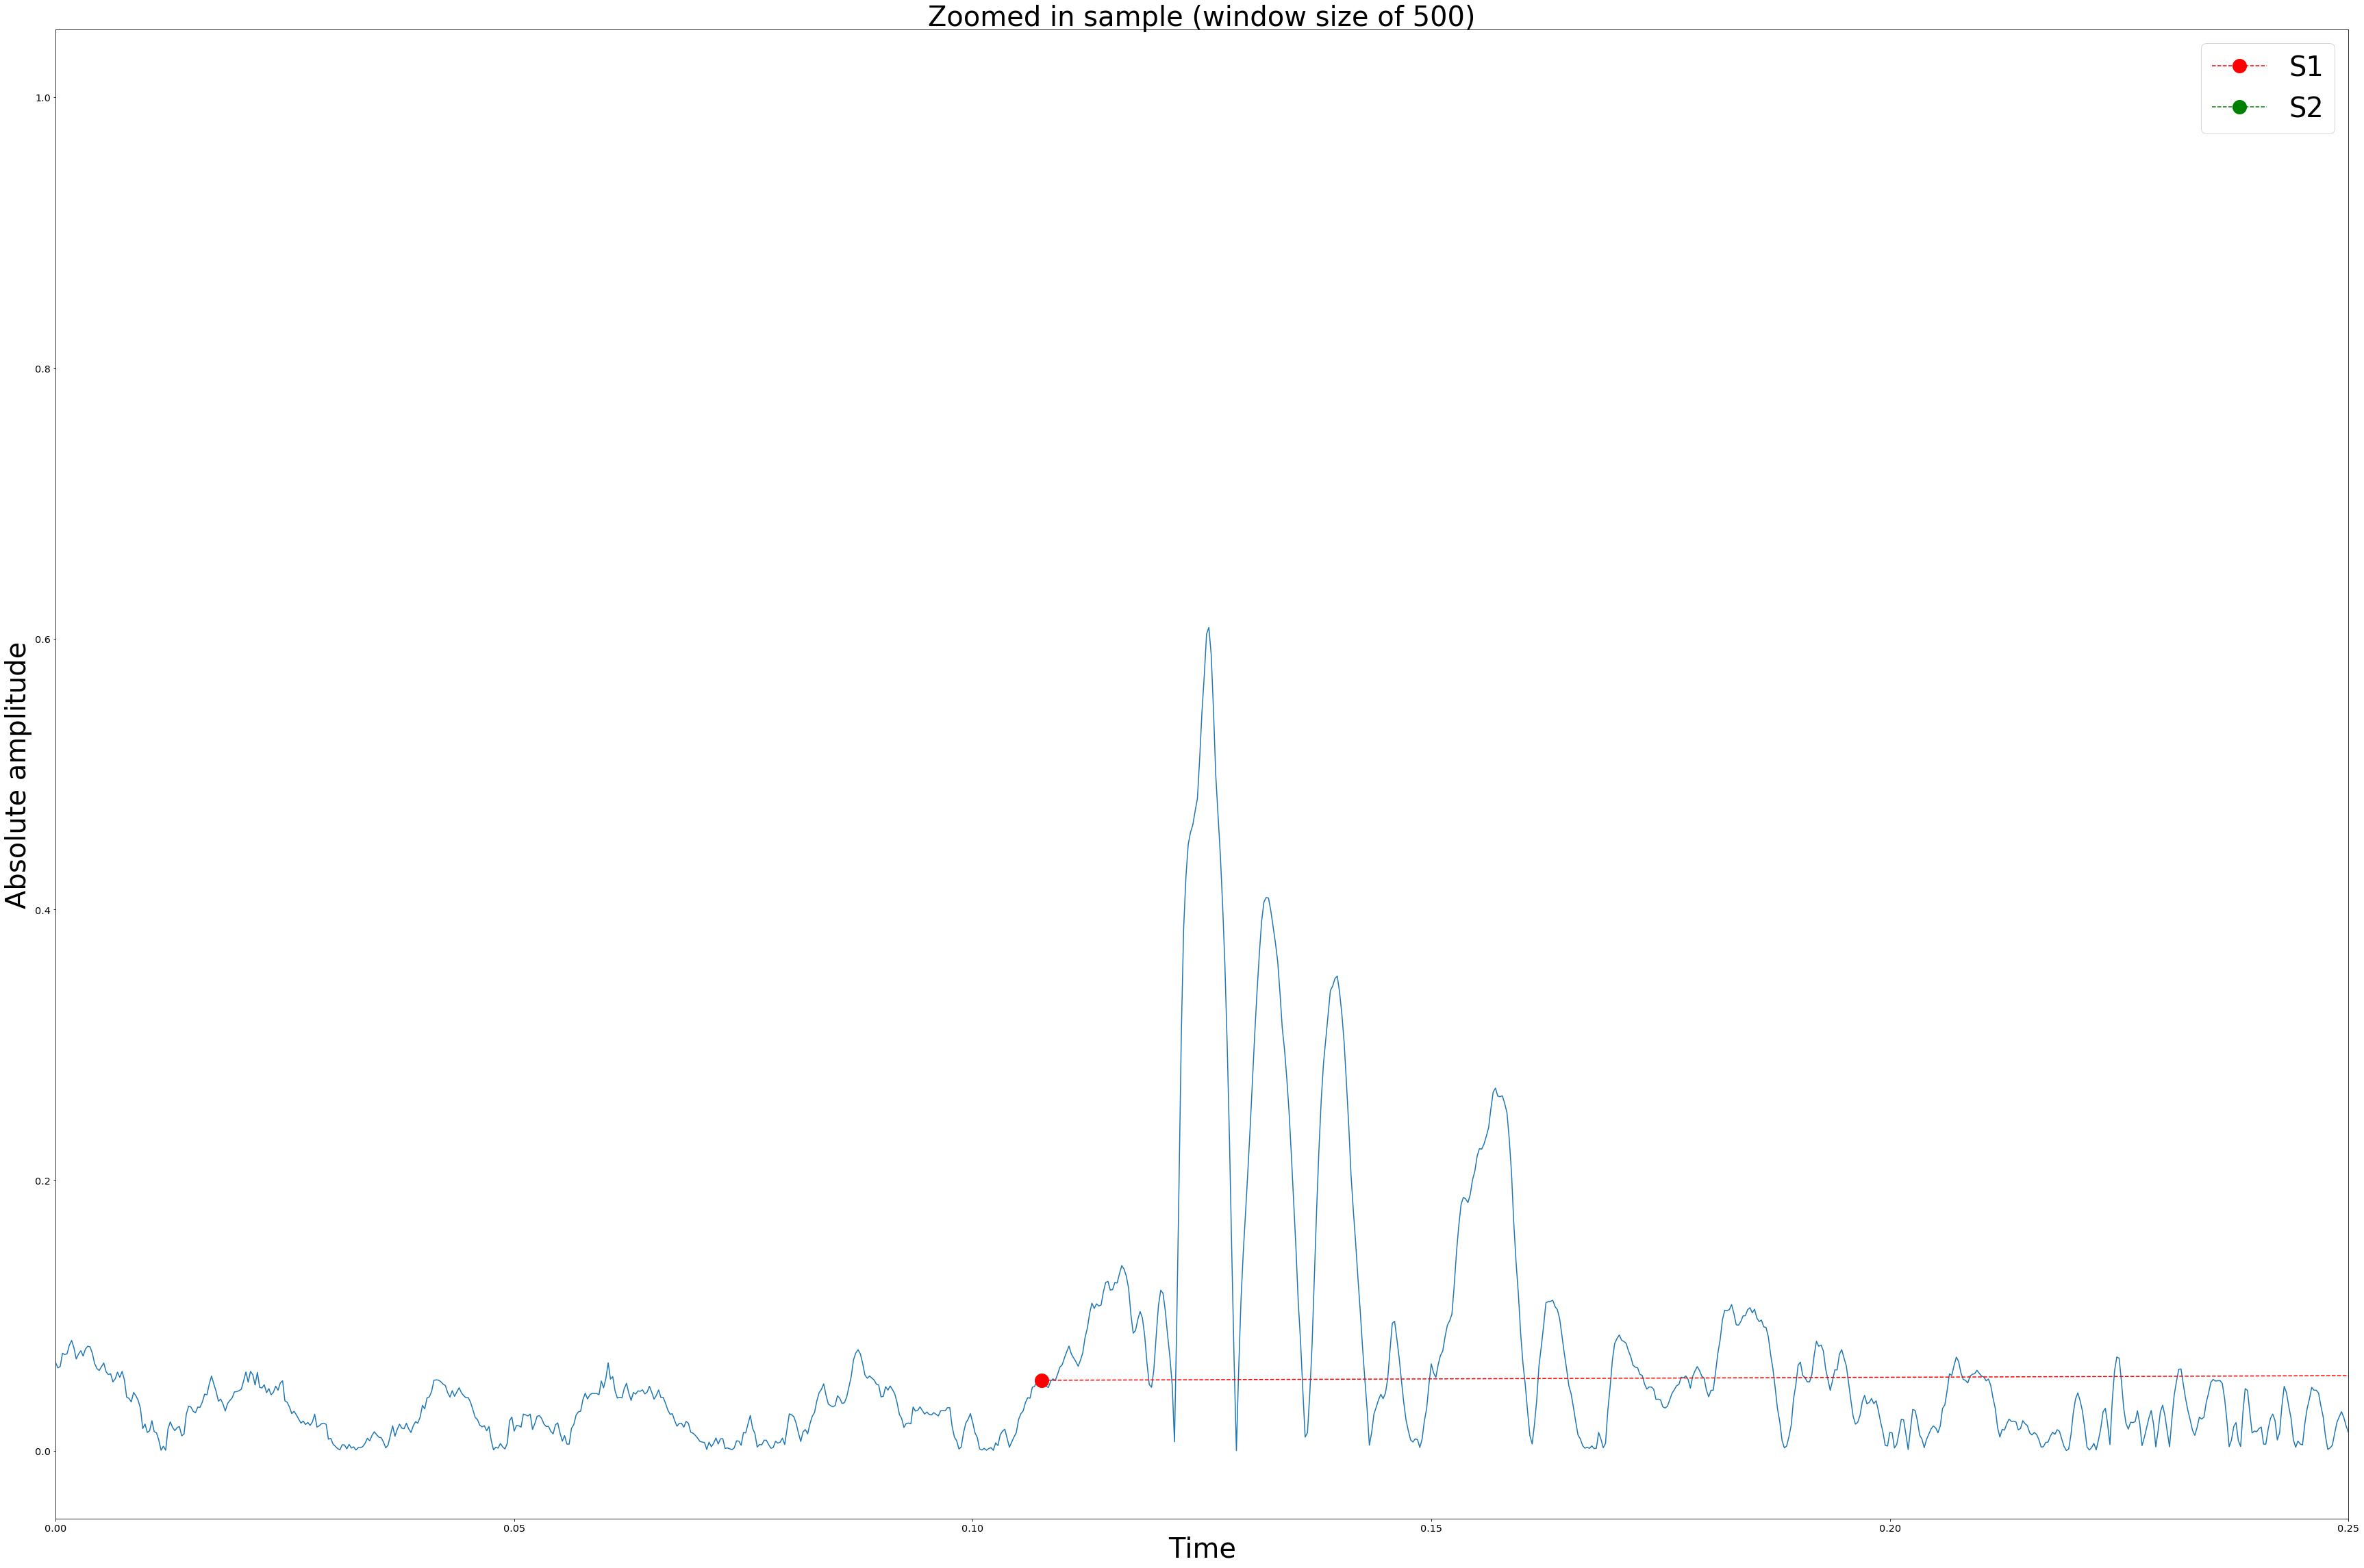

In [23]:
window=500

fig = plt.figure(figsize=(60, 40))
ax = plt.subplot(111)
ax.plot(
    np.arange(sound_arr.shape[0])/(1.0 * 4000),
    np.abs(sound_arr)
)
ax.plot(
    s1_ind/(1.0 * 4000),
    np.abs(s1_amplitude),
    'o--r',
    label='S1',
    markersize=20,
)
ax.plot(
    s2_ind/(1.0 * 4000),
    np.abs(s2_amplitude),
    'o--g',
    label='S2',
    markersize=20,
)
plt.legend(fontsize=40)
plt.title('Zoomed in sample (window size of {0})'.format(window), fontsize=40)
ax.set_xlabel('Time', fontsize=40)
ax.set_ylabel('Absolute amplitude', fontsize=40)
ax.set_xlim([(0)/(1.0*samplerate), (0 + 2 * window)/(1.0*samplerate)])

Lets consider the "sum" of all amplitudes within a window size of 500

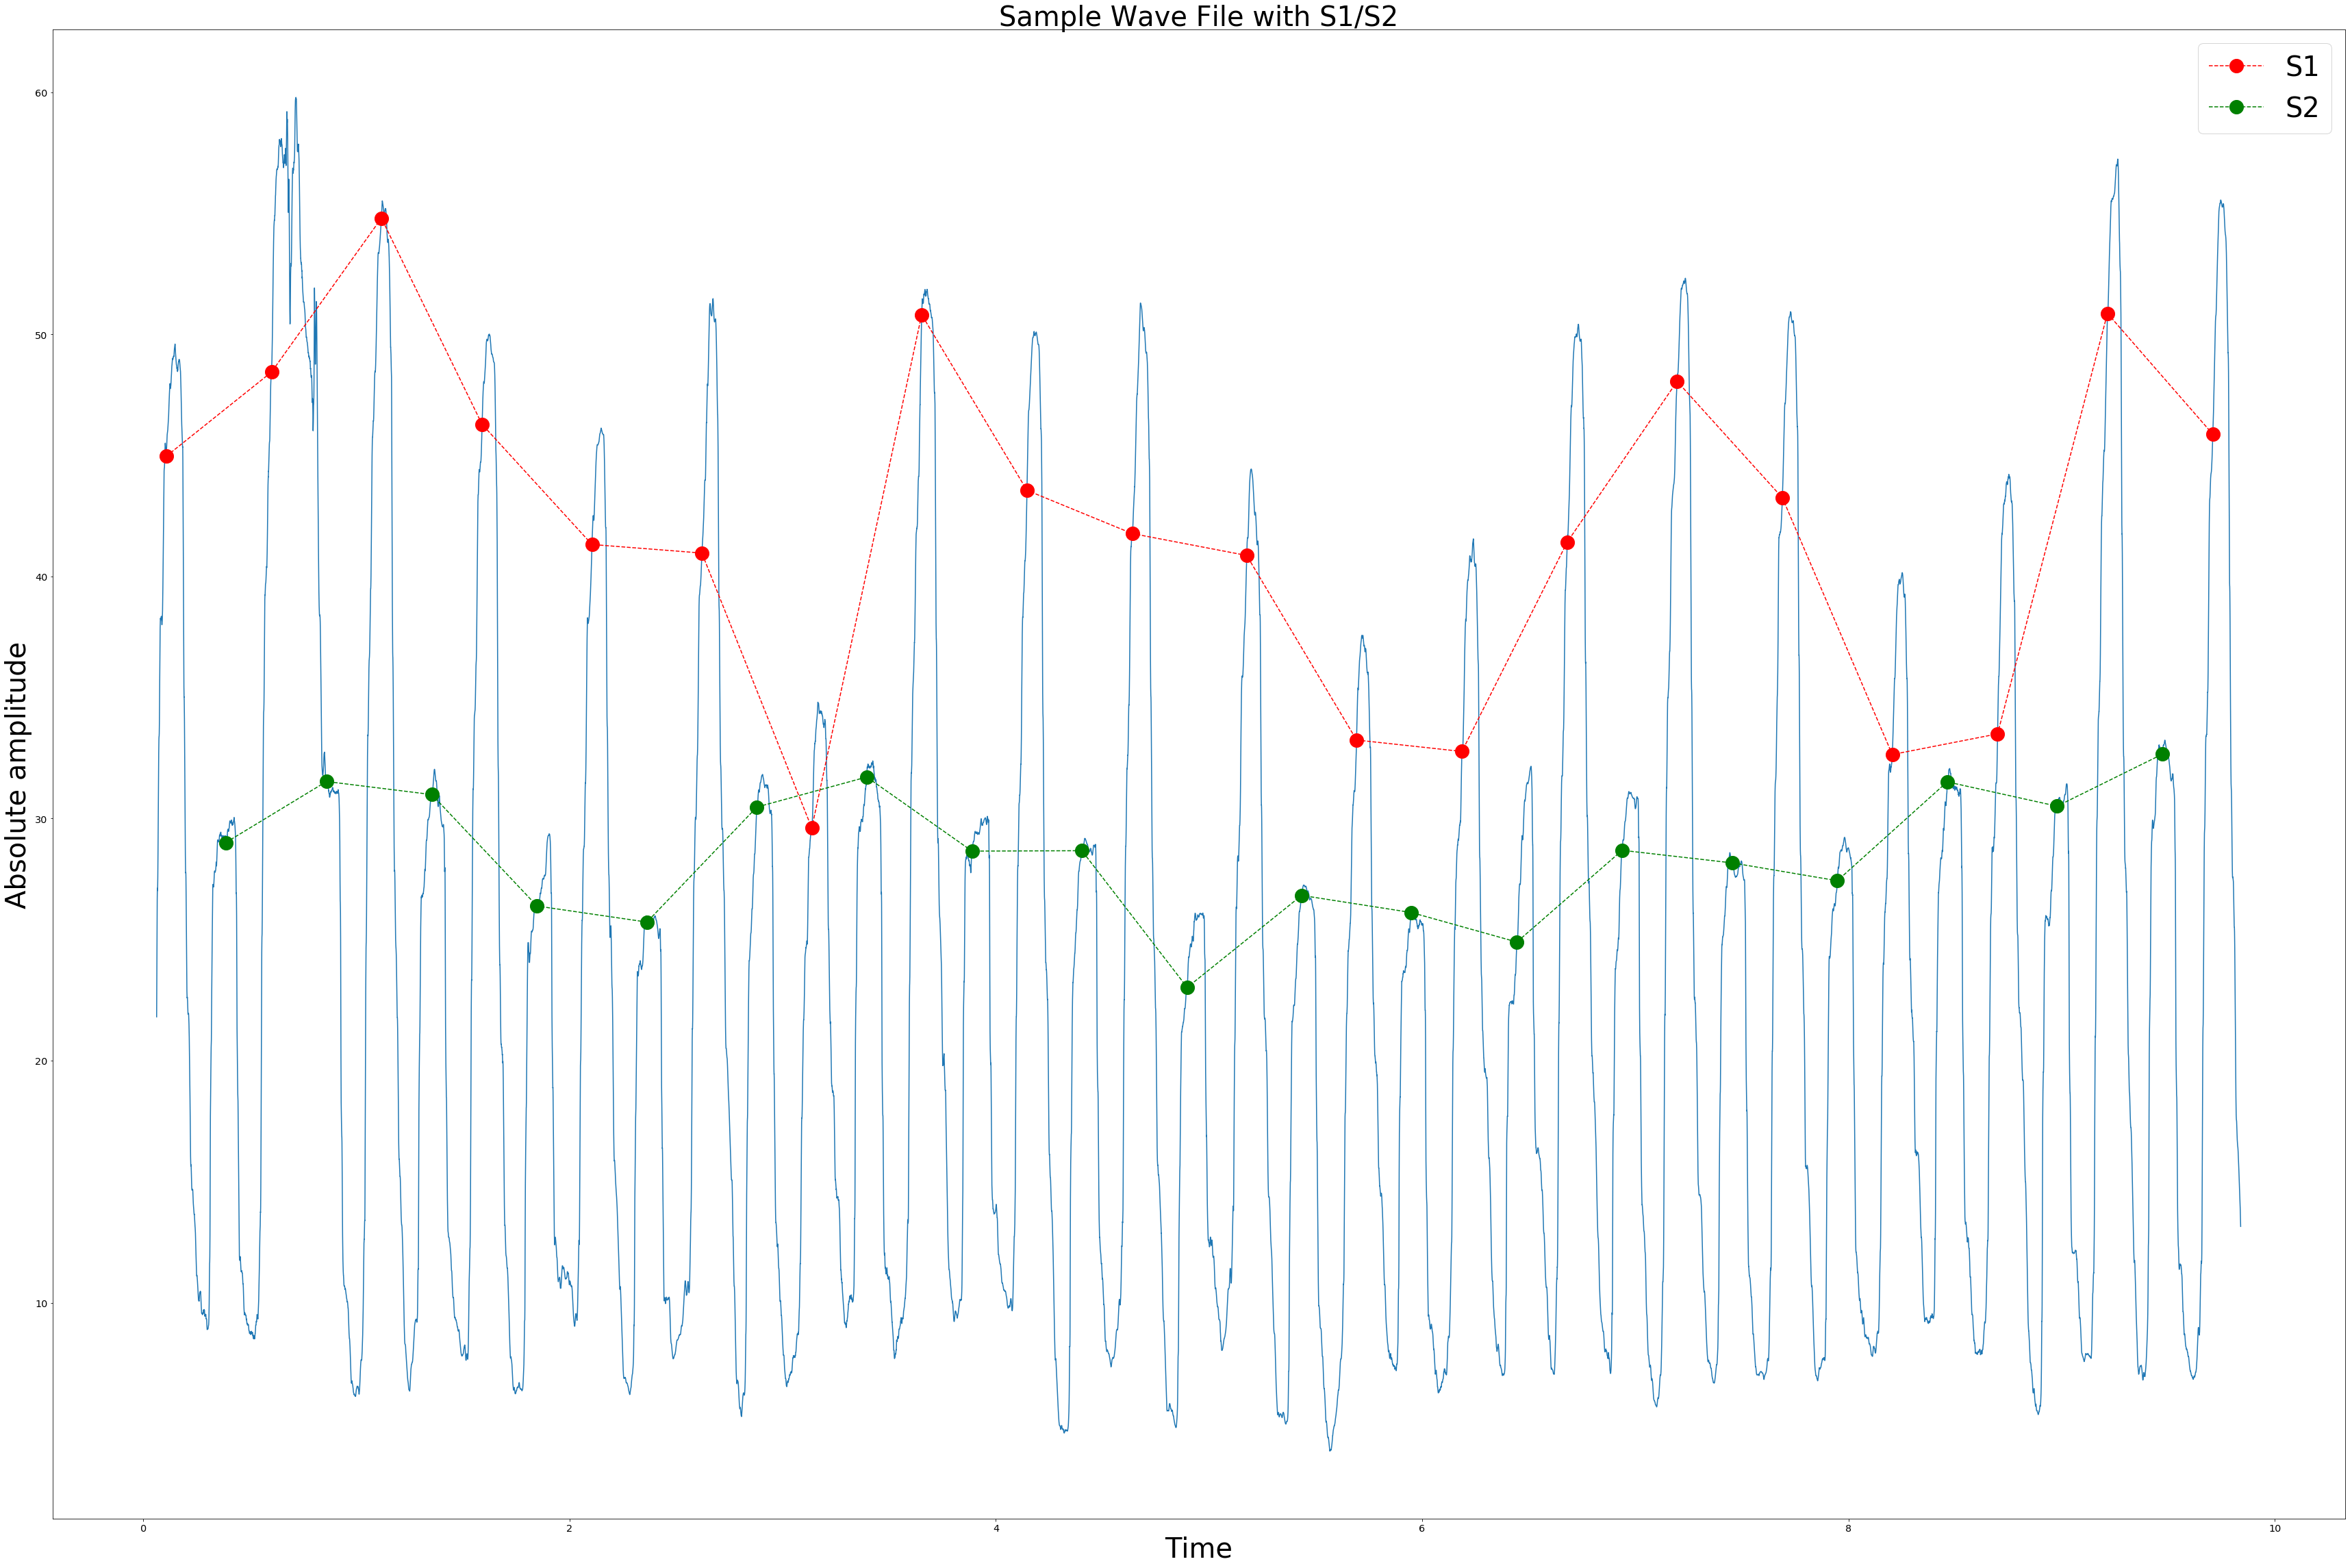

In [24]:
window = 500

binned_sounds = np.abs(pd.Series(sound_arr)).rolling(window=window, center=True).apply(lambda x: x.sum())

s1_amplitude = binned_sounds[s1_ind]
s2_amplitude = binned_sounds[s2_ind]

fig = plt.figure(figsize=(60, 40))
ax = plt.subplot(111)
ax.plot(
    np.arange(binned_sounds.shape[0])/(1.0 * 4000),
    np.abs(binned_sounds)
)
ax.plot(
    s1_ind/(1.0 * 4000),
    np.abs(s1_amplitude),
    'o--r',
    label='S1',
    markersize=20,
)
ax.plot(
    s2_ind/(1.0 * 4000),
    np.abs(s2_amplitude),
    'o--g',
    label='S2',
    markersize=20,
)
plt.legend(fontsize=40)
plt.title('Sample Wave File with S1/S2', fontsize=40)
ax.set_xlabel('Time', fontsize=40)
ax.set_ylabel('Absolute amplitude', fontsize=40)

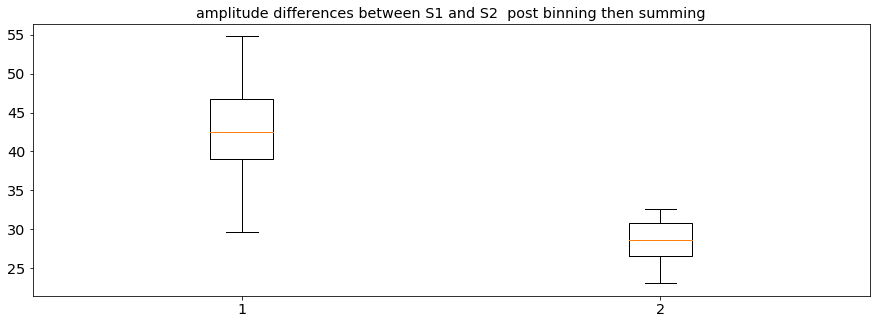

In [25]:
plt.boxplot(
    [s1_amplitude.dropna().values,   s2_amplitude.dropna().values]
)
plt.title('amplitude differences between S1 and S2  post binning then summing')

** N of 1 .... **

Binning then summing seems to show differences between S1/S2 in this *SPECIFIC* audio file. What if we considered 10 more files 

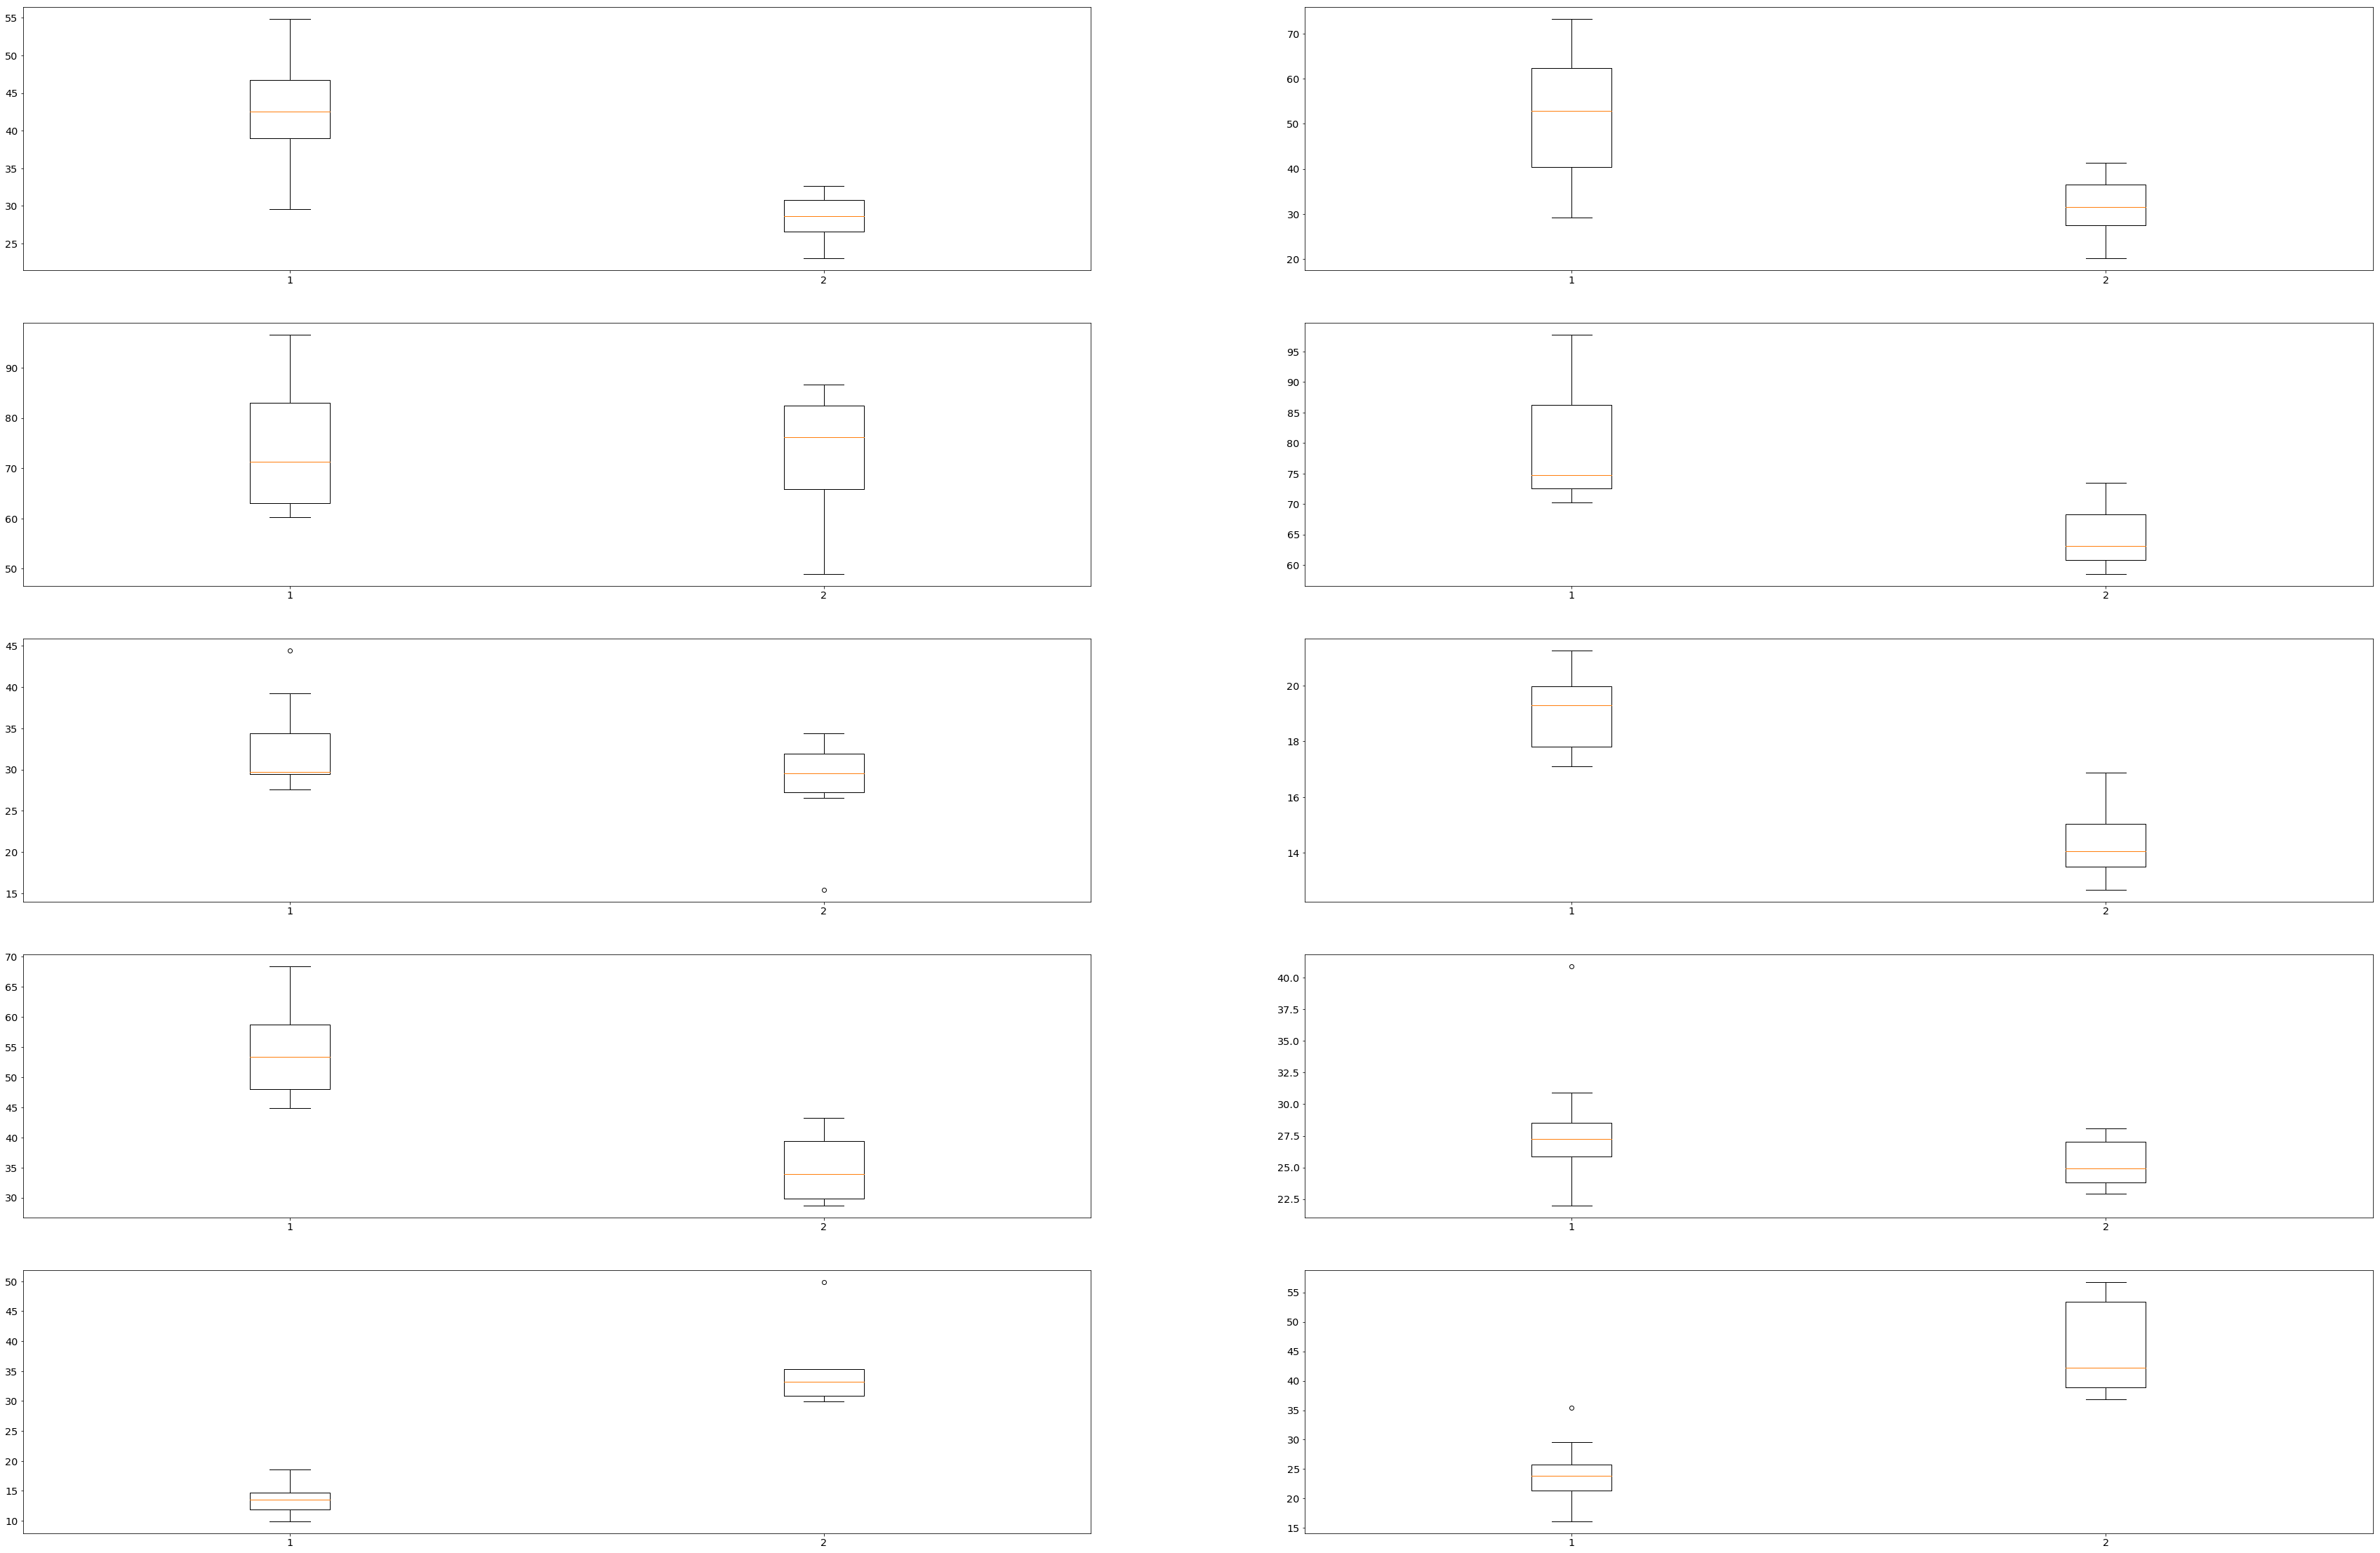

In [26]:
window = 500
plt.figure(figsize=(60, 40))
for i in range(10):
    name = training_sound_events.iloc[i].name
    filename = 'normal__' + name.replace('.aiff', '.wav')
    wav_file_name = os.path.join('set_b', 'normal', filename)
    sound_arr, samplerate = load_wav(wav_file_name)
    sample_file_S1_S2_demarcation = training_sound_events.loc[name].dropna()
    
    S1_S2_groups = sample_file_S1_S2_demarcation.groupby(by=lambda x: x.split('.')[0]).groups
    s1_ind = sample_file_S1_S2_demarcation.loc[S1_S2_groups['S1']].astype(int)
    s2_ind = sample_file_S1_S2_demarcation.loc[S1_S2_groups['S2']].astype(int)
    
    binned_sounds = np.abs(pd.Series(sound_arr)).rolling(window=window, center=True).apply(lambda x: x.sum())

    s1_amplitude = binned_sounds[s1_ind]
    s2_amplitude = binned_sounds[s2_ind]
    
    
    plt.subplot(5, 2, i + 1)
    
    plt.boxplot(
        [s1_amplitude.dropna().values,   s2_amplitude.dropna().values]
    )
    
    

*So, looking at total amplitudes within a specific window size seems to be one possible way to classify S1/S2 except the pattern does not seem to be uniform across audio files. For example, sometimes S1 >> S2 and other timers S2 >> S1, and sometimes they are very similar*

### 2. Potential feature: local frequencies of S1/S2 ###

In addition to the amplitude at each time point, it could also be interesting to look at the local frequency of signals near an S1/S2 data point. 

Before we looked at the frequency of the entire signal, but this time lets using the 'binned window' and calculate the frequency domain within each bin.

(This is identical to running a [spectrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html) analysis on a signal)

In [27]:
def np_pad(arr, arr_len):
    """
        Add zeros to an array to force the length of an array to be arr_len
    """
    new_arr = np.zeros(arr_len)
    new_arr[:arr.shape[0]] = arr
    return new_arr

def get_local_frequency(signal, center_point, window, normalize=True, cutoff=0, samplerate=1):
    """
        Given a signal and an identified region of interest (center_point). Return the freuqency domain of the data within a
        specific window size centered around the center_point
        
        Args:
            signal (np array): signal of interest
            center_point (int): Position/coordinate within the signal that will be in the center of the window
            window (int): Size of the window/# of datapoints merged
            
        Returns:
            four_arr (pd.Series): Series of the fourier signal
    """
    tmp = signal[~np.isnan(signal)]
    # return the left most point in the window (cannot be smaller than 0)
    left_point = int(max(0, center_point - window*1.0/2))
    # return the right most point in the window (cannot be larger than array size)
    right_point = int(min(center_point + window*1.0/2, tmp.shape[0] - 1))
    # take the window slice in that region
    subset = tmp[range(left_point, right_point + 1)]

    if subset.shape[0] < window:
        # its too small...we want to make sure all signals are equal length
        subset = np_pad(subset, window)
    elif subset.shape[0] > window:
        subset = subset[:window]
    # calculate the frequencies (only take the first n/2 samples (the remainder are the same frequency but on the - scale (due to symmetry)))
    
    freqs = fftpack.fftfreq(subset.shape[0], 1.0/samplerate)[:subset.shape[0]/2]
    amplitude = np.abs(fftpack.fft(subset))[:subset.shape[0]/2]
    if normalize:
        # divid all amplitudes over the max amplitdude
        # amplitude = amplitude/amplitude.max()
        amplitude = MinMaxScaler().fit_transform(amplitude.reshape(-1, 1)).squeeze()
    amplitude[amplitude<cutoff] = 0
    return pd.Series(amplitude, index=freqs).fillna(0)

In [28]:
# Get the spectrogram at each point in the array. Calcuate ffrequencyies within the given window
all_spec_data = {}
for pt in range(len(sound_arr)):
    all_spec_data[pt] = get_local_frequency(sound_arr, pt, window)
all_spec_data = pd.DataFrame(all_spec_data)
# For each frequency, normalize the spectgrogram across all data points
all_spec_data_normal = all_spec_data.apply(
    lambda x: StandardScaler().fit_transform(x.values.reshape(-1, 1)).squeeze(),
    axis=1
)

In [29]:
# Get spectrogram for S1 data
all_spec_data_normal[s1_ind]

1063      3720      7137      10782     13439     17160     20728  \
0.000 -0.816456 -0.547167 -0.656907 -0.955792 -0.183748 -0.566661  0.060291   
0.002  0.708788 -0.380134  0.329425  0.123579  0.208210 -0.030800  0.334529   
0.004 -0.341463 -1.375676 -0.671132  1.306161 -1.123662 -0.728463  0.541704   
0.006 -0.076791 -0.529934 -0.151172 -0.262680  1.029697  0.274143 -0.377903   
0.008  0.956837  0.956837  0.956837  0.956837  0.956837  0.956837  0.956837   
0.010  0.078633  0.732374  1.528839 -0.793228 -0.364347  0.291566  1.372142   
0.012 -0.809897 -0.518511 -1.061000 -0.575601  0.055887 -0.294929  1.126756   
0.014  0.065234 -0.635018  0.990934 -0.139115 -1.114637  0.160026  1.333533   
0.016 -1.147615 -1.173004  0.413192 -0.723895 -1.538959  0.721119  0.710044   
0.018 -1.364321 -1.149350 -0.209900 -0.358751 -1.142760  0.166287  0.687301   
0.020 -1.111396 -0.937650 -1.057853 -1.304626 -1.183719 -0.087553 -0.706075   
0.022 -0.705559 -1.051481 -1.182131 -1.182904 -1.257647 -0.750198 -1.036649   
0.024 -0.507908 -1.056872 -1.123097 -0.404008 -0.918623 -1.073629 -1.072420   
0.026 -0.137326 -0.639407 -0.983591 -0.946237 -0.846634 -0.674918 -0.878523   
0.028 -0.389222 -1.055012 -0.930850 -0.613758 -1.094715 -0.575892 -0.849674   
0.030 -0.563508 -1.096666 -0.611370 -0.510013 -0.382080 -0.768476 -1.088987   
0.032 -0.908333 -1.179092 -0.573326 -0.848467 -0.808054 -0.642280 -0.306980   
0.034 -0.752091 -1.077833 -0.869208 -0.637619 -1.134291 -0.595934 -1.152408   
0.036 -0.720882 -1.024872 -0.920091 -1.101968 -0.509487 -1.049760 -0.939085   
0.038 -0.509957 -1.096810 -0.542726 -0.963979 -0.860947 -0.781034 -0.605653   
0.040 -0.940306 -1.015894 -0.402479 -0.675446 -0.671598 -1.093004 -0.564569   
0.042 -0.673074 -0.733232 -0.624257 -0.952646 -0.453057 -0.922700 -0.869238   
0.044 -1.159430 -0.930598 -1.032179 -1.258741 -1.012891 -0.944691 -1.051018   
0.046 -0.612554 -0.995347 -0.957768 -0.839627 -0.490578 -0.987021 -0.737676   
0.048 -0.527268 -0.771685 -0.605978 -0.951050 -0.653697 -0.522656 -1.008971   
0.050 -1.010974 -0.980000 -0.784773 -0.506024 -0.684755 -0.741727 -0.986873   
0.052 -0.627909 -0.993889 -0.781726 -0.657029 -0.705744 -0.354329 -0.925387   
0.054 -0.994824 -1.047154 -1.035231 -0.556640 -0.630332 -0.788027 -0.990154   
0.056 -0.854867 -0.834568 -0.682268 -1.130320 -0.784967 -0.782156 -0.796930   
0.058 -0.840247 -0.980919 -0.562550 -0.611091 -0.517339 -0.832691 -0.930709   
...         ...       ...       ...       ...       ...       ...       ...   
0.440 -0.905561 -0.697968 -0.430524 -0.556483 -0.559126 -0.779181 -0.332835   
0.442 -0.902443 -0.517302 -0.654649 -0.489315 -0.214961 -0.906665 -0.339497   
0.444 -0.897807 -0.764493 -0.520802 -0.646427 -0.595184 -0.699093 -0.431999   
0.446 -0.949247 -0.467119 -0.785569 -0.620686  0.003052 -0.910358 -0.295361   
0.448 -0.758161 -0.577604 -0.499565 -0.079775 -0.603025 -0.913460 -0.536600   
0.450 -1.075407 -0.676292 -0.683692 -0.821847 -0.821551 -0.710582 -0.493478   
0.452 -0.857398 -0.219870 -0.272111 -0.624936 -0.975029 -0.692573 -0.036894   
0.454 -0.777280 -0.632138 -0.455363 -0.166787  0.232581 -0.532217 -0.952621   
0.456 -0.883552 -0.926782 -0.404301 -0.608173 -0.348350 -1.033489 -1.040373   
0.458 -0.878724 -0.776806 -0.831096 -0.904721 -0.725911 -0.738506 -0.702827   
0.460 -0.914215 -0.814890 -0.481194 -0.848590 -0.869749 -1.022334 -0.504660   
0.462 -0.947334 -0.928763 -0.756151 -0.159641 -0.598807 -1.002073 -0.512153   
0.464 -0.886614 -0.611123 -0.644008 -0.884336 -1.068590 -0.872655 -0.577632   
0.466 -0.878564 -0.726852 -0.511654 -0.864552 -0.485739 -0.781907 -0.975759   
0.468 -0.788996 -0.946308  0.137187 -0.201474 -0.888482 -0.789514 -0.328486   
0.470 -0.905654 -0.394381  0.192869 -0.460732 -0.690091 -0.933645 -0.300005   
0.472 -0.860254 -0.474305 -0.824018 -0.985305 -0.586964 -0.851954 -0.338475   
0.474 -0.881181 -0.959079 -0.177532 -0.355454 -0.132933 -0.959086 -0.913740   
0.476 -0.861235 -0.655219 -0.219420 -0.241975 -0.483704 -0.7

In [30]:
# Get spectrogram for S2 data
all_spec_data_normal[s2_ind]

2354      5011      8504      11845     14806     18451     22019  \
0.000 -0.560350 -0.894093 -0.844084 -0.742769 -0.576119 -0.776768 -0.891518   
0.002 -1.190692 -0.951804 -1.488306 -1.030189 -0.482855 -1.215398 -0.924875   
0.004 -1.439345 -1.276350 -1.552925 -0.718440 -1.173853 -1.447472 -1.549323   
0.006 -1.067986  0.326383 -1.067123  0.167436 -0.145388  0.289515  0.202417   
0.008 -0.770098  0.956837 -1.107836 -0.863265  0.950992  0.872244  0.956837   
0.010 -0.979136 -1.473114 -1.070223  1.163347  0.048440 -0.616126 -0.891151   
0.012  0.722412 -0.215868 -0.345882  1.768456  0.641200 -0.061710 -0.550511   
0.014  1.926204 -0.110953  1.203309  1.389088  1.617837  1.459388  0.987698   
0.016  1.934816  0.441222  1.934816  1.934816  1.934816  1.934816  1.477794   
0.018  1.811726  0.613846  1.970823  1.790160  1.334686  1.365080  1.163059   
0.020  0.900024  1.582720  1.074161  0.750848 -0.245231  0.669259  1.038997   
0.022 -0.067059  2.075444  0.075391  1.713205  0.314110  0.240834  1.026316   
0.024 -0.784024  1.813513 -0.372145  1.740039  0.815317  0.387064  1.414082   
0.026 -0.339815  1.624675 -0.887629  0.783701  1.125928  0.720563  1.343819   
0.028  0.304251  0.044000 -0.292215 -0.742947  0.857439  0.565641  0.916493   
0.030  0.140193 -0.003958 -0.649740  0.588091 -0.214949  0.291747 -0.018959   
0.032  0.433341  1.104295  0.019652  1.486522  0.757404  0.700281  0.311395   
0.034  0.102671  0.829330 -0.255230  0.562458  0.728630  0.368413 -0.179351   
0.036 -0.237554  0.697395 -0.126938  0.045343  0.755715  0.250281 -0.561308   
0.038 -0.492470  0.539791 -0.619251 -0.535396  0.581985  0.214178 -1.072943   
0.040 -0.382505  0.299158 -0.230119 -0.205557  0.294491  0.229202 -0.688592   
0.042 -0.215916  1.133866 -0.308580  0.223635 -0.045744  0.763878  0.051866   
0.044  0.136715  1.052135  0.100360  0.580232 -0.117818  0.666134  1.172112   
0.046  0.166724  1.244817  0.164680  1.339502  0.263741  0.920890  1.827559   
0.048  0.503632  1.758594  0.673174  1.665253  0.505643  1.203066  2.508158   
0.050  0.498703  1.143664  0.534186  1.557796  0.978809  1.123506  3.320989   
0.052  0.520865  1.220951  0.729684  0.984084  1.082270  1.549358  3.545990   
0.054  0.235245  0.456316  0.205198  1.330873  0.632847  1.701214  2.834563   
0.056 -0.531937 -0.521968 -0.583405  0.242765 -0.625752  0.575303  0.380965   
0.058 -0.569469  0.510575 -0.540701  1.123781 -0.790072  1.188129  1.790290   
...         ...       ...       ...       ...       ...       ...       ...   
0.440 -1.001100 -0.977905 -0.848574 -0.959197 -0.719801 -0.740700 -0.595448   
0.442 -1.042960 -0.583358 -0.807291 -0.887423 -1.079907 -0.987868 -1.011605   
0.444 -0.972094 -0.744579 -0.966985 -0.899749 -0.761724 -0.759462 -0.822387   
0.446 -0.926564 -0.741492 -0.863390 -0.702762 -0.896716 -0.913956 -0.885913   
0.448 -0.667980 -0.277779 -0.623582 -0.798650 -0.939589 -0.760096 -0.680294   
0.450 -0.959420 -0.531229 -0.990531 -0.835577 -0.773614 -0.913651 -0.707939   
0.452 -0.813869 -0.269869 -0.920569 -0.764751 -0.900256 -0.720530 -0.674494   
0.454 -0.987941 -0.247362 -0.986767 -1.122432 -0.946949 -0.961568 -0.981502   
0.456 -1.041956 -0.613451 -0.925483 -1.100181 -0.986425 -0.874281 -0.778240   
0.458 -0.982423 -0.784760 -1.007157 -0.855955 -1.016981 -0.795126 -0.920822   
0.460 -0.942894 -0.720866 -0.846657 -1.038892 -0.609356 -1.035505 -0.986471   
0.462 -0.903851 -0.454113 -1.035683 -0.994655 -0.784053 -0.858700 -0.984333   
0.464 -0.961339 -0.029575 -0.969552 -0.946979 -0.814514 -0.658164 -0.755415   
0.466 -0.957134 -0.777122 -0.958489 -0.775009 -1.040953 -1.031809 -0.734949   
0.468 -1.021978 -1.077604 -1.015602 -0.912967 -0.870327 -0.756711 -0.964637   
0.470 -1.009301 -0.660858 -0.970322 -0.834269 -1.060396 -0.951063 -0.953808   
0.472 -1.068327 -0.350183 -0.887873 -0.970006 -0.787733 -0.939851 -0.968751   
0.474 -1.042772 -0.411141 -0.867526 -0.908536 -0.860981 -1.069392 -0.983371   
0.476 -0.959420 -0.401461 -0.977076 -0.989540 -1.057334 -1.0

** A better way to compare the spectrograms is to use a heatmap **
1. Rows in the heatmap will correspond to the top 20 frequencies
2. Columns in the heatmap will correspond to the average contribution of frequency in datapoints binned as S1 vs datapoints binned as S2
3. Colors of each box will represent the relative contirbution of each frequency in a bin

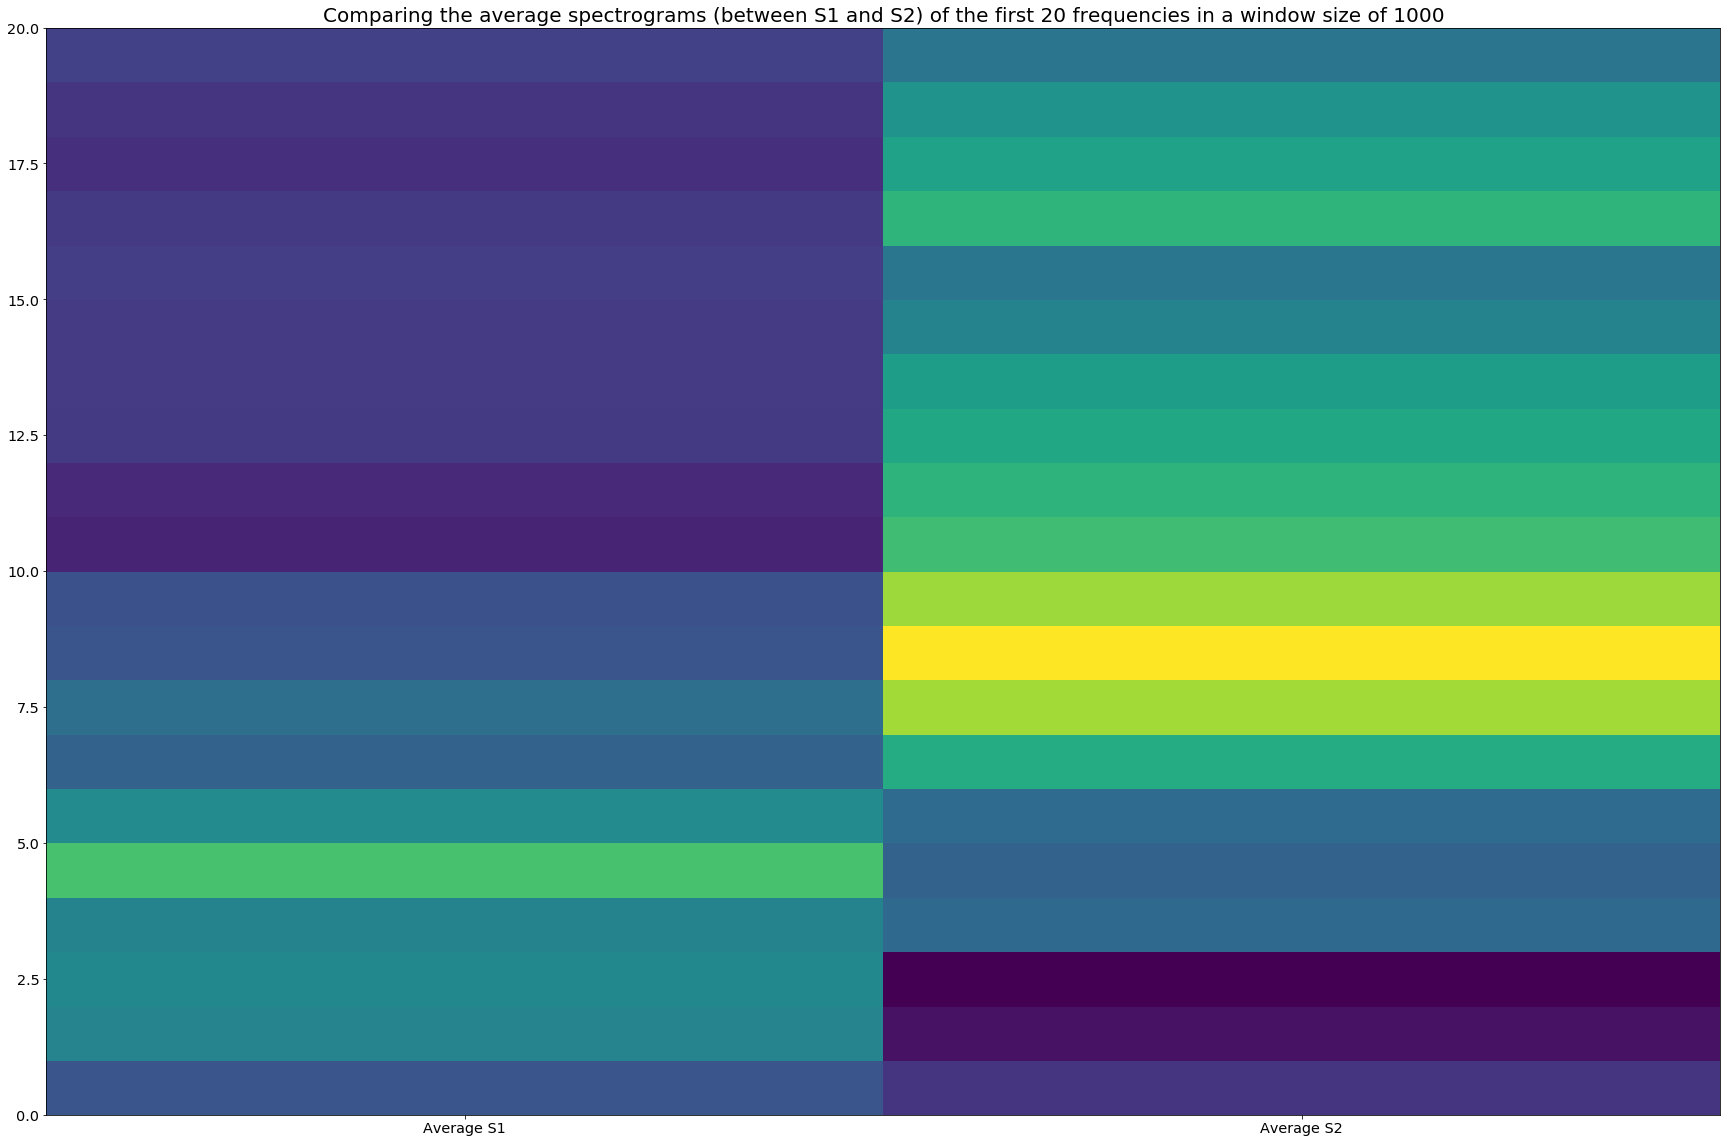

In [31]:
# merge the spec data from only S1/S2 events for this SINGLE WAV file
merge_s1_s2_local_frequencies = pd.concat([all_spec_data_normal[s1_ind], all_spec_data_normal[s2_ind]], axis=1, keys=['S1', 'S2'])

# merge data into a dataframe where we look at average amplitude for each frequency at all data points
tmptmp = merge_s1_s2_local_frequencies
plt.figure(figsize=(30, 20))
averaged_by_s1_s2 = tmptmp.apply(lambda x: pd.Series([x['S1'].mean(), x['S2'].mean()]), axis=1).iloc[:20].values
averaged_by_s1_s2[np.isnan(averaged_by_s1_s2)] = 0
ax = plt.subplot(111)
plt.pcolor(averaged_by_s1_s2)
plt.title(
    'Comparing the average spectrograms (between S1 and S2) of the first 20 frequencies in a window size of {0}'.format(2*window),
    fontsize=20,
)

ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['Average S1', 'Average S2'])


We might be able to use the spectrogram as a method for differentiating an S1 vs S2 signal. The contribution of each local frequency within a window will contribute to a feature for the dataset.

** But again, this is suffering from an N of 1 example, it will not be as clean when trying to account for all data **


#### Features decided to extract for classification ####

The figures above try to show that looking at both the amplitudes within a specificed timeframe in the wav file and the frequencies of the amplitudes could help in classifying S1 from S2 in each file. Although, the figures also showed that the patterns between S1 vs S2 are not uniform throughout each wav file (sometimes S1 > S2, other times S2 > S1, etc). 

Based on those figures, the following features will be extracted from wav files and tested for their ability to classify S1 and S2 events:

1. First identify the following settings for feature extractions
    * Filter to remove noisy areas in wav file
    * Window to use for extracting amplitudes (time window)
    * Window to use for extracting frequencies (spectogram window)
    
2. Once parameters above have been identified extract the following features:
    * Within the time window: # total features: ** *6* **
        * Max absolute value of amplitude within a window
        * Sum of all absolute values of amplitudes within a window
        * Min value/signal of amplitude (not absolute value) within a window
        * Max value/signal of amplitude (not absolute value) within a window
        * Distance of the datapoint from the max signal within a window
        * Distance of the datapoint from the min signal within a window
    * Within the spectogram window: # total features ** *depends on window size* **
        * Amplitudes for all frequencies identified within the specified window



-------------------



## Stage B: Extracting features from the wav files ##

** In this stage we will generate a pipeline/set of functions that can be used to extract features of interest for  performing classifications **


**Based on the above examples,  the following sets of steps will be performed on the data:**
1. Load the wav files into numpy arrays via soundfile module
2. Load the table of numpy arrays into a dataframe that is indexed by the filepath
3. Perform a low pass filter on the data files
4. Load the training file which defines the S1/S2 demarcations for each file
5. Using the filenames to join tables, map the S1/S2 positions onto each wav file and identify where S1/S2 occurs
6. Generate methods for extracting features described above


### Loading in the data ###

In order to streamline the processes described above, a python class was created to better keep track of the wav files loaded into a dataframe and the corresponding S1/S2 segmentation positions for each file

In [6]:
# import the class
from reading_wave_data import heart_signal, load_wav_data_into_features

The following shows how the class will be used

The attribute, signal_df, in the class represents a dataframe containing data from each wav file (rows = wav file, columns=frames)

In [33]:
# 1: Instantiate the class. Point it to where the wav files exist
# define both the location of all the wav files for traaining, and the location of the segmentation CSV file
set_b_group = heart_signal(folder_path='set_b/normal/', training_segmentation_file='./set_b/Btraining_normal_seg.csv')
# 2. Load the wav files into a dataframe
set_b_group.create_df()
set_b_group.signal_df

converted 0 values with unexpected large values to null
converted 3 values with unexpected TIME POINTS (i.e. S2 < s1 to null)


0         1         2         3         4      \
index                                                                    
216_1308245839516_C  -0.004791 -0.005249 -0.003540 -0.004333 -0.002625   
190_1308076920011_D   0.005676 -0.002167 -0.005219 -0.000763 -0.005188   
270_1309369533040_C  -0.031830 -0.029938 -0.023895 -0.024414 -0.039368   
170_1307970562729_A   0.012512  0.006561 -0.005676 -0.011017 -0.011566   
217_1308246111629_C  -0.004791 -0.011658 -0.009064 -0.005157 -0.002411   
274_1311075637574_A1 -0.029388 -0.029663 -0.029236 -0.031372 -0.027649   
153_1306848820671_D1  0.002808  0.008209  0.005859  0.005798  0.014038   
128_1306344005749_B  -0.041229 -0.038239 -0.035095 -0.036926 -0.033752   
186_1308073648738_D  -0.001282  0.007843  0.010956  0.013397  0.008972   
107_1305654946865_C1 -0.000793  0.001526  0.000092 -0.002380  0.004639   
154_1306935608852_A1  0.002319  0.000000  0.000702  0.000916  0.002716   
286_1311170606028_C  -0.004944 -0.005402 -0.000366  0.005554  0.007904   
250_1309202496494_A   0.005707 -0.001251 -0.002289 -0.007965 -0.007019   
167_1307111318050_C   0.005920  0.006226  0.009460  0.008392  0.000702   
181_1308052613891_B  -0.009918 -0.007782 -0.009430 -0.010773 -0.009705   
174_1307987737137_B1  0.014038  0.010559  0.010345  0.016388  0.014984   
103_1305031931979_D2  0.007416  0.008209  0.005188  0.001129  0.003784   
208_1308159994503_C  -0.003174 -0.008057  0.007416  0.014893  0.015137   
169_1307970398039_C  -0.021240 -0.022186 -0.019318 -0.020325 -0.020660   
209_1308162216750_A  -0.017761 -0.025482 -0.028381 -0.029694 -0.026978   
172_1307971284351_B  -0.006042 -0.017151 -0.022522 -0.023865 -0.027924   
170_1307970562729_C  -0.005249  0.001587 -0.003510 -0.011047 -0.004639   
172_1307971284351_B1  0.015320  0.018005  0.018036  0.015656  0.006226   
170_1307970562729_B  -0.045166 -0.035461 -0.036774 -0.048096 -0.042084   
127_1306764300147_C1  0.112885  0.102753  0.093781  0.084534  0.074371   
214_1308245489717_A   0.007812  0.004700  0.009735  0.016510  0.013824   
126_1306777102824_B  -0.016846 -0.019348 -0.021057 -0.014465 -0.015778   
106_1306776721273_C1  0.012787  0.010345  0.014465  0.018158  0.008423   
179_1307990076841_D   0.030853  0.019897  0.013428  0.013367  0.013550   
128_1306344005749_D  -0.003021 -0.002808 -0.003204 -0.004944 -0.009521   
...                        ...       ...       ...       ...       ...   
300_1311772096120_C1  0.002838  0.000305  0.008850  0.007812  0.001892   
261_1309353556003_B  -0.002380 -0.003235  0.001282  0.006073 -0.002563   
146_1306778707532_D1  0.025177  0.021790  0.017944  0.017487  0.015564   
201_1308144942432_A1  0.022095  0.024200  0.015106  0.017090  0.011230   
294_1311681084248_D1 -0.060669 -0.049591 -0.024780 -0.010040 -0.012848   
147_1306523973811_C  -0.008698 -0.009949 -0.007874 -0.004395 -0.006195   
115_1306259437619_C   0.004211  0.011200  0.009308  0.005280  0.001892   
175_1307987962616_B1  0.007111 -0.001160 -0.004364  0.008392  0.003632   
280_1311165195344_A  -0.001648 -0.000549 -0.002014 -0.006897 -0.006256   
238_1309194586293_B   0.016541  0.011841  0.009216  0.004028 -0.000427   
152_1306779561195_B1 -0.007874 -0.007416 -0.005737 -0.001038  0.001923   
286_1311170606028_A   0.002625  0.010223  0.014069  0.016754  0.010803   
155_1306935902813_B1  0.015778  0.018097  0.018585  0.013397  0.011322   
278_1311163365896_A   0.004364  0.005157  0.004669  0.002869  0.005646   
298_1311685888900_B  -0.003998 -0.004028 -0.000458 -0.002411 -0.004883   
143_1306763822290_C   0.030975  0.033936  0.035492  0.036102  0.040314   
148_1306768801551_D2  0.027191  0.023102  0.024689  0.023163  0.020508   
213_1308245263936_C   0.031128  0.027863  0.027679  0.027039  0.023041   
227_1308594233667_B   0.033478  0.034363  0.030975  0.027557  0.034180   
177_1307989650056_D1 -0.000488  0.002106  0.006195  0.001862  0.000946   
177_1307989650056_B  -0.012909 -0.012665 -0.015045 -0.016815 -0.018311   
191_1308077299430_B   0.14480

The attribute, segmentation_file, in the wav file represents the S1/S2 events. The filenames have been modified so that they match for both dataframes

In [34]:
# 3) in addition to the wav file df, we also have the segmentation file provided for training
# each column correspeonds to either an S1 or S2 event
set_b_group.segmentation_file

S1      S2    S1.1    S2.1    S1.2    S2.2     S1.3  \
103_1305031931979_D1   430.0  1547.0  2406.0  3437.0  4468.0  5413.0   6358.0   
103_1305031931979_D3   481.0  1524.0  2486.0  3448.0  4491.0  5533.0   6576.0   
106_1306776721273_C1   831.0  2076.0  3987.0  5288.0  7835.0  9192.0  11102.0   
106_1306776721273_D1   393.0  1682.0  3256.0  4545.0  6096.0  7364.0   9921.0   
109_1305653646620_C    861.0  2186.0  4172.0  5497.0  7881.0  9206.0  11259.0   
113_1306244002866_D    457.0  1436.0  2578.0  3558.0  4700.0  5777.0   6723.0   
115_1306259437619_C    737.0  1877.0  3553.0  4827.0  7509.0  8649.0  10258.0   
117_1306262456650_B   1614.0  2652.0  3978.0  4958.0  6399.0  7322.0   8648.0   
125_1306332456645_B    627.0  1272.0  2204.0  2850.0  3764.0  4480.0   5377.0   
126_1306777102824_D   1063.0  2354.0  3720.0  5011.0  7137.0  8504.0  10782.0   
127_1306764300147_A   2257.0  3260.0  4848.0  5934.0  7523.0  8609.0  10615.0   
127_1306764300147_B    506.0  1590.0  3181.0  4048.0  5638.0  6578.0   7879.0   
127_1306764300147_C1   313.0   850.0  2282.0  3266.0  4564.0  5637.0   6890.0   
128_1306344005749_B    480.0  1576.0  3084.0  4112.0  5415.0  6511.0   7951.0   
128_1306344005749_D    995.0  2075.0  3468.0  4577.0  6055.0  7221.0   8585.0   
128_1306344005749_D1   671.0  1789.0  3243.0  4249.0  5647.0  6765.0   8274.0   
129_1306344506305_B1   563.0  1612.0  2636.0  3659.0  4708.0     NaN   6320.0   
129_1306344506305_D   1118.0  2236.0  3727.0  4782.0  6149.0  7329.0   8757.0   
129_1306344506305_D1   588.0  1665.0  3037.0  4180.0  5649.0  6792.0   8261.0   
133_1306759619127_B    368.0  1521.0  2846.0  4048.0  5495.0  6623.0   8071.0   
133_1306759619127_D    660.0  1859.0  3682.0  4809.0     NaN     NaN      NaN   
134_1306428161797_C      NaN   594.0  1871.0  3059.0  4484.0  5613.0   6919.0   
134_1306428161797_D    319.0  1533.0  2725.0  3917.0     NaN     NaN      NaN   
137_1306764999211_D    612.0  1378.0  2194.0  2959.0  3827.0  4643.0   5408.0   
139_1306519274653_A    669.0  1807.0  3614.0  4819.0  7764.0  9036.0  11446.0   
140_1306519735121_A   1074.0  2245.0  4783.0  5857.0  8297.0  9469.0  12007.0   
140_1306519735121_D1  1755.0  2967.0  4054.0  5350.0  6394.0  7690.0  10240.0   
141_1306520154450_B    383.0  1318.0  2253.0  3146.0  4081.0  4974.0   5866.0   
141_1306520154450_C    535.0  1463.0  2363.0  3376.0  4333.0  5205.0   6162.0   
143_1306763822290_B   1136.0  2168.0  3794.0  4826.0  6452.0  7484.0   9316.0   
...                      ...     ...     ...     ...     ...     ...      ...   
169_1307970398039_C    586.0  1598.0  2930.0  3995.0  5300.0  6339.0   7698.0   
170_1307970562729_A    522.0  1487.0  3013.0  3897.0  5183.0  6107.0   7594.0   
170_1307970562729_B    265.0  1191.0  2449.0  3375.0  4898.0  5890.0   7148.0   
170_1307970562729_C      NaN   575.0  1788.0  2619.0  3832.0  4663.0   5621.0   
172_1307971284351_B    964.0  2120.0  3777.0  4972.0  6398.0  7515.0   9018.0   
173_1307973611151_B    730.0  1711.0  2893.0  3900.0  5157.0  6139.0   7522.0   
173_1307973611151_C    959.0  1972.0  3810.0  4796.0  6208.0  7193.0   8419.0   
174_1307987737137_B      NaN  1049.0  2765.0  4052.0  5720.0  6959.0   8675.0   
174_1307987737137_B1   831.0  1897.0  3541.0  4751.0  6449.0  7551.0      NaN   
175_1307987962616_B    750.0  1905.0  3502.0  4695.0  6408.0  7582.0      NaN   
176_1307988171173_A    391.0  1640.0  3619.0  4895.0  6821.0  8071.0   9997.0   
176_1307988171173_B    836.0  2119.0  4266.0  5549.0  7724.0  8978.0  10958.0   
176_1307988171173_B1   294.0  1598.0  3580.0  4859.0     NaN     NaN      NaN   
177_1307989650056_A1   321.0  1454.0  2587.0  3742.0  5260.0  6329.0   8318.0   
177_1307989650056_B    346.0  1347.0  2655.0  3694.0  4848.0  5887.0   7003.0   
177_1307989650056_D   1263.0  2401.0  3610.0  4678.0  6154.0  7292.0      NaN   
177_1307989650056_D1   419.0  1537.0  2864.0  4005.0  5495.0  6612.0   8358.0   
178_1307989887769_B    969.0  2180.0  3755.0  5007.0  625

In addition to S1/S2 events, we also want to be able to classify noise events

We assume that NOISE will be datapoints in between S1/S2

In [35]:
# lets create some noise events 'between' S1/S2
def get_some_noise_data(segmentation_file_df):    
    S_1_2_groups = segmentation_file_df.groupby(by=lambda x: x[:2], axis=1).groups
    noise_pos = segmentation_file_df[S_1_2_groups['S1']].values + \
        (segmentation_file_df[S_1_2_groups['S2']].values - segmentation_file_df[S_1_2_groups['S1']].values)/2
    noise_events = pd.DataFrame(noise_pos, index=segmentation_file_df.index, 
            columns=['NOISE'] * noise_pos.shape[1])
    noise_events = noise_events.applymap(lambda x: x if np.isnan(x) else int(x))
    return noise_events

In [36]:
# 3b) Lets also try and 'guess' noise events. We can assume they will occur between S1 and S2 events
# First identify columns based on whether they are an S1 or S2 event
S_1_2_groups = set_b_group.segmentation_file.groupby(by=lambda x: x[:2], axis=1).groups
# S1 group:
set_b_group.segmentation_file[S_1_2_groups['S1']]
# S2 group:
set_b_group.segmentation_file[S_1_2_groups['S2']]
get_some_noise_data(set_b_group.segmentation_file)

NOISE  NOISE   NOISE    NOISE    NOISE    NOISE  \
103_1305031931979_D1   988.0   2921  4940.0   6873.0   8935.0  10998.0   
103_1305031931979_D3  1002.0   2967  5012.0   7097.0   9102.0  11027.0   
106_1306776721273_C1  1453.0   4637  8513.0  11738.0      NaN      NaN   
106_1306776721273_D1  1037.0   3900  6730.0      NaN      NaN      NaN   
109_1305653646620_C   1523.0   4834  8543.0  11921.0  14802.0  18345.0   
113_1306244002866_D    946.0   3068  5238.0   7245.0   9236.0  11227.0   
115_1306259437619_C   1307.0   4190  8079.0  10827.0  13811.0  17196.0   
117_1306262456650_B   2133.0   4468  6860.0   9109.0  11386.0  13721.0   
125_1306332456645_B    949.0   2527  4122.0   5735.0   7357.0      NaN   
126_1306777102824_D   1708.0   4365  7820.0  11313.0  14122.0  17805.0   
127_1306764300147_A   2758.0   5391  8066.0  11033.0  13833.0      NaN   
127_1306764300147_B   1048.0   3614  6108.0   8457.0  10951.0  13517.0   
127_1306764300147_C1   581.0   2774  5100.0   7427.0   9910.0  12349.0   
128_1306344005749_B   1028.0   3598  5963.0   8499.0  11343.0  14016.0   
128_1306344005749_D   1535.0   4022  6638.0   9281.0  11968.0      NaN   
128_1306344005749_D1  1230.0   3746  6206.0   8833.0  11489.0  14032.0   
129_1306344506305_B1  1087.0   3147     NaN   6857.0   9966.0      NaN   
129_1306344506305_D   1677.0   4254  6739.0   9347.0  12049.0  14533.0   
129_1306344506305_D1  1126.0   3608  6220.0   8832.0  11379.0  13926.0   
133_1306759619127_B    944.0   3447  6059.0   8635.0      NaN      NaN   
133_1306759619127_D   1259.0   4245     NaN      NaN      NaN      NaN   
134_1306428161797_C      NaN   2465  5048.0   7483.0   9844.0  12235.0   
134_1306428161797_D    926.0   3321     NaN      NaN      NaN      NaN   
137_1306764999211_D    995.0   2576  4235.0   5816.0   7372.0   8954.0   
139_1306519274653_A   1238.0   4216  8400.0  12082.0  15328.0  18574.0   
140_1306519735121_A   1659.0   5320  8883.0  12592.0  15130.0  18791.0   
140_1306519735121_D1  2361.0   4702  7042.0  10866.0  14523.0  16822.0   
141_1306520154450_B    850.0   2699  4527.0   6355.0   8183.0  10032.0   
141_1306520154450_C    999.0   2869  4769.0   6598.0   8385.0  10185.0   
143_1306763822290_B   1652.0   4310  6968.0   9871.0      NaN      NaN   
...                      ...    ...     ...      ...      ...      ...   
169_1307970398039_C   1092.0   3462  5819.0   8217.0  10694.0      NaN   
170_1307970562729_A   1004.0   3455  5645.0   8056.0  10788.0  13259.0   
170_1307970562729_B    728.0   2912  5394.0   7611.0   9828.0  12078.0   
170_1307970562729_C      NaN   2203  4247.0   6132.0   8112.0  10092.0   
172_1307971284351_B   1542.0   4374  6956.0   9538.0  12024.0  14568.0   
173_1307973611151_B   1220.0   3396  5648.0   8025.0  10286.0      NaN   
173_1307973611151_C   1465.0   4303  6700.0   8925.0  11150.0      NaN   
174_1307987737137_B      NaN   3408  6339.0   9259.0      NaN      NaN   
174_1307987737137_B1  1364.0   4146  7000.0      NaN      NaN      NaN   
175_1307987962616_B   1327.0   4098  6995.0      NaN      NaN      NaN   
176_1307988171173_A   1015.0   4257  7446.0  10648.0      NaN      NaN   
176_1307988171173_B   1477.0   4907  8351.0  11585.0      NaN      NaN   
176_1307988171173_B1   946.0   4219     NaN      NaN      NaN      NaN   
177_1307989650056_A1   887.0   3164  5794.0   8895.0      NaN      NaN   
177_1307989650056_B    846.0   3174  5367.0   7599.0  10158.0  13083.0   
177_1307989650056_D   1832.0   4144  6723.0      NaN      NaN      NaN   
177_1307989650056_D1   978.0   3434  6053.0   8917.0      NaN      NaN   
178_1307989887769_B   1574.0   4381  6904.0   9306.0  11930.0  14676.0   
178_1307989887769_D   1257.0   3974  6741.0  10011.0  13282.0  16149.0   
179_1307990076841_D   1040.0   3393  5794.0   8547.0  11124.0  13588.0   
180_1307990956284_A   1812.0   4630  7864.0  11179.0      NaN      NaN   
180_1307990956284_C   1560.0   4795  7567.0  10501.0  13901.0  17160.0   
181_1308052613891_B    856.

We now have 3 types of response variables we want to characterize:

* S1
* S2
* Noise

the function, get_some_noise_data is also present in the heart_signal class to make everything easier to work with 

In [39]:
set_b_group.guess_noise_data()
set_b_S1_S2_noise_datapoints = set_b_group.return_S1_S2_noise_position(inplace=False)
set_b_group.noise_df

NOISE  NOISE   NOISE    NOISE    NOISE    NOISE  \
103_1305031931979_D1   988.0   2921  4940.0   6873.0   8935.0  10998.0   
103_1305031931979_D3  1002.0   2967  5012.0   7097.0   9102.0  11027.0   
106_1306776721273_C1  1453.0   4637  8513.0  11738.0      NaN      NaN   
106_1306776721273_D1  1037.0   3900  6730.0      NaN      NaN      NaN   
109_1305653646620_C   1523.0   4834  8543.0  11921.0  14802.0  18345.0   
113_1306244002866_D    946.0   3068  5238.0   7245.0   9236.0  11227.0   
115_1306259437619_C   1307.0   4190  8079.0  10827.0  13811.0  17196.0   
117_1306262456650_B   2133.0   4468  6860.0   9109.0  11386.0  13721.0   
125_1306332456645_B    949.0   2527  4122.0   5735.0   7357.0      NaN   
126_1306777102824_D   1708.0   4365  7820.0  11313.0  14122.0  17805.0   
127_1306764300147_A   2758.0   5391  8066.0  11033.0  13833.0      NaN   
127_1306764300147_B   1048.0   3614  6108.0   8457.0  10951.0  13517.0   
127_1306764300147_C1   581.0   2774  5100.0   7427.0   9910.0  12349.0   
128_1306344005749_B   1028.0   3598  5963.0   8499.0  11343.0  14016.0   
128_1306344005749_D   1535.0   4022  6638.0   9281.0  11968.0      NaN   
128_1306344005749_D1  1230.0   3746  6206.0   8833.0  11489.0  14032.0   
129_1306344506305_B1  1087.0   3147     NaN   6857.0   9966.0      NaN   
129_1306344506305_D   1677.0   4254  6739.0   9347.0  12049.0  14533.0   
129_1306344506305_D1  1126.0   3608  6220.0   8832.0  11379.0  13926.0   
133_1306759619127_B    944.0   3447  6059.0   8635.0      NaN      NaN   
133_1306759619127_D   1259.0   4245     NaN      NaN      NaN      NaN   
134_1306428161797_C      NaN   2465  5048.0   7483.0   9844.0  12235.0   
134_1306428161797_D    926.0   3321     NaN      NaN      NaN      NaN   
137_1306764999211_D    995.0   2576  4235.0   5816.0   7372.0   8954.0   
139_1306519274653_A   1238.0   4216  8400.0  12082.0  15328.0  18574.0   
140_1306519735121_A   1659.0   5320  8883.0  12592.0  15130.0  18791.0   
140_1306519735121_D1  2361.0   4702  7042.0  10866.0  14523.0  16822.0   
141_1306520154450_B    850.0   2699  4527.0   6355.0   8183.0  10032.0   
141_1306520154450_C    999.0   2869  4769.0   6598.0   8385.0  10185.0   
143_1306763822290_B   1652.0   4310  6968.0   9871.0      NaN      NaN   
...                      ...    ...     ...      ...      ...      ...   
169_1307970398039_C   1092.0   3462  5819.0   8217.0  10694.0      NaN   
170_1307970562729_A   1004.0   3455  5645.0   8056.0  10788.0  13259.0   
170_1307970562729_B    728.0   2912  5394.0   7611.0   9828.0  12078.0   
170_1307970562729_C      NaN   2203  4247.0   6132.0   8112.0  10092.0   
172_1307971284351_B   1542.0   4374  6956.0   9538.0  12024.0  14568.0   
173_1307973611151_B   1220.0   3396  5648.0   8025.0  10286.0      NaN   
173_1307973611151_C   1465.0   4303  6700.0   8925.0  11150.0      NaN   
174_1307987737137_B      NaN   3408  6339.0   9259.0      NaN      NaN   
174_1307987737137_B1  1364.0   4146  7000.0      NaN      NaN      NaN   
175_1307987962616_B   1327.0   4098  6995.0      NaN      NaN      NaN   
176_1307988171173_A   1015.0   4257  7446.0  10648.0      NaN      NaN   
176_1307988171173_B   1477.0   4907  8351.0  11585.0      NaN      NaN   
176_1307988171173_B1   946.0   4219     NaN      NaN      NaN      NaN   
177_1307989650056_A1   887.0   3164  5794.0   8895.0      NaN      NaN   
177_1307989650056_B    846.0   3174  5367.0   7599.0  10158.0  13083.0   
177_1307989650056_D   1832.0   4144  6723.0      NaN      NaN      NaN   
177_1307989650056_D1   978.0   3434  6053.0   8917.0      NaN      NaN   
178_1307989887769_B   1574.0   4381  6904.0   9306.0  11930.0  14676.0   
178_1307989887769_D   1257.0   3974  6741.0  10011.0  13282.0  16149.0   
179_1307990076841_D   1040.0   3393  5794.0   8547.0  11124.0  13588.0   
180_1307990956284_A   1812.0   4630  7864.0  11179.0      NaN      NaN   
180_1307990956284_C   1560.0   4795  7567.0  10501.0  13901.0  17160.0   
181_1308052613891_B    856.

### Raw data processing ###

1. Chooze a frequency cutoff
2. Perform low pass filtering

In this case we will use 50hz as our cutoff

In [40]:
# low pass filtering of wav files
freq_cutoff = 50
set_b_group.low_pass_filter(freq_cutoff, inplace=True)

None


### Isolate amplitude features within window frame ###

One of the interesting features we hope to comparing S1/S2 is to compare the total amplitude within a set window for each series: 

Based on eye (looking at figures), this window size will be set at 0.1 seconds

For dataset B, the samplerate was 4000 events per second, so we need to calculate the # of frames to bin to capture 0.1 seconds

In [41]:
# we want to bin together all data with 0.1 seconds 
window_size_in_sec = 0.1
# we need to account for the sample rate of each audio file to determine the proper window length in a numpy array
windows = set_b_group.data_df.samplerate.apply(lambda x: x * window_size_in_sec * 1.0).astype(int)
windows

index
216_1308245839516_C     400
190_1308076920011_D     400
270_1309369533040_C     400
170_1307970562729_A     400
217_1308246111629_C     400
274_1311075637574_A1    400
153_1306848820671_D1    400
128_1306344005749_B     400
186_1308073648738_D     400
107_1305654946865_C1    400
154_1306935608852_A1    400
286_1311170606028_C     400
250_1309202496494_A     400
167_1307111318050_C     400
181_1308052613891_B     400
174_1307987737137_B1    400
103_1305031931979_D2    400
208_1308159994503_C     400
169_1307970398039_C     400
209_1308162216750_A     400
172_1307971284351_B     400
170_1307970562729_C     400
172_1307971284351_B1    400
170_1307970562729_B     400
127_1306764300147_C1    400
214_1308245489717_A     400
126_1306777102824_B     400
106_1306776721273_C1    400
179_1307990076841_D     400
128_1306344005749_D     400
                       ... 
300_1311772096120_C1    400
261_1309353556003_B     400
146_1306778707532_D1    400
201_1308144942432_A1    400
294_1311681084

Now get the 'sum' of the absolute value of all amplitudes within a window size of 400

*Note: the amplitudes have been standardized to have a mean of 0 and stdev of 1*

In [42]:
summed_window = set_b_group.get_window_signal(windows, method='sum', absV=True)
summed_window.iloc[0].dropna()

200      2.923266
201      2.923876
202      2.924386
203      2.925997
204      2.928688
205      2.932437
206      2.937217
207      2.943001
208      2.949759
209      2.957461
210      2.966073
211      2.975562
212      2.985893
213      2.997029
214      3.008934
215      3.021571
216      3.034903
217      3.048892
218      3.063501
219      3.078692
220      3.094431
221      3.110680
222      3.127404
223      3.144570
224      3.162143
225      3.180092
226      3.198386
227      3.216996
228      3.235894
229      3.255054
           ...   
12308    6.348742
12309    6.307338
12310    6.266172
12311    6.225174
12312    6.184277
12313    6.143419
12314    6.102542
12315    6.061595
12316    6.020532
12317    5.979317
12318    5.937924
12319    5.896333
12320    5.854539
12321    5.812545
12322    5.770365
12323    5.728026
12324    5.685567
12325    5.643037
12326    5.600500
12327    5.558028
12328    5.515708
12329    5.473636
12330    5.431920
12331    5.390678
12332    5

We can also use the same function to get the 'minimum' amplitude within a window

In [43]:
min_window = set_b_group.get_window_signal(windows, method='min', absV=False)
min_window.iloc[0].dropna()

200     -0.024041
201     -0.024041
202     -0.024041
203     -0.024041
204     -0.024041
205     -0.024041
206     -0.024041
207     -0.024041
208     -0.024041
209     -0.024041
210     -0.024041
211     -0.024041
212     -0.024041
213     -0.024041
214     -0.024041
215     -0.024041
216     -0.024041
217     -0.024041
218     -0.024041
219     -0.024041
220     -0.024041
221     -0.024041
222     -0.024041
223     -0.024041
224     -0.024041
225     -0.024041
226     -0.024041
227     -0.024041
228     -0.024041
229     -0.024041
           ...   
12308   -0.030227
12309   -0.030227
12310   -0.030227
12311   -0.030227
12312   -0.030227
12313   -0.030227
12314   -0.030227
12315   -0.030227
12316   -0.030227
12317   -0.030227
12318   -0.030227
12319   -0.030227
12320   -0.030227
12321   -0.030227
12322   -0.030227
12323   -0.030227
12324   -0.030227
12325   -0.030227
12326   -0.030227
12327   -0.030227
12328   -0.030227
12329   -0.030227
12330   -0.030227
12331   -0.030227
12332   -0

In [44]:
# get the remaining features
max_abs = set_b_group.get_window_signal(windows, method='max', absV=True)
max_signal = set_b_group.get_window_signal(windows, method='max', absV=False)
distance_from_max = set_b_group.distance_from(windows, method='max')
distance_from_min = set_b_group.distance_from(windows, method='min')


### Isolate spectrogram within window frame ###

Another important feature is to try and get spectrogram within window points

*For this instance, we will use the same window size we used for the average amplitudes*

*Note: Because it can take a long time to extract spectrogram for every point in an array, we will only get the spectrogram at data points designated to be S1/S2 OR noise

In [45]:
spectrogram_features = set_b_group.get_spectrogram_for_defined_responses(windows, responses=['S1', 'S2', 'NOISE'])
useful_frequencies = spectrogram_features['spec'].loc[:, spectrogram_features['spec'].std(axis=0)>0]

/home/ubuntu/py2.7copy/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


WARNING DUPLICATE ROWS WERE DELETED, UNEXPECTED!!!
                 basename col_name      pos response  window
633   178_1307989887769_D    S1.14  38940.0       S1     400
1333  178_1307989887769_D    S2.14  38940.0       S2     400
2023  178_1307989887769_D    NOISE  38940.0    NOISE     400


### Merging all features together ###

The steps above demonstrate how we will extract features of interest from the wav files. Next, for each datapoint in the training set designated as S1, S2, or NOISE we need to merge the features isolated from the amplitude window and the features isolated from the spectrogram together


In [46]:
summed_window[set_b_S1_S2_noise_datapoints.isnull()] = np.nan 
max_abs[set_b_S1_S2_noise_datapoints.isnull()] = np.nan
max_signal[set_b_S1_S2_noise_datapoints.isnull()] = np.nan
distance_from_max[set_b_S1_S2_noise_datapoints.isnull()] = np.nan
distance_from_min[set_b_S1_S2_noise_datapoints.isnull()] = np.nan
min_window[set_b_S1_S2_noise_datapoints.isnull()] = np.nan



In [47]:
# spectrogram_features['info'] 'REPORTS WHETHER POSITION IS s1/s2/noise and where that position occurred and window size
features_and_response = pd.concat(
    [
        spectrogram_features['info'], 
        useful_frequencies, 
        summed_window.stack(), 
        max_abs.stack(),
        max_signal.stack(),
        distance_from_max.stack(),
        distance_from_min.stack(),
        min_window.stack()
    ], axis=1, join='inner', keys=['info', 'spec', 'AverageAmplitude', 'MaxAbs', 'MaxAmp', 'MinAmp', 'MaxDist', 'MinDist']
)

This table summarizes our current set of data we will use for training. Rows are different responses (S1, S2, or NOISE) at various time points in the training wav files. Columns represent features we can use for training

**Total training size**

In [48]:
features_and_response.shape

(2097, 209)

** Null frequency for S1/S2/NOISE **

In [49]:
features_and_response[('info', 'response')].value_counts(True)

S1       0.340172
S2       0.331584
NOISE    0.328244
Name: (info, response), dtype: float64

*All data described in this section has been moved into an automated function where you pass in a list of files and it spits out the features listed above*

In [50]:
# l(/r)_trim_trim: the number of seconds to remove from the front and end of a wave file
features_and_response, heart_group = load_wav_data_into_features(
    wave_folder_path='set_b/normal/', training_segmentation_file='./set_b/Btraining_normal_seg.csv',
    l_time_trim = 0.1, r_time_trim=0.1
)
features_and_response.shape

reading in files
converted 0 values with unexpected large values to null
converted 3 values with unexpected TIME POINTS (i.e. S2 < s1 to null)
4000.0
Low pass filter
None
Get average amplitude
individual amplitude
individual differences
Get spectrogram
WARNING DUPLICATE ROWS WERE DELETED, UNEXPECTED!!!
                 basename col_name      pos response  window
633   178_1307989887769_D    S1.14  38940.0       S1     400
1333  178_1307989887769_D    S2.14  38940.0       S2     400
2023  178_1307989887769_D    NOISE  38940.0    NOISE     400
generate features


(2079, 211)

In [51]:
features_and_response

info                      spec            \
major                        col_name response window         0        10   
103_1305031931979_D1 430.0         S1       S1  400.0  2.455153  2.525167   
                     988.0      NOISE    NOISE  400.0  2.219730  3.508785   
                     1547.0        S2       S2  400.0  0.401401  0.653930   
                     2406.0      S1.1       S1  400.0  1.764093  2.424900   
                     2921.0     NOISE    NOISE  400.0  4.119982  5.893852   
                     3437.0      S2.1       S2  400.0  0.238766  0.689840   
                     4468.0      S1.2       S1  400.0  2.160878  4.444002   
                     4940.0     NOISE    NOISE  400.0  1.168565  2.531953   
                     5413.0      S2.2       S2  400.0  0.448093  1.207054   
                     6358.0      S1.3       S1  400.0  0.318596  3.137882   
                     6873.0     NOISE    NOISE  400.0  1.076877  1.324389   
                     7389.0      S2.3       S2  400.0  0.895875  1.506525   
                     8420.0      S1.4       S1  400.0  2.352790  4.603586   
                     8935.0     NOISE    NOISE  400.0  3.450755  4.267242   
                     9451.0      S2.4       S2  400.0  0.045702  1.667593   
                     10482.0     S1.5       S1  400.0  2.431691  2.785952   
                     10998.0    NOISE    NOISE  400.0  0.956090  2.962327   
                     11514.0     S2.5       S2  400.0  1.175901  0.754640   
                     12545.0     S1.6       S1  400.0  3.353475  3.448116   
                     13060.0    NOISE    NOISE  400.0  1.054597  1.657748   
                     13576.0     S2.6       S2  400.0  0.480611  0.476830   
                     14607.0     S1.7       S1  400.0  1.786510  4.354005   
                     15079.0    NOISE    NOISE  400.0  2.000462  4.516083   
                     15552.0     S2.7       S2  400.0  2.676458  2.586836   
                     16583.0     S1.8       S1  400.0  0.491772  3.463764   
                     17098.0    NOISE    NOISE  400.0  1.073594  3.372623   
                     17614.0     S2.8       S2  400.0  0.414794  0.311343   
                     18559.0     S1.9       S1  400.0  1.014237  2.378441   
                     19074.0    NOISE    NOISE  400.0  2.142843  5.208646   
                     19590.0     S2.9       S2  400.0  1.838031  1.978924   
...                               ...      ...    ...       ...       ...   
188_1308074301731_C  21962.0    NOISE    NOISE  400.0  0.831112  1.778994   
                     22498.0     S2.8       S2  400.0  1.379705  2.176652   
                     24038.0     S1.9       S1  400.0  2.053594  2.038665   
                     24574.0    NOISE    NOISE  400.0  0.343268  0.515790   
                     25110.0     S2.9       S2  400.0  2.251126  3.858052   
                     26516.0    S1.10       S1  400.0  1.010525  3.059645   
                     27051.0    NOISE    NOISE  400.0  0.008475  1.331847   
                     27587.0    S2.10       S2  400.0  1.207035  1.896118   
                     28926.0    S1.11       S1  400.0  1.719591  3.113710   
                     29495.0    NOISE    NOISE  400.0  0.837490  1.092836   
                     30064.0    S2.11       S2  400.0  1.287088  1.212105   
188_1308074301731_D  912.0         S1       S1  400.0  0.022403  1.578315   
                     1456.0     NOISE    NOISE  400.0  0.197960  0.148592   
                     2001.0        S2       S2  400.0  0.307095  1.047857   
                     3490.0      S1.1       S1  400.0  0.572744  2.230746   
                     4035.0     NOISE    NOISE  400.0  0.256863  0.343525   
                     4580.0      S2.1       S2  400.0  0.059499  0.665302   
                     6025.0      S1.2       S1  400.0  1.969264  2.945897   
                     6569.0     NOISE    NOISE  400.0  0.398967  0.869754   
                     7114.0  

### Current feature assessment ###

At this point there is a pipeline for loading a desired set of wav files into a dataframe, and based on the (1) S1/S2 demarcation csv for those wav files and (2) user defined settings for the window size and raw data processing, generate a table of features/responses

Each row in the table represents either an S1, S2, or Noise
Columns represent the features described above

Based on our naive assumptions for the window size and noise filter, look at how well the current columns can segregate S1, S2, and NOISE


In [52]:
s1_rows = features_and_response[('info', 'response')] == 'S1'
s2_rows = features_and_response[('info', 'response')] == 'S2'
noise_rows = features_and_response[('info', 'response')] == 'NOISE'

Look at the differences in measured amplitudes within the predefined window 

The following boxplots will look at how S1 vs S2 vs NOISE changes when extracting

* The sum of noise in a window
* The max amplitude of absolute values in window
* The max amplitude (not absolute value)
* The min amplitude (not absolute value)
* The distance from the max peak
* The distance from the min peak
* The local differential between amplitudes around point
* The raw amplitude of the demarcated datapoint


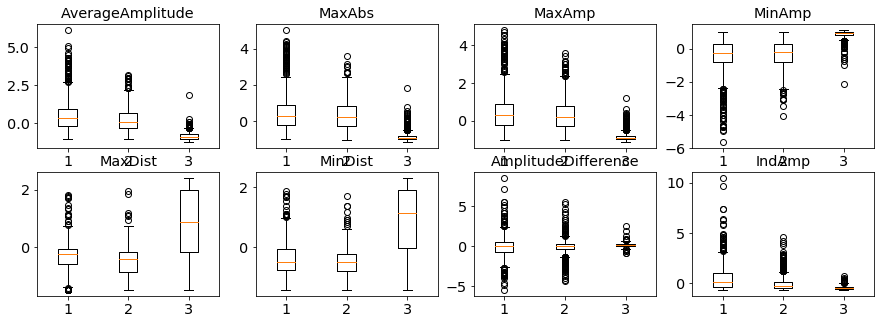

In [53]:
amp_c = ['AverageAmplitude', 'MaxAbs', 'MaxAmp', 'MinAmp', 'MaxDist', 'MinDist', 'AmplitudeDifference', 'IndAmp']

# plt.figure(figsize=(60, 40))
temp = features_and_response.copy()
temp[amp_c] = StandardScaler().fit_transform(temp[amp_c])
for i, c in enumerate(amp_c):
    plt.subplot(2, 4, i + 1)
    plt.boxplot([
        temp[s1_rows][c].values,
        temp[s2_rows][c].values,
        temp[noise_rows][c].values,
    ])
    plt.title(c)


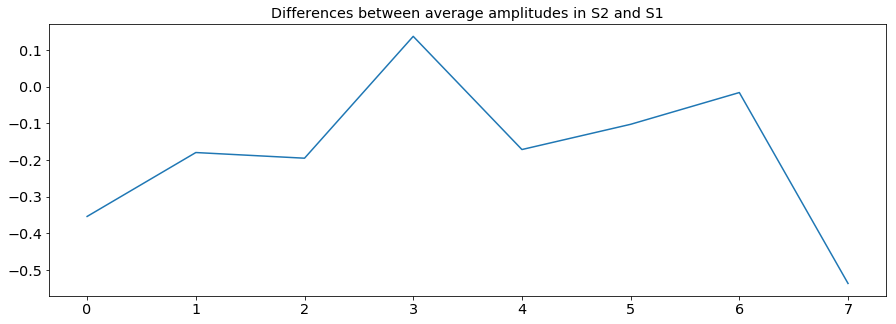

In [54]:
plt.plot(
    temp.groupby(by=[('info', 'response')]).apply(np.mean)[amp_c].diff().iloc[-1].values
)
plt.title('Differences between average amplitudes in S2 and S1')

Look at differences in spectrogram between S1/S2/Noise

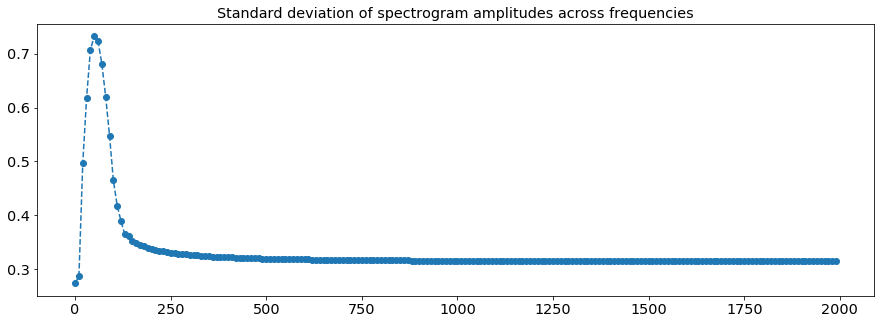

In [55]:
temp['spec'] = StandardScaler().fit_transform(temp['spec'])
grouped_spec_vals = temp.groupby(by=[('info', 'response')]).apply(np.mean)['spec'].T
plt.plot(grouped_spec_vals.std(axis=1), '--o')
plt.title('Standard deviation of spectrogram amplitudes across frequencies')

Only the top 15 or so frequencies show variation in frequency

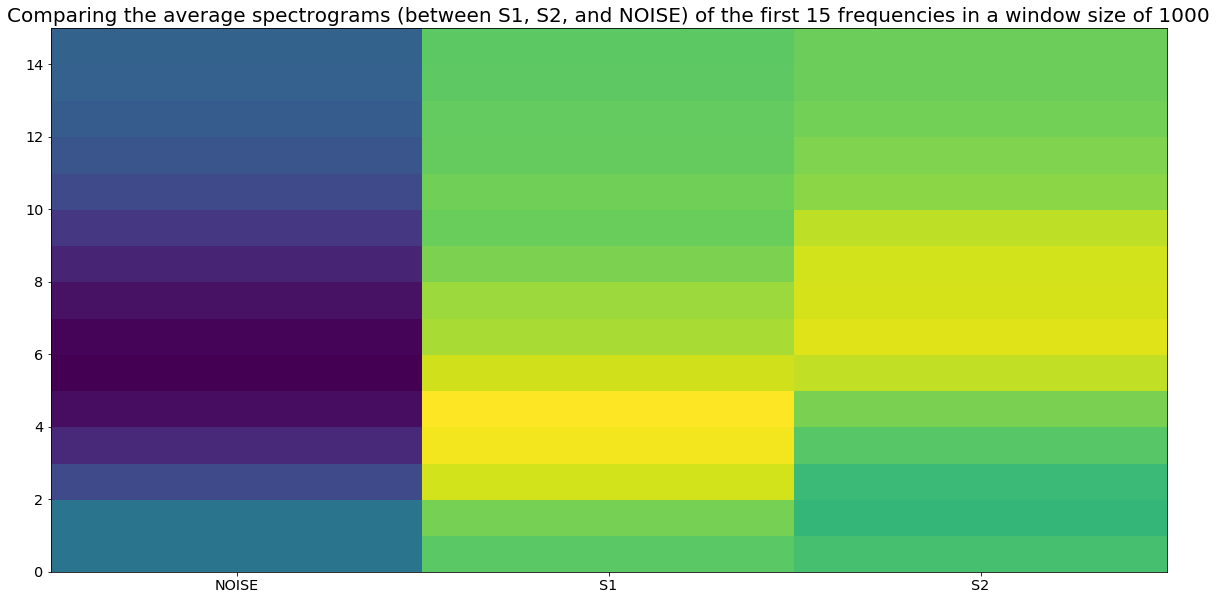

In [56]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
plt.pcolor(grouped_spec_vals.iloc[:15, :])
plt.title(
    'Comparing the average spectrograms (between S1, S2, and NOISE) of the first 15 frequencies in a window size of {0}'.format(2*window),
    fontsize=20,
)

ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['NOISE', 'S1', 'S2'])

**Using the current settings for extracting features it seems as though its the noise events can be segregated from both S1/S2 events using amplitude and results from spectrogram, but the actual challenge of separating S1 from S2 appears much more difficult**

In the next stage, this data will be used to identify a model for optimization of feature selection 

## Stage C: Select a model of interest for classifying the data ##

** In the previous stages we (1) identified which features we want to isolate from the wav file and (2) defined a pipeline that can be convert all of the wav data into a table of features and responses **

Using our current set of features generated in stage b, next goal is to test a few models and select one that seems to perform best

In [57]:
# drop rows with nulls
features_and_response_null_drop = features_and_response[features_and_response.isnull().sum(axis=1)==0]


Create features X and responses y

In [58]:
# use these features for training
amp_col = ['AverageAmplitude', 'MaxAbs', 'MaxAmp', 'MinAmp', 'MaxDist', 'MinDist', 'AmplitudeDifference', 'IndAmp']
amp_col = list(features_and_response[amp_col].columns)
# use these frequencies from a spectrogram
spec_col = [('spec', c) for c in list(features_and_response_null_drop['spec'].iloc[:, :30].columns)]
y = features_and_response_null_drop['info']['response'].map({'S1': 0, 'S2': 1, 'NOISE': 2}).values
X = features_and_response_null_drop[amp_col + spec_col].values

In [59]:
X.shape

(2078, 28)

There are 2078 total rows and 28 features we will use for training initial models


The following lists the frequencies for each response:
S1 is mapped as 0, S2 is mapped as 1, and NOISE is mapped as 2

In [60]:
pd.Series(y).value_counts(True)

0    0.336381
1    0.332531
2    0.331088
dtype: float64

**Normalize Data**

In [61]:
sc = StandardScaler()
[Xtrain, Xvalidate, Ytrain, Yvalidate] = train_test_split(X.copy(), y.copy(), train_size=0.95)
X_std = sc.fit_transform(Xtrain)
Xvalidate_std = sc.transform(Xvalidate)

In [62]:
Xvalidate.shape

(104, 28)

In [63]:
model_results = {}

In [64]:
def perform_cross_validation(model, name, x, y, results_dict):
    kfold = StratifiedKFold(
        y=y,
        n_folds=20,
    )

    scores = []
    for k, (train, test) in enumerate(kfold):
        model.fit(x[train], y[train])
        score = accuracy_score(model.predict(x[test]), y[test])
        scores.append(score)
    mean_sc = np.array(scores).mean()
    plt.plot(scores)
    plt.plot((0, k), (mean_sc,mean_sc), '--r')
    plt.title('Cross Validation for {0}: Average score {1}'.format(name, mean_sc))
    results_dict[name] = mean_sc

** KNN Classifier **

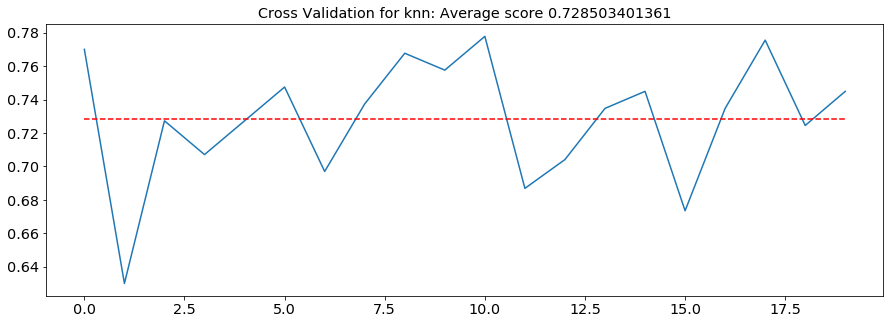

In [65]:
knn = KNeighborsClassifier(n_neighbors=3, p=5)
perform_cross_validation(knn, 'knn', X_std, Ytrain, model_results)

In [69]:
model=knn
model.fit(Xtrain, Ytrain)
kn1_ans = model.predict(Xvalidate)
print(accuracy_score(kn1_ans, Yvalidate))

0.701923076923


** SVC Classifier **

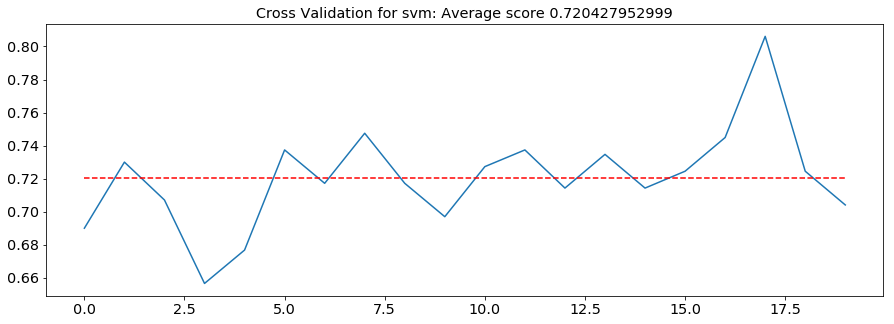

In [70]:
svm = SVC(kernel='poly')
perform_cross_validation(svm, 'svm', X_std, Ytrain, model_results)

In [71]:
model=svm
model.fit(Xtrain, Ytrain)
svm_ans = model.predict(Xvalidate)
print(accuracy_score(svm_ans, Yvalidate))

0.778846153846


** Logistic Regression Classifier **

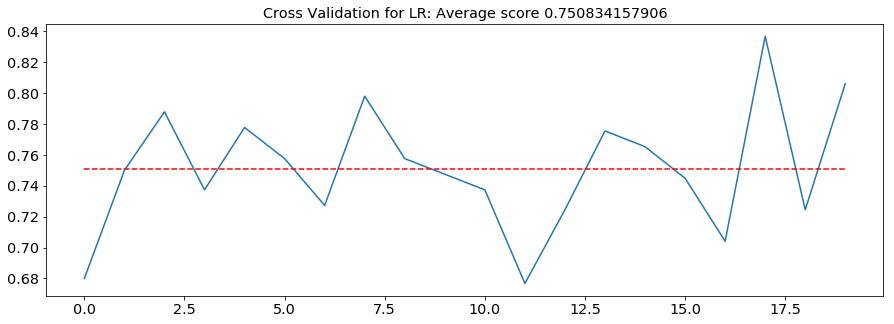

In [72]:
lr = LogisticRegression()
perform_cross_validation(lr, 'LR', X_std, Ytrain, model_results)

In [73]:
model=lr
model.fit(Xtrain, Ytrain)
lr_ans = model.predict(Xvalidate)
print(accuracy_score(lr_ans, Yvalidate))

0.788461538462


**Decision Tree Classifier**


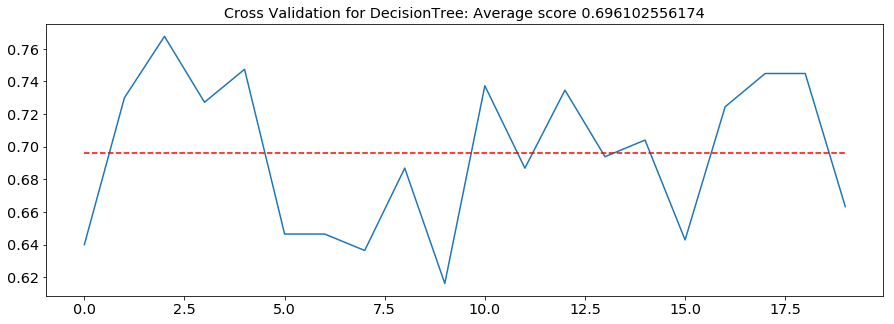

In [74]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
perform_cross_validation(tree, 'DecisionTree', X_std, Ytrain, model_results)

In [75]:
model=tree
model.fit(Xtrain, Ytrain)
tree_ans = model.predict(Xvalidate)
print(accuracy_score(tree_ans, Yvalidate))

0.701923076923


** Bagging tree classifier **

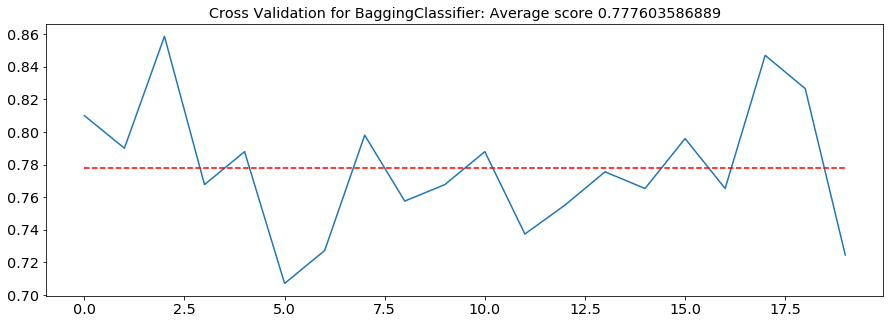

In [76]:
bag = BaggingClassifier(
    base_estimator=tree,
    n_estimators=5000,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=True,
    n_jobs=16
)
perform_cross_validation(bag, 'BaggingClassifier', X_std, Ytrain, model_results)


In [77]:
model=bag
model.fit(Xtrain, Ytrain)
bag_ans = model.predict(Xvalidate)
print(accuracy_score(bag_ans, Yvalidate))

0.798076923077


** Random forest classifier **

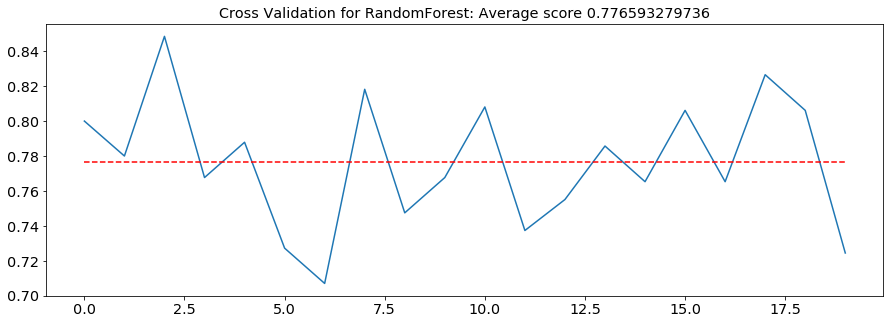

In [78]:
forest = RandomForestClassifier(
    n_estimators=10000,
    n_jobs=16
)
perform_cross_validation(forest, 'RandomForest', X_std, Ytrain, model_results)

**And just for fun...because sklearn makes it so easy...MLP classifier**

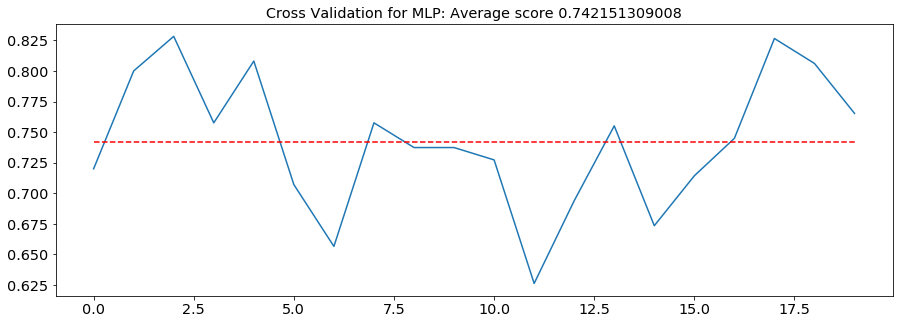

In [95]:
mmc = MinMaxScaler()

X_mm = mmc.fit_transform(Xtrain)
Xvalidate_mm = mmc.transform(Xvalidate)

mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100, 10, 10, 10), learning_rate='invscaling', max_iter=int(1e5))

perform_cross_validation(mlp, 'MLP', X_mm, Ytrain, model_results)

In [97]:
model=mlp
model.fit(X_mm, Ytrain)
mlp_ans = model.predict(Xvalidate_mm)
print(accuracy_score(mlp_ans, Yvalidate))

0.740384615385


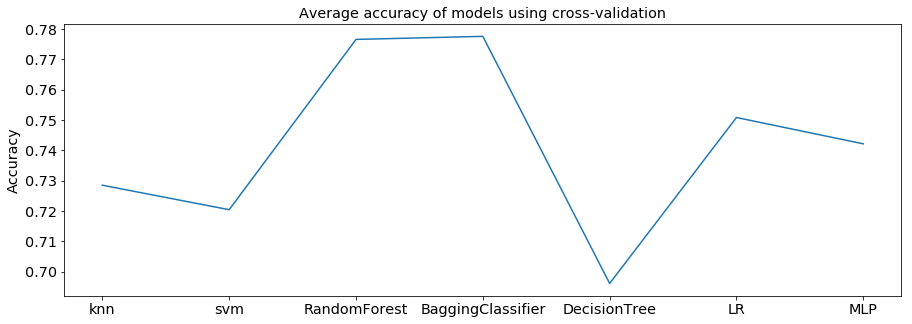

In [98]:
plt.plot(model_results.values())
plt.xticks(range(len(model_results)), model_results.keys())
plt.title('Average accuracy of models using cross-validation')
plt.ylabel('Accuracy')

Based on above analyses, all of the models do a pretty good job at classifying the three types of noise, but not a great job. There is not a single model that well out-performs another.

But do just make a decision as a main model to use for classification and optimization anlayses, **Bagging Classifier** seems to perform well with the given data

Even though the bagging classifier works well, the other models work more or less equally well. It would be interesting to see whether these models are correlated with one another. We can potentially use uncorrelated models in and ensembling technique

In [107]:
model_prediction_results = pd.DataFrame(
    np.vstack([
        kn1_ans, svm_ans, forest_ans, bag_ans, tree_ans, lr_ans, mlp_ans
    ]).T,
    columns = ['KNN', 'SVM', 'RF', 'BC', 'DT', 'LR', 'MLP']
)

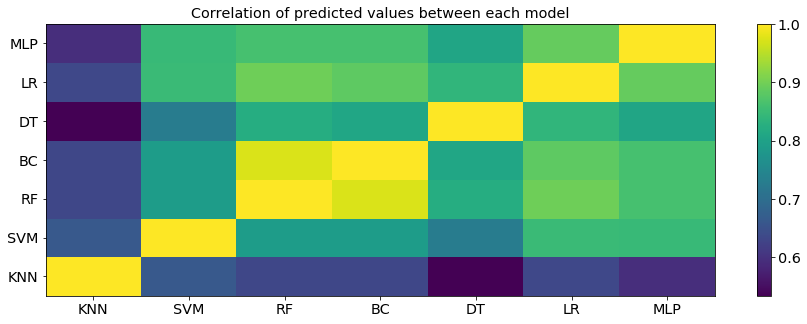

In [123]:
plt.pcolor(
    model_prediction_results.corr()
)
labels = model_prediction_results.columns
plt.xticks([(i + 0.5) for i in range(len(labels))], labels)
plt.yticks([(i + 0.5) for i in range(len(labels))], labels)
plt.colorbar()
plt.title('Correlation of predicted values between each model')

With respect to bagging classifier, the SVM and KNN seem the least correlated, so using an ensembling technique with these three classifiers improves accuracy slightly

In [6]:
from scipy.stats import mode


In [ ]:
print('Accuracy after "voting" between bagging classifier, KNN, and SVM')
accuracy_score(
    model_prediction_results[['BC', 'KNN', 'SVM']].apply(lambda x: mode(x)[0][0], axis=1).values,
    Yvalidate
)

** Evaluation of how well each event is classified **

The bagging classifier shows an average accuracy of ~0.77. For this situation, consider the % of noise that were accurately predicted, the % of S1 events and the % of S2 events

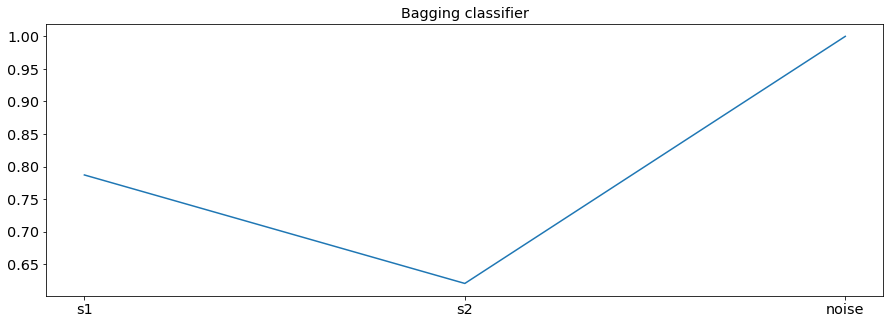

In [136]:
s1_per_acc = accuracy_score(bag_ans[Yvalidate==0], Yvalidate[Yvalidate==0])
s2_per_acc = accuracy_score(bag_ans[Yvalidate==1], Yvalidate[Yvalidate==1])
noise_per_acc = accuracy_score(bag_ans[Yvalidate == 2], Yvalidate[Yvalidate == 2])
plt.plot([s1_per_acc, s2_per_acc, noise_per_acc])
plt.xticks([0,1,2], ['s1', 's2', 'noise'])
plt.title('Bagging classifier')

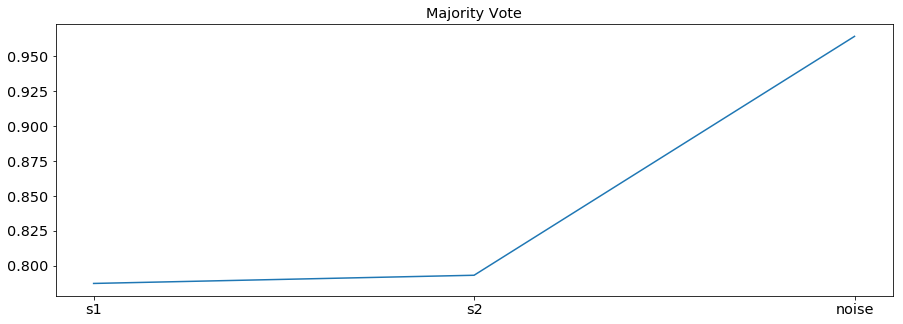

In [138]:
tmp = model_prediction_results[['BC', 'KNN', 'SVM']].apply(lambda x: mode(x)[0][0], axis=1).values
s1_per_acc = accuracy_score(tmp[Yvalidate==0], Yvalidate[Yvalidate==0])
s2_per_acc = accuracy_score(tmp[Yvalidate==1], Yvalidate[Yvalidate==1])
noise_per_acc = accuracy_score(tmp[Yvalidate == 2], Yvalidate[Yvalidate == 2])
plt.plot([s1_per_acc, s2_per_acc, noise_per_acc])
plt.xticks([0,1,2], ['s1', 's2', 'noise'])
plt.title('Majority Vote')

**Conclusions at this point**
1. Most models seem to be able to classify the predefined S1/S2/NOISE events similarly at ~70%
2. The bagging estimator produces one of the best results on average
3. Predicting noise from S1/S2 seems pretty easy ( > 90%) but differentiating S1 from S2 is much harder especially differentiating S2
4. Ensembling together the results from KNN, SVM, AND Bagging classifier might further improve accuracy, but a large majority of that improvement comes from S2 calls


## Stage D: Optimize parameters for extracting features ##

In the previous stages we decided that the following features would help classify the data:
    
    1. Amplitude at each time point
    2. Sum, max peak, or min peak of all amplitudes within a window
    3. Spectrogram of frequencies within a window
    4. Change in amplitude at each time point
    
From these features we selected that the bagging classifier was working the best

** In this stage, using the bagging classifier as a model, we focus on looking for optimium window sizes for [2] and [3], identifying the cutoff for the low pass frequency filter n the raw dataset,  and deciding whether to standardize the raw signal amplitudes **


**Window optimization: First we will loop through possible window sizes and analyze how they affect the accuracy of the bagging classifier**

*Note the next cell takes a few hours to run, so results are stored on file and loaded afterwards*

In [173]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(
    base_estimator=tree,
    n_estimators=5000,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=True,
    n_jobs=16
)
# create a pipeline for the models with standard scaling
pipe_bc = Pipeline([
    ('std', StandardScaler()),
    ('clf', bag)
]
)

In [ ]:
# modify average amplitude window and spec window
import multiprocessing

global_acc_dic = []

def worker_fxn(w1, w2, global_acc_dic):
    
    print(w1)
    print(w2)
    # t1 = pd.read_csv('window_amplitudes_' + str(w1) + '.csv', index_col=0).stack()
    # t2 = pd.read_csv('specs_' + str(w2) + '.csv', index_col=[0, 1], header=[0, 1])
    # for i, r in features_and_response.iterrows():
    #    features_and_response.loc[i, 'AverageAmplitude'] = t1.loc[i[0]][int(i[1])]
    #    features_and_response.loc[i, 'spec'] = t2.loc[(i[0], i[1])]['spec']
    features_and_response, heart_group = load_wav_data_into_features(
        wave_folder_path='set_b/normal/', training_segmentation_file='./set_b/Btraining_normal_seg.csv',
        time_point_spec=w2,
        time_point_avg_window=w1,
        l_time_trim = 0.1, r_time_trim=0.1
    )
    print('generated!')
    features_and_response_null_drop = features_and_response[features_and_response.isnull().sum(axis=1)==0]
    features_and_response_null_drop_no_noise = features_and_response_null_drop  # features_and_response_null_drop[features_and_response_null_drop[('info', 'response')] != 'NOISE']
    X = features_and_response_null_drop_no_noise[amp_col + spec_col].values
    y = features_and_response_null_drop_no_noise['info']['response'].map({'S1': 0, 'S2': 1, 'NOISE': 2}).values
    print(np.unique(y))
    print(w1)
    print(w2)
    
    scores = cross_val_score(estimator=pipe_bc, X=X, y=y, cv=20, n_jobs=2)
    global_acc_dic.append({'w1': w1, 'w2': w2, 'acc': np.mean(scores), 'std': np.std(scores)})
    print('Average accuracy', w1, w2,  np.mean(scores), np.std(scores))
    with open('windows_rough_{0}_{1}.txt'.format(w1, w2), 'w') as o:
        o.write(str(np.mean(scores)) + ',' + str(np.std(scores)))
    
    print('DONE!')






In [139]:
# load results stored on file
global_acc_dic = []
for w1 in [0.001, 0.01, 0.05, 0.1, 1]:
    for w2 in [0.001, 0.01, 0.05, 0.1, 1]:
        with open('windows_rough_{0}_{1}.txt'.format(w1, w2)) as e:
            acc = float(e.read())
            global_acc_dic.append({'w1': w1, 'w2': w2, 'acc': acc})
window_size_vs_acc = pd.DataFrame(global_acc_dic)
window_size_vs_acc.pivot(
    index='w1', columns='w2', values='acc'
)

w2        0.001     0.010     0.100     1.000
w1                                           
0.001  0.633333  0.626667  0.740000  0.590000
0.010  0.626667  0.626667  0.753333  0.600000
0.100  0.720000  0.703333  0.796667  0.673333
1.000  0.593333  0.653333  0.763333  0.550000

**Plot to see how each window size affected the accuracy of the model **

The following plots how accuracy changed as a function of window size. It seems that the best window sizes for both amplitudes and spectrogram is 0.1


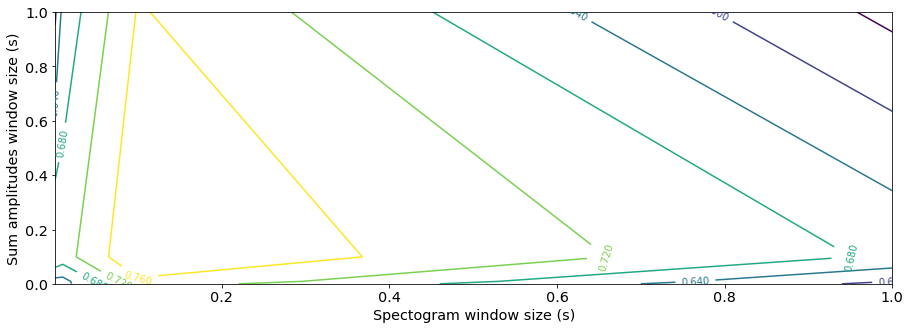

In [140]:
CS = plt.contour(window_size_vs_acc['w2'].unique(), window_size_vs_acc['w1'].unique(), window_size_vs_acc.pivot(
    index='w1', columns='w2', values='acc')
)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('Spectogram window size (s)')
plt.ylabel('Sum amplitudes window size (s)')

In [168]:
final_confirmed_window_amplitude = 0.05
final_confirmed_window_spec = 0.1

** Noise filter optimization: Modify the cutoff for the noise pass filter, See at which point accuracy drops **

In [ ]:
# modify noise filtering
import multiprocessing

global_acc_dic = []

w1 = final_confirmed_window_amplitude
w2 = final_confirmed_window_spec

def worker():
    """worker function"""
    print 'Worker'
    return

def worker_fxn(noise_filter, global_acc_dic):
    
    print(w1)
    print(w2)
    print(noise_filter)
    # t1 = pd.read_csv('window_amplitudes_' + str(w1) + '.csv', index_col=0).stack()
    # t2 = pd.read_csv('specs_' + str(w2) + '.csv', index_col=[0, 1], header=[0, 1])
    # for i, r in features_and_response.iterrows():
    #    features_and_response.loc[i, 'AverageAmplitude'] = t1.loc[i[0]][int(i[1])]
    #    features_and_response.loc[i, 'spec'] = t2.loc[(i[0], i[1])]['spec']
    features_and_response, heart_group = load_wav_data_into_features(
        wave_folder_path='set_b/normal/', 
        training_segmentation_file='./set_b/Btraining_normal_seg.csv',
        time_point_spec=w2,
        time_point_avg_window=w1,
        noise_filter=noise_filter,
        l_time_trim = 0.1, r_time_trim=0.1
    )
    features_and_response_null_drop = features_and_response[features_and_response.isnull().sum(axis=1)==0]
    X = features_and_response_null_drop[amp_col + spec_col].values
    y = features_and_response_null_drop['info']['response'].map({'S1': 0, 'S2': 1, 'NOISE': 2}).values
    print(np.unique(y))
    
    scores = cross_val_score(estimator=pipe_bc, X=X, y=y, cv=20, n_jobs=2)
    global_acc_dic.append({'w1': w1, 'w2': w2, 'noise': noise_filter, 'acc': np.mean(scores), 'std': np.std(scores)})
    print('Average accuracy', w1, w2,  np.mean(scores), np.std(scores))
    with open('noise_{0}.txt'.format(n), 'w') as o:
        o.write(str(np.mean(scores)) + ',' + str(np.std(scores)))
    print('DONE!')
    
c = 0
ind = 0
groups = []
for n in [10, 20, 50, 100, 150, 180, 250, None]:
    ind = int(c/8)
    while ind >= len(groups):
        groups.append([])
    groups[ind].append(n)
    c +=1 

print('total jobs: ', len(groups))

for i, g in enumerate(groups):        
    print('staring', i)
    jobs = []
    for n in g:
        p = multiprocessing.Process(target=worker_fxn, args=(n, global_acc_dic,))
        jobs.append(p)
        p.start()

    for j in jobs:
        j.join()



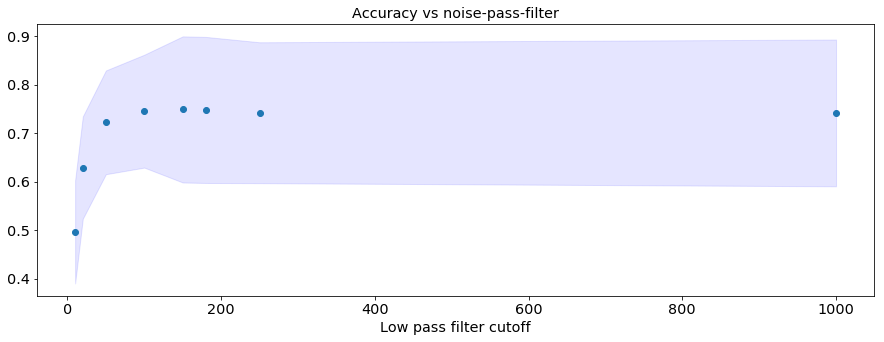

In [164]:
noise_dic = []
for n in [10, 20, 50, 100, 150, 180, 250, None]:    
    with open('noise_{0}.txt'.format(n)) as e:
        line = e.read()
        line = line.strip().split(',')
        acc = float(line[0])
        stdv = float(line[1])
        noise_dic.append({'filter': n if n is not None else 1000, 'acc': acc, 'std': stdv })
x_pt = pd.DataFrame(noise_dic)['filter']
avg_v = pd.DataFrame(noise_dic)['acc']
std_v = pd.DataFrame(noise_dic)['std']
plt.plot(x_pt, avg_v , 'o')
plt.fill_between(x_pt, avg_v + std_v, avg_v - std_v, alpha=0.10, color='blue', label='validation train')
plt.title('Accuracy vs noise-pass-filter')
plt.xlabel('Low pass filter cutoff')
plt.xticks(range(len([10, 20, 50, 100, 150, 180, 250, None])), [10, 20, 50, 100, 150, 180, 250, 'None'])

From the previous analysis, it seems as though an optimium noise pass filter needs to remain >=50 HZ. 100 HZ has the max accuracy with the least variance, so that will be selected as the optimum

1. Noise pass filter: 100 HZ

In [7]:
final_confirmed_window_amplitude = 0.1
final_confirmed_window_spec = 0.1
final_noise_pass_filter = 100

**Normalize raw data: Analyze whether normalizing each raw signal improves accuracy**

Use minmax scaling

In [ ]:
features_and_response, heart_group = load_wav_data_into_features(
    wave_folder_path='set_b/normal/', training_segmentation_file='./set_b/Btraining_normal_seg.csv',
    time_point_spec=final_confirmed_window_spec,
    time_point_avg_window=final_confirmed_window_amplitude,
    noise_filter=final_noise_pass_filter,
    normalize_raw_signal='minmax',
    l_time_trim = 0.1, r_time_trim=0.1
)

features_and_response_null_drop = features_and_response[features_and_response.isnull().sum(axis=1)==0]
X = features_and_response_null_drop[amp_col + spec_col].values
y = features_and_response_null_drop['info']['response'].map({'S1': 0, 'S2': 1, 'NOISE': 2}).values

scores = cross_val_score(estimator=pipe_bc, X=X, y=y, cv=20, n_jobs=1)

    

In [174]:
print('Average accuracy', 'minmax', np.mean(scores), np.std(scores))


('Average accuracy', 'minmax', 0.72405766302039865, 0.11660301507383548)


Use standard scaling

In [ ]:
features_and_response, heart_group = load_wav_data_into_features(
    wave_folder_path='set_b/normal/', training_segmentation_file='./set_b/Btraining_normal_seg.csv',
    time_point_spec=final_confirmed_window_spec,
    time_point_avg_window=final_confirmed_window_amplitude,
    noise_filter=final_noise_pass_filter,
    normalize_raw_signal='standard',
    l_time_trim = 0.1, r_time_trim=0.1
)

features_and_response_null_drop = features_and_response[features_and_response.isnull().sum(axis=1)==0]
X = features_and_response_null_drop[amp_col + spec_col].values
y = features_and_response_null_drop['info']['response'].map({'S1': 0, 'S2': 1, 'NOISE': 2}).values

scores = cross_val_score(estimator=pipe_bc, X=X, y=y, cv=10, n_jobs=1)

    

In [176]:
print('Average accuracy', 'standard', np.mean(scores), np.std(scores))


('Average accuracy', 'standard', 0.72718440527712147, 0.088012128830724498)


In [182]:
tst, tst_group = load_wav_data_into_features(
    wave_folder_path='set_b/normal/', training_segmentation_file='./set_b/Btraining_normal_seg.csv',
    l_time_trim = 0.1, r_time_trim=0.1
)


settings
('noise filter', 50)
('window_amplitudes', 0.1)
('window_spec', 0.1)
('trims:', 0.1, 0.1)
('normalization', None)
reading in files
converted 0 values with unexpected large values to null
converted 3 values with unexpected TIME POINTS (i.e. S2 < s1 to null)
4000.0
Low pass filter
None
Get average amplitude
individual amplitude
individual differences
Get spectrogram
WARNING DUPLICATE ROWS WERE DELETED, UNEXPECTED!!!
                 basename col_name      pos response  window
633   178_1307989887769_D    S1.14  38940.0       S1     400
1333  178_1307989887769_D    S2.14  38940.0       S2     400
2023  178_1307989887769_D    NOISE  38940.0    NOISE     400
generate features


** Conclusions at this point: **

There did not appear to be any necessity to optimize parameters for extracting features. Most of the optimized values were already the defaults, or only resulted in subtle changes.

1. Have windows be within 0.1s
2. Optionally, Use noisefilter > 50 hz
3. Optionally standardize signals

## Stage E: Optimize hyperparameters for model ##

** In this stage, we will extract the finalized features for our dataset in datasetB. We need to then move on with these features and see if we can optimize the ML hyperparameters**



In [8]:
def plot_learning_curve(X, y,pipeline=None, cv=10, test_line_color='red', return_info=False, n_jobs=-1, 
                        train_sizes=np.linspace(0.1, 1, 10) ):
    if pipeline is None:    
        pipeline = Pipeline([        
            ('clf', BaggingClassifier(
                    base_estimator=DecisionTreeClassifier(max_depth=3),
                    n_estimators=50,
                    max_features=1.0,
                    bootstrap=True,
                    bootstrap_features=True,
                    n_jobs=1
                )
            )
        ])
         
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=pipeline,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        n_jobs=n_jobs
    )  
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, '-', color=test_line_color)
    plt.fill_between(train_sizes, train_mean + train_std, train_mean-train_std, alpha=0.15, color='blue', label='validation train')
    plt.plot(train_sizes, test_mean, color=test_line_color)
    plt.fill_between(train_sizes, test_mean + test_std, test_mean-test_std, alpha=0.15, color='green', label='validation test')
    
    if return_info:
        return train_sizes, train_scores, test_scores
    

def plot_validation_curve(X, y, pipeline, parameter_update, param_range, cv=10, n_jobs=1, return_info=False):
    if pipeline is None:    
        pipeline = Pipeline([        
            ('clf', BaggingClassifier(
                    base_estimator=DecisionTreeClassifier(max_depth=3),
                    n_estimators=50,
                    max_features=1.0,
                    bootstrap=True,
                    bootstrap_features=True,
                    n_jobs=1
                )
            )
        ])
    
    xvals = []
    for i, p in enumerate(param_range):
        if isinstance(p, int) or isinstance(p, float):
            xvals.append(p)
        else:
            xvals.append(i)
    
    train_scores, test_scores = validation_curve(
        estimator=pipeline,
        X=X,
        y=y,
        param_name=parameter_update,
        param_range=param_range,
        cv=cv,
        n_jobs=n_jobs
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(xvals, train_mean)
    plt.fill_between(
        xvals, 
        train_mean + train_std, train_mean-train_std, 
        alpha=0.15, color='blue', label='validation train'
    )
    plt.plot(xvals, test_mean)
    plt.fill_between(
        xvals, 
        test_mean + test_std, 
        test_mean-test_std, alpha=0.15, color='green', label='validation test'
    )
    
    if return_info:
        return train_scores, test_scores
    

In [9]:
# loead the final features
features_and_response = None
del features_and_response

finalized_features_and_response, heart_group = load_wav_data_into_features(
    wave_folder_path='set_b/normal/', training_segmentation_file='./set_b/Btraining_normal_seg.csv',
    time_point_spec=final_confirmed_window_spec,
    time_point_avg_window=final_confirmed_window_amplitude,
    noise_filter=final_noise_pass_filter,
    normalize_raw_signal='standard',
    l_time_trim = 0.1, r_time_trim = 0.1
)



settings
('noise filter', 100)
('window_amplitudes', 0.1)
('window_spec', 0.1)
('trims:', 0.1, 0.1)
('normalization', 'standard')
reading in files
converted 0 values with unexpected large values to null
converted 3 values with unexpected TIME POINTS (i.e. S2 < s1 to null)
4000.0
Low pass filter
standard
Get average amplitude
individual amplitude
individual differences
Get spectrogram
WARNING DUPLICATE ROWS WERE DELETED, UNEXPECTED!!!
                 basename col_name      pos response  window
633   178_1307989887769_D    S1.14  38940.0       S1     400
1333  178_1307989887769_D    S2.14  38940.0       S2     400
2023  178_1307989887769_D    NOISE  38940.0    NOISE     400
generate features


In [10]:
features_and_response_null_drop = finalized_features_and_response[finalized_features_and_response.isnull().sum(axis=1)==0]
amp_col = ['AverageAmplitude', 'MaxAbs', 'MaxAmp', 'MinAmp', 'MaxDist', 'MinDist', 'AmplitudeDifference', 'IndAmp']
amp_col = list(finalized_features_and_response[amp_col].columns)
# use these frequencies from a spectrogram
spec_col = [('spec', c) for c in list(features_and_response_null_drop['spec'].iloc[:, :30].columns)]

features_opt = features_and_response_null_drop[amp_col + spec_col]
X_opt = features_opt.values
y_opt = features_and_response_null_drop['info']['response'].map({'S1': 0, 'S2': 1, 'NOISE': 2}).values

In [11]:
[Xtrain, Xvalidate, Ytrain, Yvalidate] = train_test_split(X_opt.copy(), y_opt.copy(), train_size=0.95)

In [12]:
X_cv_b = Xtrain.copy()
y_cv_b = Ytrain.copy()

First evaluate the degree of overfitting for the current model

In [17]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
    
pipe_bt = Pipeline([
    ('clf', BaggingClassifier(
        base_estimator=tree,
        n_estimators=500,
        max_features=1.0,
        bootstrap=True,
        bootstrap_features=True,
        n_jobs=1
    ))
])

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_bt,
    X=X_cv,
    y=y_cv,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=20,
    n_jobs=14
)

In [18]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

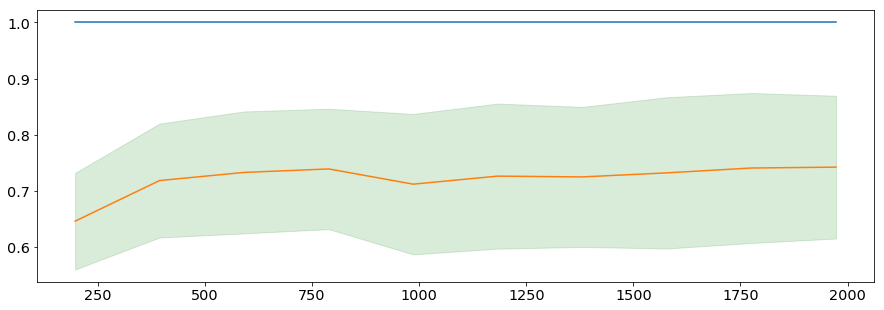

In [19]:
plt.plot(train_sizes, train_mean)
plt.fill_between(train_sizes, train_mean + train_std, train_mean-train_std, alpha=0.15, color='blue', label='validation train')
plt.plot(train_sizes, test_mean)
plt.fill_between(train_sizes, test_mean + test_std, test_mean-test_std, alpha=0.15, color='green', label='validation test')

The training is overfit. So optimize settings to decrease overfitting

*Change the max depth of the tree *

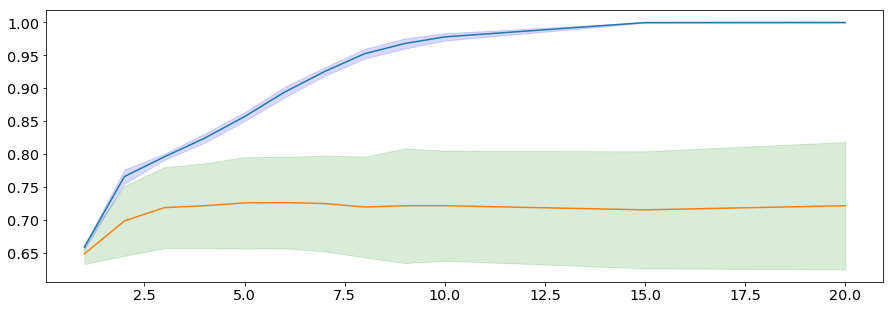

In [25]:
param_range = [
 1,2,3,4,5,6,7,8,9,10, 15, 20   
]

pipe_bt = Pipeline([
    ('clf', BaggingClassifier(
        base_estimator=DecisionTreeClassifier(),
        n_estimators=500,
        max_features=1.0,
        bootstrap=True,
        bootstrap_features=True,
        n_jobs=-1
    ))
])

plot_validation_curve(X_cv_b, y_cv_b, pipe_bt, 'clf__base_estimator__max_depth', param_range)

Accuracy in testing sets saturates at about a depth of 3-5

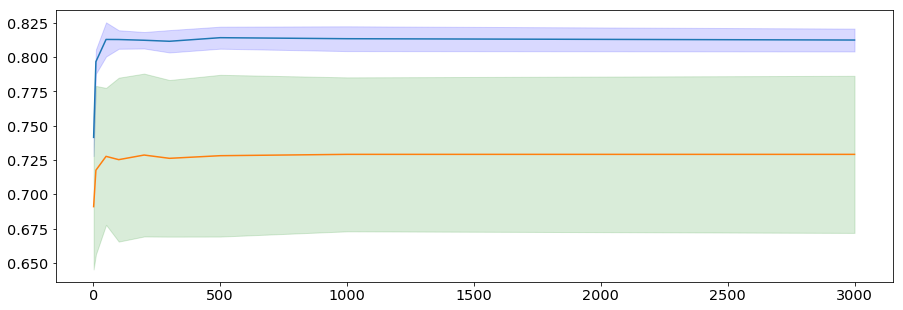

In [26]:
param_range = [
 1,10, 50, 100, 200, 300, 500, 1000, 3000 
]

pipe_bt = Pipeline([
    # ('scl', StandardScaler()),
    ('clf', BaggingClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=4, criterion='entropy'),
        n_estimators=500,
        max_features=1.0,
        bootstrap=True,
        bootstrap_features=True,
        n_jobs=-1
    ))
])
plot_validation_curve(X_cv_b, y_cv_b, pipe_bt, 'clf__n_estimators', param_range)


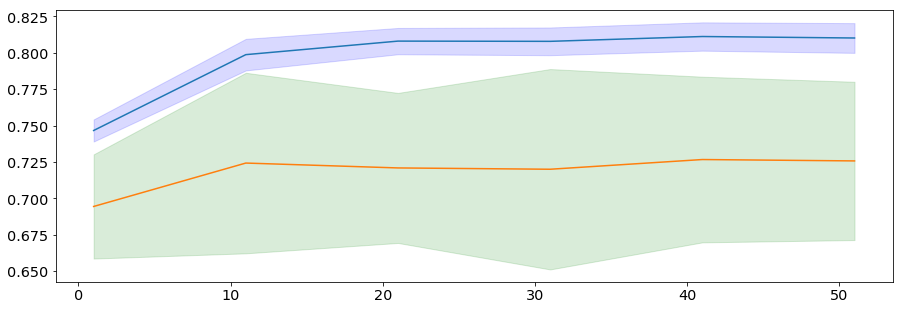

In [32]:
param_range = range(1, 52, 10)

pipe_bt = Pipeline([
    # ('scl', StandardScaler()),
    ('clf', BaggingClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=4, criterion='entropy'),
        n_estimators=500,
        max_features=1.0,
        bootstrap=True,
        bootstrap_features=True,
        n_jobs=1
    ))
])
plot_validation_curve(X_cv_b, y_cv_b, pipe_bt, 'clf__n_estimators', param_range, n_jobs=1)


Accuracy in the test set saturates after about 50 estimators

*Change max_depth to 4 *

*Change n_estimators to 50 *

In [13]:
# best settings: 
depth = 4
n_estimators = 50


Finally, extract the relevant features for the model

First check if any specs are interesting by introspection

With regard to the spectrogram, we want to find the most polarizing frequencies that are also not highly correlated to one another

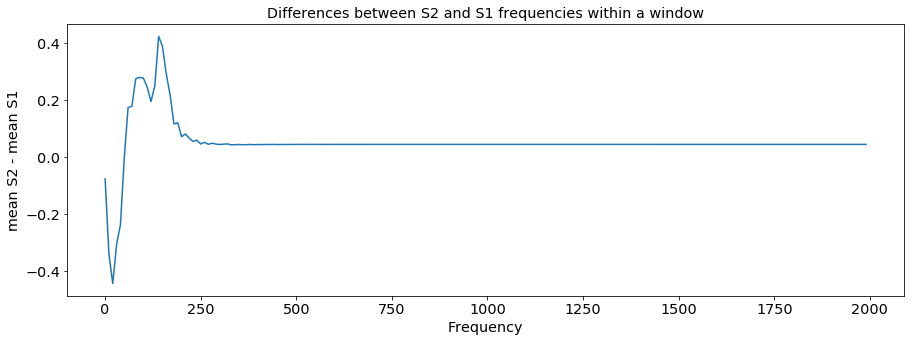

In [41]:
normalized_feature_introspection = features_and_response_null_drop.copy()
normalized_feature_introspection['spec'] = StandardScaler().fit_transform(normalized_feature_introspection['spec'])
plt.plot(
    normalized_feature_introspection.groupby(by=[('info', 'response')]).apply(np.mean)['spec'].columns,
    normalized_feature_introspection.groupby(by=[('info', 'response')]).apply(np.mean)['spec'].diff().iloc[-1]
)
plt.title('Differences between S2 and S1 frequencies within a window')
plt.xlabel('Frequency')
plt.ylabel('mean S2 - mean S1')

Based on the plot above, the following frequencies result in the most difference from S2/S1

1. 20, 
2. 100, 
3. 280

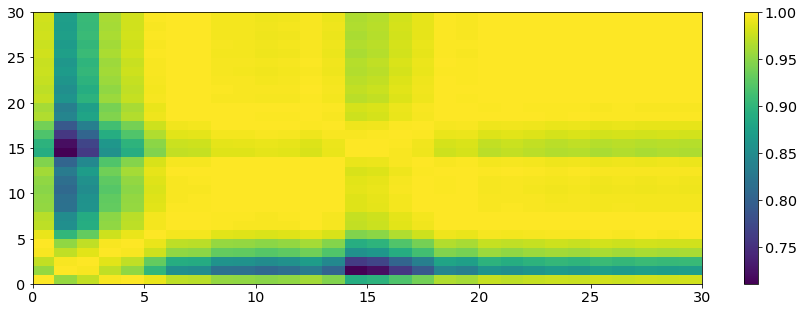

In [49]:
plt.pcolor(normalized_feature_introspection.groupby(by=[('info', 'response')]).apply(np.mean)['spec'].iloc[:, :30].corr())
plt.colorbar()

In addition, 160 does not seem to be correlaed with 20 so it could also be useful frequency


([<matplotlib.axis.XTick at 0x7f4d11396050>,
 <a list of 8 Text xticklabel objects>)

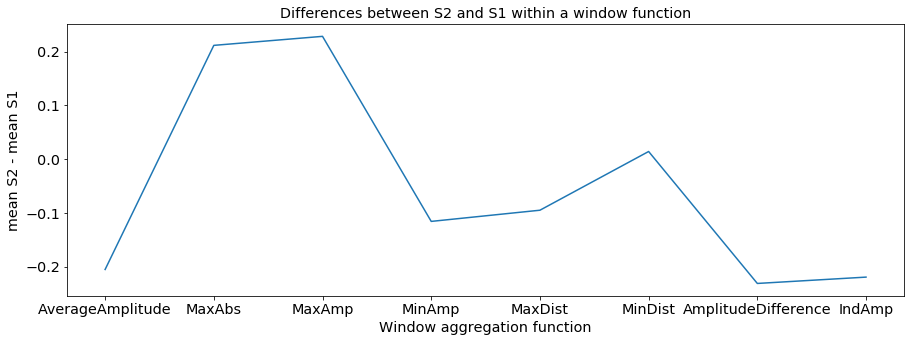

In [62]:
normalized_feature_introspection[amp_col] = StandardScaler().fit_transform(normalized_feature_introspection[amp_col])

plt.plot(
    range(len(amp_col)),
    normalized_feature_introspection.groupby(by=[('info', 'response')]).apply(np.mean)[amp_col].diff().iloc[-1]
)
plt.title('Differences between S2 and S1 within a window function')
plt.xlabel('Window aggregation function')
plt.ylabel('mean S2 - mean S1')
plt.xticks(range(len(amp_col)), [a[0] for a in amp_col])

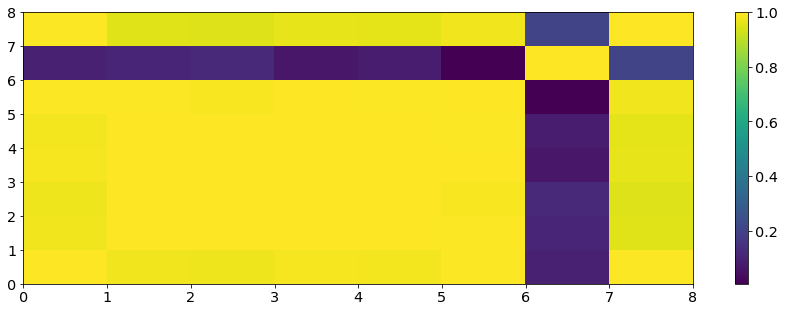

In [64]:
plt.pcolor(normalized_feature_introspection.groupby(by=[('info', 'response')]).apply(np.mean)[amp_col].iloc[:, :30].corr().abs())
plt.colorbar()

Based on the plot above, the following widnow functions might be useful

1. Max Amplitude
2. Amplitdue Difference

In [14]:
amp_col_spec = ['MaxAmp', 'AmplitudeDifference']
spec_freq_to_use = [20, 40, 100, 280, 160]

**Plot learning curve using newly optimized settings**

[['MaxAmp' '2']
 ['AmplitudeDifference' '6']
 ['spec' '20']
 ['spec' '40']
 ['spec' '90']
 ['spec' '160']
 ['spec' '280']]


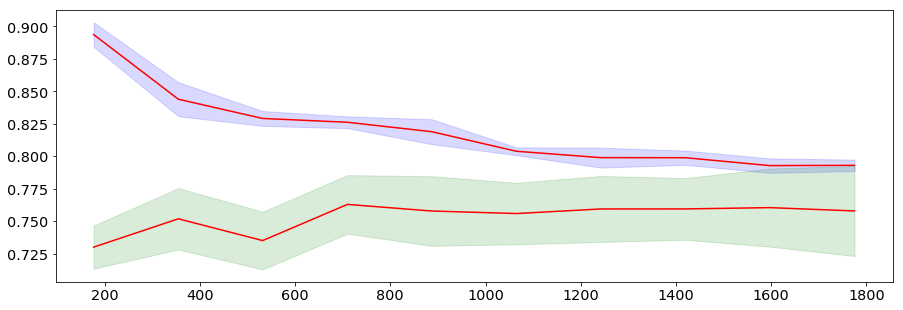

In [15]:
subset = [2, 6,  10, 12, 17, -14, -2]
print(np.array(amp_col + spec_col)[subset])
X_cv_b_subset = X_cv_b[:, subset]
bt_learn = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=depth, criterion='entropy'),
    n_estimators=n_estimators,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=True,
    n_jobs=1
)
plot_learning_curve(X_cv_b_subset, y_cv_b, bt_learn, n_jobs=-1)

Overfitting oberved previously has been diminished. Bias is still present but there is not much to be done about that with current features

Perform a quick validation test

In [70]:
print('Validation testset')
bt = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=depth, criterion='entropy'),
    n_estimators=n_estimators,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=True,
    n_jobs=1
)
bt.fit(X_cv_b_subset, y_cv_b)
bt_predict = bt.predict(Xvalidate[:, subset])
accuracy_score(bt_predict, Yvalidate)

Validation testset


0.78846153846153844

** Lets also consider if KNN model still works as before **

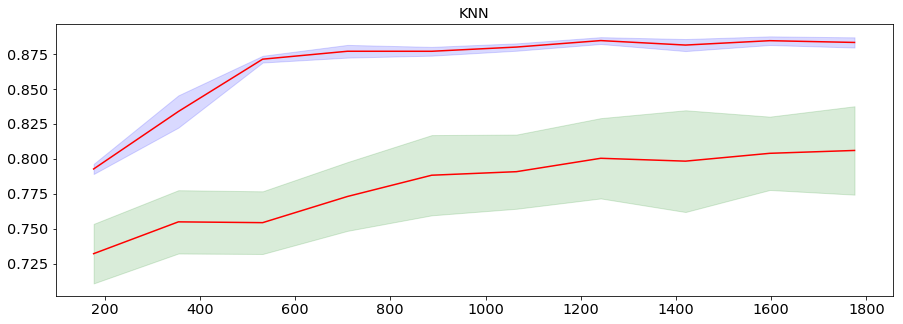

In [44]:
knn = KNeighborsClassifier(n_neighbors=4, p=1)
plot_learning_curve(X_cv_b, y_cv_b, knn, n_jobs=-1)
plt.title('KNN')

In [67]:
print('KNN VALIDATION')
knn.fit(X_cv_b, y_cv_b)
knn_predict = knn.predict(Xvalidate)
accuracy_score(knn_predict, Yvalidate)

KNN VALIDATION


0.81730769230769229

In [59]:
knn = KNeighborsClassifier(n_neighbors=4, p=1)
sbs_knn = SBS(knn, k_features=1, threads=16)
sbs_knn.fit(X_cv_b, y_cv_b)

<sequential_feature_remover.SBS instance at 0x7fbf1c7cca28>

In [ ]:
# svm = SVC(kernel='poly')
# plot_learning_curve(X_cv_b_subset, y_cv_b, svm, n_jobs=-1)
# svm.fit(X_cv_b_subset, y_cv_b)
# accuracy_score(svm.predict(Xvalidate), Yvalidate)

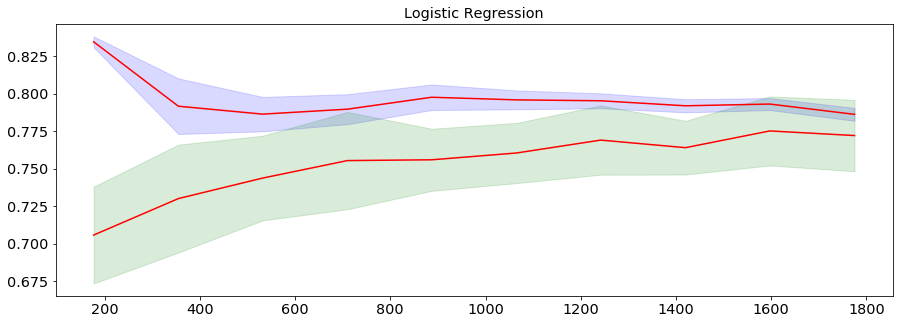

In [43]:
lr = LogisticRegression(penalty='l2', C=0.1, fit_intercept=True, dual=False)
plot_learning_curve(X_cv_b, y_cv_b, lr, n_jobs=-1)
plt.title('Logistic Regression')

In [48]:
print('LR VALIDATION')
lr.fit(X_cv_b, y_cv_b)
accuracy_score(lr.predict(Xvalidate), Yvalidate)

LR VALIDATION


0.76923076923076927

In [ ]:
sbs = SBS(lr, k_features=1, threads=16)
sbs.fit(X_cv_b, y_cv_b)

26


(0.6, 0.9)

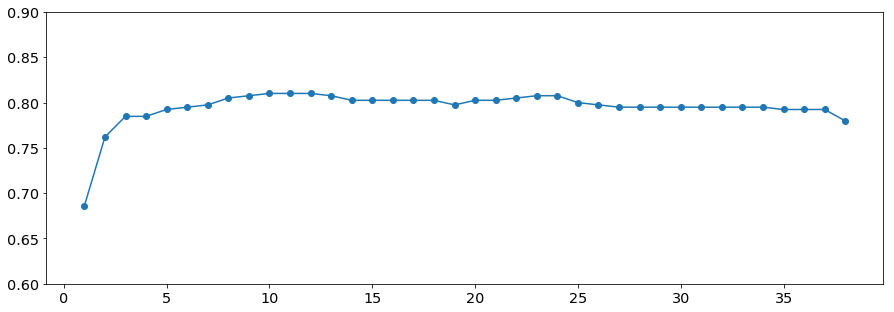

In [52]:
scores = []
ind = []
ind.append([_ for _ in sbs.subsets_])
scores.append([_ for _ in sbs.scores_])
print(np.argmax(sbs.scores_))
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.6, 0.9])

In [95]:
lr_feature_removal_subset = sbs.subsets_[-10]
print(lr_feature_removal_subset)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36)


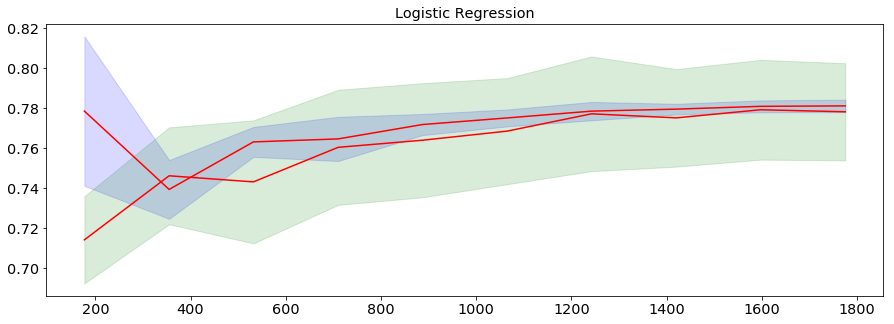

In [56]:
plot_learning_curve(X_cv_b[:, lr_feature_removal_subset], y_cv_b, lr, n_jobs=-1)
plt.title('Logistic Regression')

In [66]:
print('LR VALIDATION')
lr.fit(X_cv_b[:, lr_feature_removal_subset], y_cv_b)
lr_predict = lr.predict(Xvalidate[:, lr_feature_removal_subset])
accuracy_score(lr_predict, Yvalidate)

LR VALIDATION


0.77884615384615385

** Consider the accuracy from consensus voting **

In [86]:
merged_results = pd.DataFrame({'knn':knn_predict, 'bt': bt_predict, 'lr': lr_predict, 'real': Yvalidate})
majority = merged_results[['bt', 'lr', 'knn']].apply(lambda x: mode(x)[0][0], axis=1)
print('Accuracy using majority voting')
accuracy_score(majority, Yvalidate)

Accuracy using majority voting


0.81730769230769229

In [89]:
print('correlation between models')
merged_results[['bt', 'knn', 'lr']].corr()

correlation between models


bt       knn        lr
bt   1.000000  0.804987  0.831321
knn  0.804987  1.000000  0.829622
lr   0.831321  0.829622  1.000000

In [91]:
print('Accuracy at calling "S1"')
s1_vals = merged_results.loc[merged_results['real'] == 0, 'real']
merged_results[merged_results['real'] == 0][['bt', 'knn', 'lr']].apply(lambda x: accuracy_score(x, s1_vals))

Accuracy at calling "S1"


bt     0.56250
knn    0.81250
lr     0.59375
dtype: float64

In [92]:
print('Accuracy at calling "S2"')

s2_ind = merged_results['real'] == 1
s2_vals = merged_results.loc[s2_ind, 'real']

merged_results[s2_ind][['bt', 'knn', 'lr']].apply(lambda x: accuracy_score(x, s2_vals))

Accuracy at calling "S2"


bt     0.810811
knn    0.648649
lr     0.729730
dtype: float64

In [93]:
print('Accuracy at calling "Noise"')

n_ind = merged_results['real'] == 2
n_vals = merged_results.loc[n_ind, 'real']

merged_results[n_ind][['bt', 'knn', 'lr']].apply(lambda x: accuracy_score(x, n_vals))

Accuracy at calling "Noise"


bt     0.971429
knn    1.000000
lr     1.000000
dtype: float64

** Conclusions at this point: **

After the optimization steps performed above, we re-evaluated each of the models and we find that bagging classifier is still a good model, but perhaps not the *best*. With the new settings (probably due to the normalization techniques?) KNN seems to be a really good predictor in addition. 

However, it also seems like both models predict different features of wav file better or worse (i.e. in validation above, bt did better at classifying S1 and KNN did better at classifying S2)

** We will now move on to actually implementing the models where we will try and train the data and test against unseen wav files and predict S1/S2 positions. In the model we will:**

1. Perform training on KNN, LR, and bagging classifier
2. Use different subsets/features for *each* model that provided the best results above

### Implement Model ###

1. Extract features and responses from the training data in datasetB
2. Define the three models we will be using:
    * knn (uses all features for classification)
    * lr (uses..)
    * bagging classifier (uses the following columns for classification: [2, 6,  10, 12, 17, -14, -2])
3. Train the three models using data from training set
4. Load in new wav files that are unlabelled
5. Extract features at *ALL* frame positions (because we do not know if they are S1, S2, NOISE)
6. Fit each position to each model

*Extract features from datasetb*

In [ ]:
# create the features one last time....
# loead the final features
features_and_response = None
finalized_features_and_response = None
del features_and_response
del finalized_features_and_response

model_training_features_and_response, heart_group = load_wav_data_into_features(
    wave_folder_path='set_b/normal/', training_segmentation_file='./set_b/Btraining_normal_seg.csv',
    time_point_spec=final_confirmed_window_spec,
    time_point_avg_window=final_confirmed_window_amplitude,
    noise_filter=final_noise_pass_filter,
    normalize_raw_signal='standard',
    l_time_trim = 0.1, r_time_trim = 0.1
)

model_training_features_and_response_null_drop = model_training_features_and_response[
    model_training_features_and_response.isnull().sum(axis=1)==0
]
amp_col = ['AverageAmplitude', 'MaxAbs', 'MaxAmp', 'MinAmp', 'MaxDist', 'MinDist', 'AmplitudeDifference', 'IndAmp']
amp_col = list(model_training_features_and_response[amp_col].columns)
# use these frequencies from a spectrogram
spec_col = [('spec', c) for c in list(model_training_features_and_response_null_drop['spec'].iloc[:, :30].columns)]
features_opt = model_training_features_and_response_null_drop[amp_col + spec_col]
X_opt = features_opt.values
y_opt = model_training_features_and_response_null_drop['info']['response'].map({'S1': 0, 'S2': 1, 'NOISE': 2}).values

In [100]:
X_opt.shape

(2078, 38)

*Isolate subsets of features for each model*

In [101]:
X_knn = X_opt[:, :].copy()
y_knn = y_opt.copy()

In [102]:
bt_cols = [2, 6, 10, 12, 17, -14, -2]
X_bt = X_opt[:, bt_cols].copy()
y_bt = y_opt.copy()

In [103]:
X_lr = X_opt[:, :].copy()
y_lr = y_opt.copy()

Fit the data to each model

In [106]:
bt = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=depth, criterion='entropy'),
    n_estimators=n_estimators,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=True,
    n_jobs=1
)
lr = LogisticRegression(penalty='l2', C=0.1, fit_intercept=True, dual=False)
knn = KNeighborsClassifier(n_neighbors=4, p=1)


In [107]:
print('Fitting to bagging...')
bt.fit(X_bt, y_bt)
print('Fitting to lr...')
lr.fit(X_lr, y_lr)
print('Fitting to knn...')
knn.fit(X_knn, y_knn)

Fitting to bagging...
Fitting to lr...
Fitting to knn...


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=1,
           weights='uniform')

*Load in wav data from unclassified files, extract the same features as from training data*

In [108]:
# load files for testing #
listed_test_files = ['103_1305031931979_B.aiff',
'103_1305031931979_D2.aiff',
'106_1306776721273_B1.aiff',
'106_1306776721273_C2.aiff',
'106_1306776721273_D1.aiff',
'106_1306776721273_D2.aiff',
'107_1305654946865_C1.aiff',
'126_1306777102824_B.aiff',
'126_1306777102824_C.aiff',
'133_1306759619127_A.aiff',
'134_1306428161797_C2.aiff',
'137_1306764999211_C.aiff',
'140_1306519735121_B.aiff',
'146_1306778707532_B.aiff',
'146_1306778707532_D3.aiff',
'147_1306523973811_A.aiff',
'148_1306768801551_D2.aiff',
'151_1306779785624_D.aiff',
'154_1306935608852_B1.aiff',
'159_1307018640315_B1.aiff',
'159_1307018640315_B2.aiff',
'167_1307111318050_A.aiff',
'167_1307111318050_C.aiff',
'172_1307971284351_B1.aiff',
'175_1307987962616_B1.aiff',
'175_1307987962616_D.aiff',
'179_1307990076841_B.aiff',
'181_1308052613891_D.aiff',
'184_1308073010307_D.aiff',
'190_1308076920011_D.aiff'
]
# match them to be equal to the current folder structure
files_in_folder = [os.path.join('set_b', 'normal', 'normal__' + l.replace('.aiff', '.wav')) for l in listed_test_files]


In [ ]:
# read in group
testing_wav_files = heart_signal(
    files = files_in_folder, 
    scale_data='standard',
)
testing_wav_files.create_df()
testing_wav_files.low_pass_filter(final_noise_pass_filter, inplace=True)

*Extract all features we require for the models*

In [ ]:
windows = testing_wav_files.data_df.samplerate.apply(lambda x: int(x*1.0*final_confirmed_window_amplitude))
windows = testing_wav_files.data_df.samplerate.apply(lambda x: int(x*1.0*final_confirmed_window_spec))
spectrogram_features = testing_wav_files.get_spectrogram_at_all_points(
    windows,
)

In [116]:
useful_frequencies = spectrogram_features['spec']# .loc[:, spectrogram_features['spec'].std(axis=0)>0]

In [112]:
windows = testing_wav_files.data_df.samplerate.apply(lambda x: int(x*1.0*final_confirmed_window_amplitude))
max_abs = testing_wav_files.get_window_signal(windows, method='max')
average_amplitudes = testing_wav_files.get_window_signal(windows, method='sum')
max_signal = testing_wav_files.get_window_signal(windows, method='max', absV=False)
min_signal = testing_wav_files.get_window_signal(windows, method='min', absV=False)
distance_from_max = testing_wav_files.distance_from(windows, method='max')
distance_from_min = testing_wav_files.distance_from(windows, method='min')
amplitude_difference = testing_wav_files.filtered_signal_df.rolling(window=3, center=True, axis=1).apply(lambda x: (x[-1] - x[0])/3)
amplitudes = testing_wav_files.filtered_signal_df.abs()



In [122]:
testing_responses = pd.concat(
    [
        spectrogram_features['info'], 
        useful_frequencies,
        average_amplitudes.stack(),
        max_abs.stack(),
        max_signal.stack(),
        min_signal.stack(),
        distance_from_max.stack(),
        distance_from_min.stack(),
        amplitude_difference.stack(),
        amplitudes.stack()
    ], axis=1, join='inner', 
    keys=['info', 'spec', 'AverageAmplitude', 'MaxAbs', 'MaxAmp', 'MinAmp', 'MaxDist', 'MinDist', 'AmplitudeDifference', 'IndAmp']
)
testing_responses[amp_col + spec_col].to_csv('DataSetB_TESTING_MODEL_RESULTS.csv', sep='\t')

In [138]:
testing_responses_null_drop = testing_responses[
    testing_responses.isnull().sum(axis=1)==0
]
testing_responses_null_drop = testing_responses_null_drop[amp_col+spec_col]

In [142]:
X_testing_real = testing_responses[amp_col + spec_col].values

In [143]:
X_knn_predict = X_testing_real[:, :].copy()
X_bt_predict = X_testing_real[:, bt_cols].copy()
X_lr_predict = X_testing_real[:, :].copy()


*Predict S1/S2/NOISE from features provided*

In [151]:
bagging_classifier_results = bt.predict_log_proba(X_bt_predict)
bagging_classifier_max = np.argmax(bagging_classifier_results, axis=1)

In [148]:
knn_classifier_results = knn.predict(X_knn_predict)

In [152]:
lr_classifier_results = lr.predict_log_proba(X_lr_predict)
lr_classifier_max = np.argmax(lr_classifier_results, axis=1)

In [160]:
compiled_results = pd.DataFrame(
    {
        'bagging': bagging_classifier_max, 
        'knn': knn_classifier_results,
        'lr': lr_classifier_max
    },
    index=testing_responses_null_drop.index
)

In [161]:
compiled_results

bagging  knn  lr
103_1305031931979_B 200         2    2   2
                    201         2    2   2
                    202         2    2   2
                    203         2    2   2
                    204         2    2   2
                    205         2    2   2
                    206         2    2   2
                    207         2    2   2
                    208         2    2   2
                    209         2    2   2
                    210         2    2   2
                    211         2    2   2
                    212         2    2   2
                    213         2    2   2
                    214         2    2   2
                    215         2    2   2
                    216         2    2   2
                    217         2    2   2
                    218         2    2   2
                    219         2    2   2
                    220         2    2   2
                    221         2    2   2
                    222         2    2   2
                    223         2    2   2
                    224         2    2   2
                    225         2    2   2
                    226         2    2   2
                    227         2    2   2
                    228         2    2   2
                    229         2    2   2
...                           ...  ...  ..
190_1308076920011_D 9184        2    2   2
                    9185        2    2   2
                    9186        2    2   2
                    9187        2    2   2
                    9188        2    2   2
                    9189        2    2   2
                    9190        2    2   2
                    9191        2    2   2
                    9192        2    2   2
                    9193        2    2   2
                    9194        2    2   2
                    9195        2    2   2
                    9196        2    2   2
                    9197        2    2   2
                    9198        2    2   2
                    9199        2    2   2
                    9200        2    2   2
                    9201        2    2   2
                    9202        2    2   2
                    9203        2    2   2
                    9204        2    2   2
                    9205        2    2   2
                    9206        2    2   2
                    9207        2    2   2
                    9208        2    2   2
                    9209        2    2   2
                    9210        2    2   2
                    9211        2    2   2
                    9212        2    2   2
                    9213        2    2   2

[567430 rows x 3 columns]

In [ ]:
def subselect(grp, sub, win):
    vals = []
    inds = []
    for i in range(0, sub.shape[0], win):
        tmp = sub.iloc[i:i+win, :]
        max_val = tmp.max(axis=0)
        center = int(tmp.shape[0]/2)
        ind = tmp.iloc[center].name[1]
        
        vals.append(max_val.values)
        inds.append(ind)
    return pd.DataFrame(vals, index=inds, columns=tmp.columns)
        
    
tp4 = pd.DataFrame(final_resulting_calls.groupby(level=0).apply(
    lambda x: subselect(x.name, x, 400)
))


** Final calls using majority voting for KNN, LR, bagging classifier**

In [162]:
lub_dub_calls = compiled_results.apply(lambda x: mode(x)[0][0], axis=1)
lub_dub_calls

103_1305031931979_B  200     2
                     201     2
                     202     2
                     203     2
                     204     2
                     205     2
                     206     2
                     207     2
                     208     2
                     209     2
                     210     2
                     211     2
                     212     2
                     213     2
                     214     2
                     215     2
                     216     2
                     217     2
                     218     2
                     219     2
                     220     2
                     221     2
                     222     2
                     223     2
                     224     2
                     225     2
                     226     2
                     227     2
                     228     2
                     229     2
                            ..
190_1308076920011_D  9184    2
        

** Did we do a good job at being able to guess where an S1 or S2 is?**

....*ehhhhh sorta, can cherrypick....*

In [183]:
lub_dub_calls_v2 = compiled_results.apply(lambda x: x.iloc[0] if len(x.unique()) == 1 else -1, axis=1)

In [ ]:
lub_dub_calls_v3 = lub_dub_calls_v2.rolling(50, center=True).apply(lambda x: mode(x)[0][0])
lub_dub_calls_v3 = lub_dub_calls_v3.dropna()

In [192]:
s1_test_maj = lub_dub_calls[lub_dub_calls == 0]
s2_test_maj = lub_dub_calls[lub_dub_calls == 1]

In [193]:
s1_test = lub_dub_calls_v2[lub_dub_calls_v2 == 0]
s2_test = lub_dub_calls_v2[lub_dub_calls_v2 == 1]

In [206]:
s1_test_maj_rolling = lub_dub_calls_v3[lub_dub_calls_v3 == 0]
s2_test_maj_rolling = lub_dub_calls_v3[lub_dub_calls_v3 == 1]

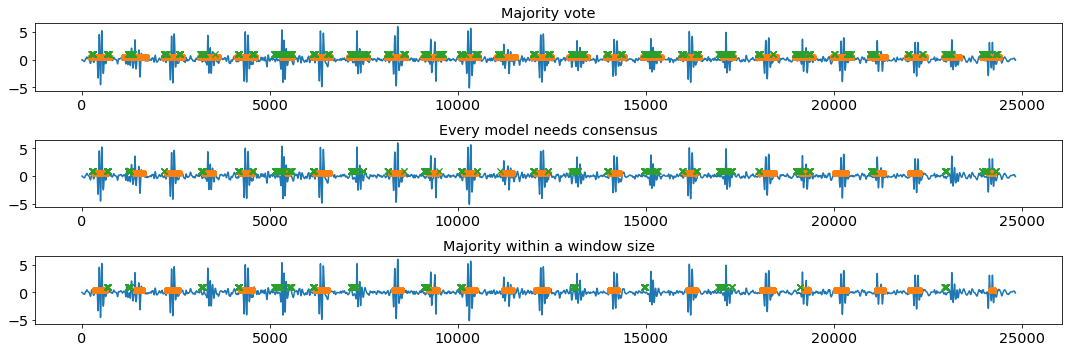

In [208]:
i = 0
tmp = testing_wav_files.filtered_signal_df.iloc[i]
s1_pts = s1_test.loc[tmp.name].index
s2_pts = s2_test.loc[tmp.name].index

s1_pts_maj = s1_test_maj.loc[tmp.name].index
s2_pts_maj = s2_test_maj.loc[tmp.name].index

s1_pts_roll = s1_test_maj_rolling.loc[tmp.name].index
s2_pts_roll = s2_test_maj_rolling.loc[tmp.name].index

plt.subplot(3, 1, 1)
plt.plot(tmp.index, tmp)
plt.plot(s1_pts_maj, [0.5]*len(s1_pts_maj), 'o')
plt.plot(s2_pts_maj, [1]*len(s2_pts_maj), 'x')
plt.title('Majority vote')
plt.subplot(3, 1, 2)
plt.plot(tmp.index, tmp)
plt.plot(s1_pts, [0.5]*len(s1_pts), 'o')
plt.plot(s2_pts, [1]*len(s2_pts), 'x')
plt.title('Every model needs consensus')
plt.subplot(3, 1, 3)
plt.plot(tmp.index, tmp)
plt.plot(s1_pts_roll, [0.5]*len(s1_pts_roll), 'o')
plt.plot(s2_pts_roll, [1]*len(s2_pts_roll), 'x')
plt.title('Majority within a window size')
plt.tight_layout()


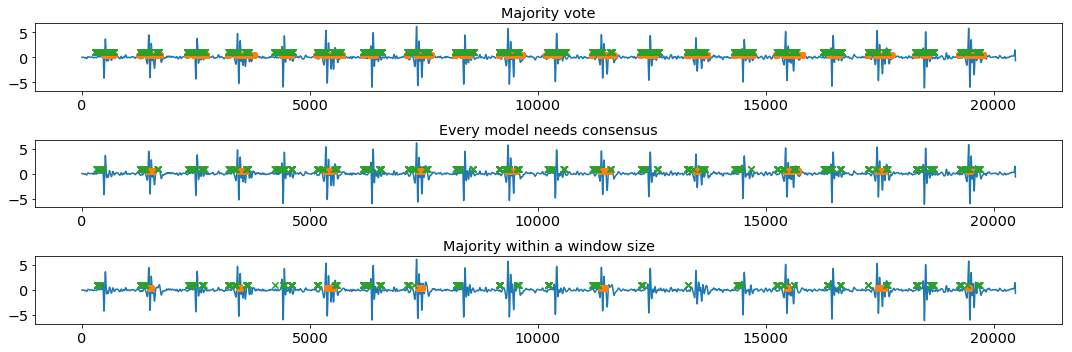

In [209]:
i = 1
tmp = testing_wav_files.filtered_signal_df.iloc[i]
s1_pts = s1_test.loc[tmp.name].index
s2_pts = s2_test.loc[tmp.name].index

s1_pts_maj = s1_test_maj.loc[tmp.name].index
s2_pts_maj = s2_test_maj.loc[tmp.name].index

s1_pts_roll = s1_test_maj_rolling.loc[tmp.name].index
s2_pts_roll = s2_test_maj_rolling.loc[tmp.name].index

plt.subplot(3, 1, 1)
plt.plot(tmp.index, tmp)
plt.plot(s1_pts_maj, [0.5]*len(s1_pts_maj), 'o')
plt.plot(s2_pts_maj, [1]*len(s2_pts_maj), 'x')
plt.title('Majority vote')
plt.subplot(3, 1, 2)
plt.plot(tmp.index, tmp)
plt.plot(s1_pts, [0.5]*len(s1_pts), 'o')
plt.plot(s2_pts, [1]*len(s2_pts), 'x')
plt.title('Every model needs consensus')
plt.subplot(3, 1, 3)
plt.plot(tmp.index, tmp)
plt.plot(s1_pts_roll, [0.5]*len(s1_pts_roll), 'o')
plt.plot(s2_pts_roll, [1]*len(s2_pts_roll), 'x')
plt.title('Majority within a window size')
plt.tight_layout()


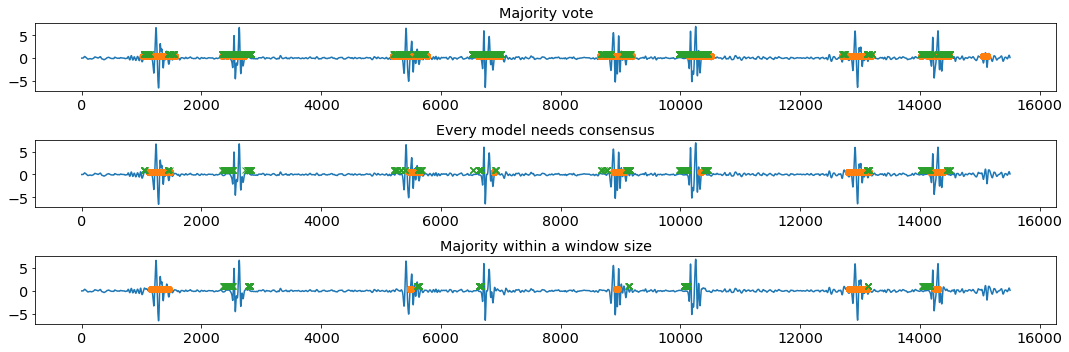

In [210]:
i = 2
tmp = testing_wav_files.filtered_signal_df.iloc[i]
s1_pts = s1_test.loc[tmp.name].index
s2_pts = s2_test.loc[tmp.name].index

s1_pts_maj = s1_test_maj.loc[tmp.name].index
s2_pts_maj = s2_test_maj.loc[tmp.name].index

s1_pts_roll = s1_test_maj_rolling.loc[tmp.name].index
s2_pts_roll = s2_test_maj_rolling.loc[tmp.name].index

plt.subplot(3, 1, 1)
plt.plot(tmp.index, tmp)
plt.plot(s1_pts_maj, [0.5]*len(s1_pts_maj), 'o')
plt.plot(s2_pts_maj, [1]*len(s2_pts_maj), 'x')
plt.title('Majority vote')
plt.subplot(3, 1, 2)
plt.plot(tmp.index, tmp)
plt.plot(s1_pts, [0.5]*len(s1_pts), 'o')
plt.plot(s2_pts, [1]*len(s2_pts), 'x')
plt.title('Every model needs consensus')
plt.subplot(3, 1, 3)
plt.plot(tmp.index, tmp)
plt.plot(s1_pts_roll, [0.5]*len(s1_pts_roll), 'o')
plt.plot(s2_pts_roll, [1]*len(s2_pts_roll), 'x')
plt.title('Majority within a window size')
plt.tight_layout()


### Discussion ###

* Using amplitudes and frequencies from audio files, and a mixture of KNN, LR, and bagging classifier methods, was able to classify S1/S2 peaks from the training set with 70-80% 
* Although the accuracy is higher than null, it does completely answer the main question of *WHERE EXACTLY* in the audo file is a single S1 and S2 time point
* In order to answer that question I probably need to figure out how to combine the results from the models and choose those closest to peaks of interest with high probability